## REDD: supervised learning on the energy disaggregation problem

##### Here we test some machine learning algorithm on extracting the refrigerator energy from mains consumptions. REDD contains data of 6 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

#### Import packages, read house 1 and house 2 data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

In [2]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')

('House 1: ', {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}, '\n')
('House 2: ', {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'}, '\n')


In [3]:
def read_merge_data(house):
    path = 'low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,3):
    df[i] = read_merge_data(i)

In [4]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))


('House 1 data has shape: ', (406748, 20))


mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-05-24 19:56:27   235.46    38.61     0.0     0.0           190.0   
2011-05-24 19:56:30   235.98    38.77     0.0     0.0           189.0   
2011-05-24 19:56:34   235.29    38.83     0.0     0.0           186.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-05-24 19:56:27          0.0               24.0               20.0   
2011-05-24 19:56:30          0.0               24.0               20.0   
2011-05-24 19:56:34          0.0               26.0               20.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-05-24 19:56:27         2.0              0.0           4.0   
2011-05-24 19:56:30         2.0              0.0           4.0   
2011-05-24 19:56:34         2.0              0.0           4.0   

                     bathroom_gfi_12  electric_heat_13  stove_14  \
2011-05-24 19:56:27              1.0               0.0       0.0   
2011-05-24 19:56:30              1.0               0.0       0.0   
2011-05-24 19:56:34              1.0               0.0       0.0   

                     kitchen_outlets_15  kitchen_outlets_16  lighting_17  \
2011-05-24 19:56:27                 1.0                 0.0          0.0   
2011-05-24 19:56:30                 1.0                 0.0          0.0   
2011-05-24 19:56:34                 1.0                 0.0          0.0   

                     lighting_18  washer_dryer_19  washer_dryer_20  
2011-05-24 19:56:27          1.0              0.0              0.0  
2011-05-24 19:56:30          1.0              0.0              0.0  
2011-05-24 19:56:34          1.0              0.0              0.0

('House 2 data has shape: ', (316840, 11))


mains_1  mains_2  kitchen_outlets_3  lighting_4  stove_5  \
2011-05-22 23:59:01    10.84   252.61                0.0         9.0      0.0   
2011-05-22 23:59:04    10.88   253.02                0.0         9.0      0.0   
2011-05-22 23:59:08    10.84   252.77                0.0         9.0      0.0   

                     microwave_6  washer_dryer_7  kitchen_outlets_8  \
2011-05-22 23:59:01          5.0             0.0                2.0   
2011-05-22 23:59:04          4.0             0.0                2.0   
2011-05-22 23:59:08          4.0             0.0                2.0   

                     refrigerator_9  dishwaser_10  disposal_11  
2011-05-22 23:59:01           158.0           0.0          0.0  
2011-05-22 23:59:04           160.0           0.0          0.0  
2011-05-22 23:59:08           157.0           0.0          0.0

In [5]:
np.savetxt("house1.txt", np.array(df[1]))
np.savetxt("house2.txt", np.array(df[2]))

In [6]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
(['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'], '\n')
House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
(['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'], '\n')


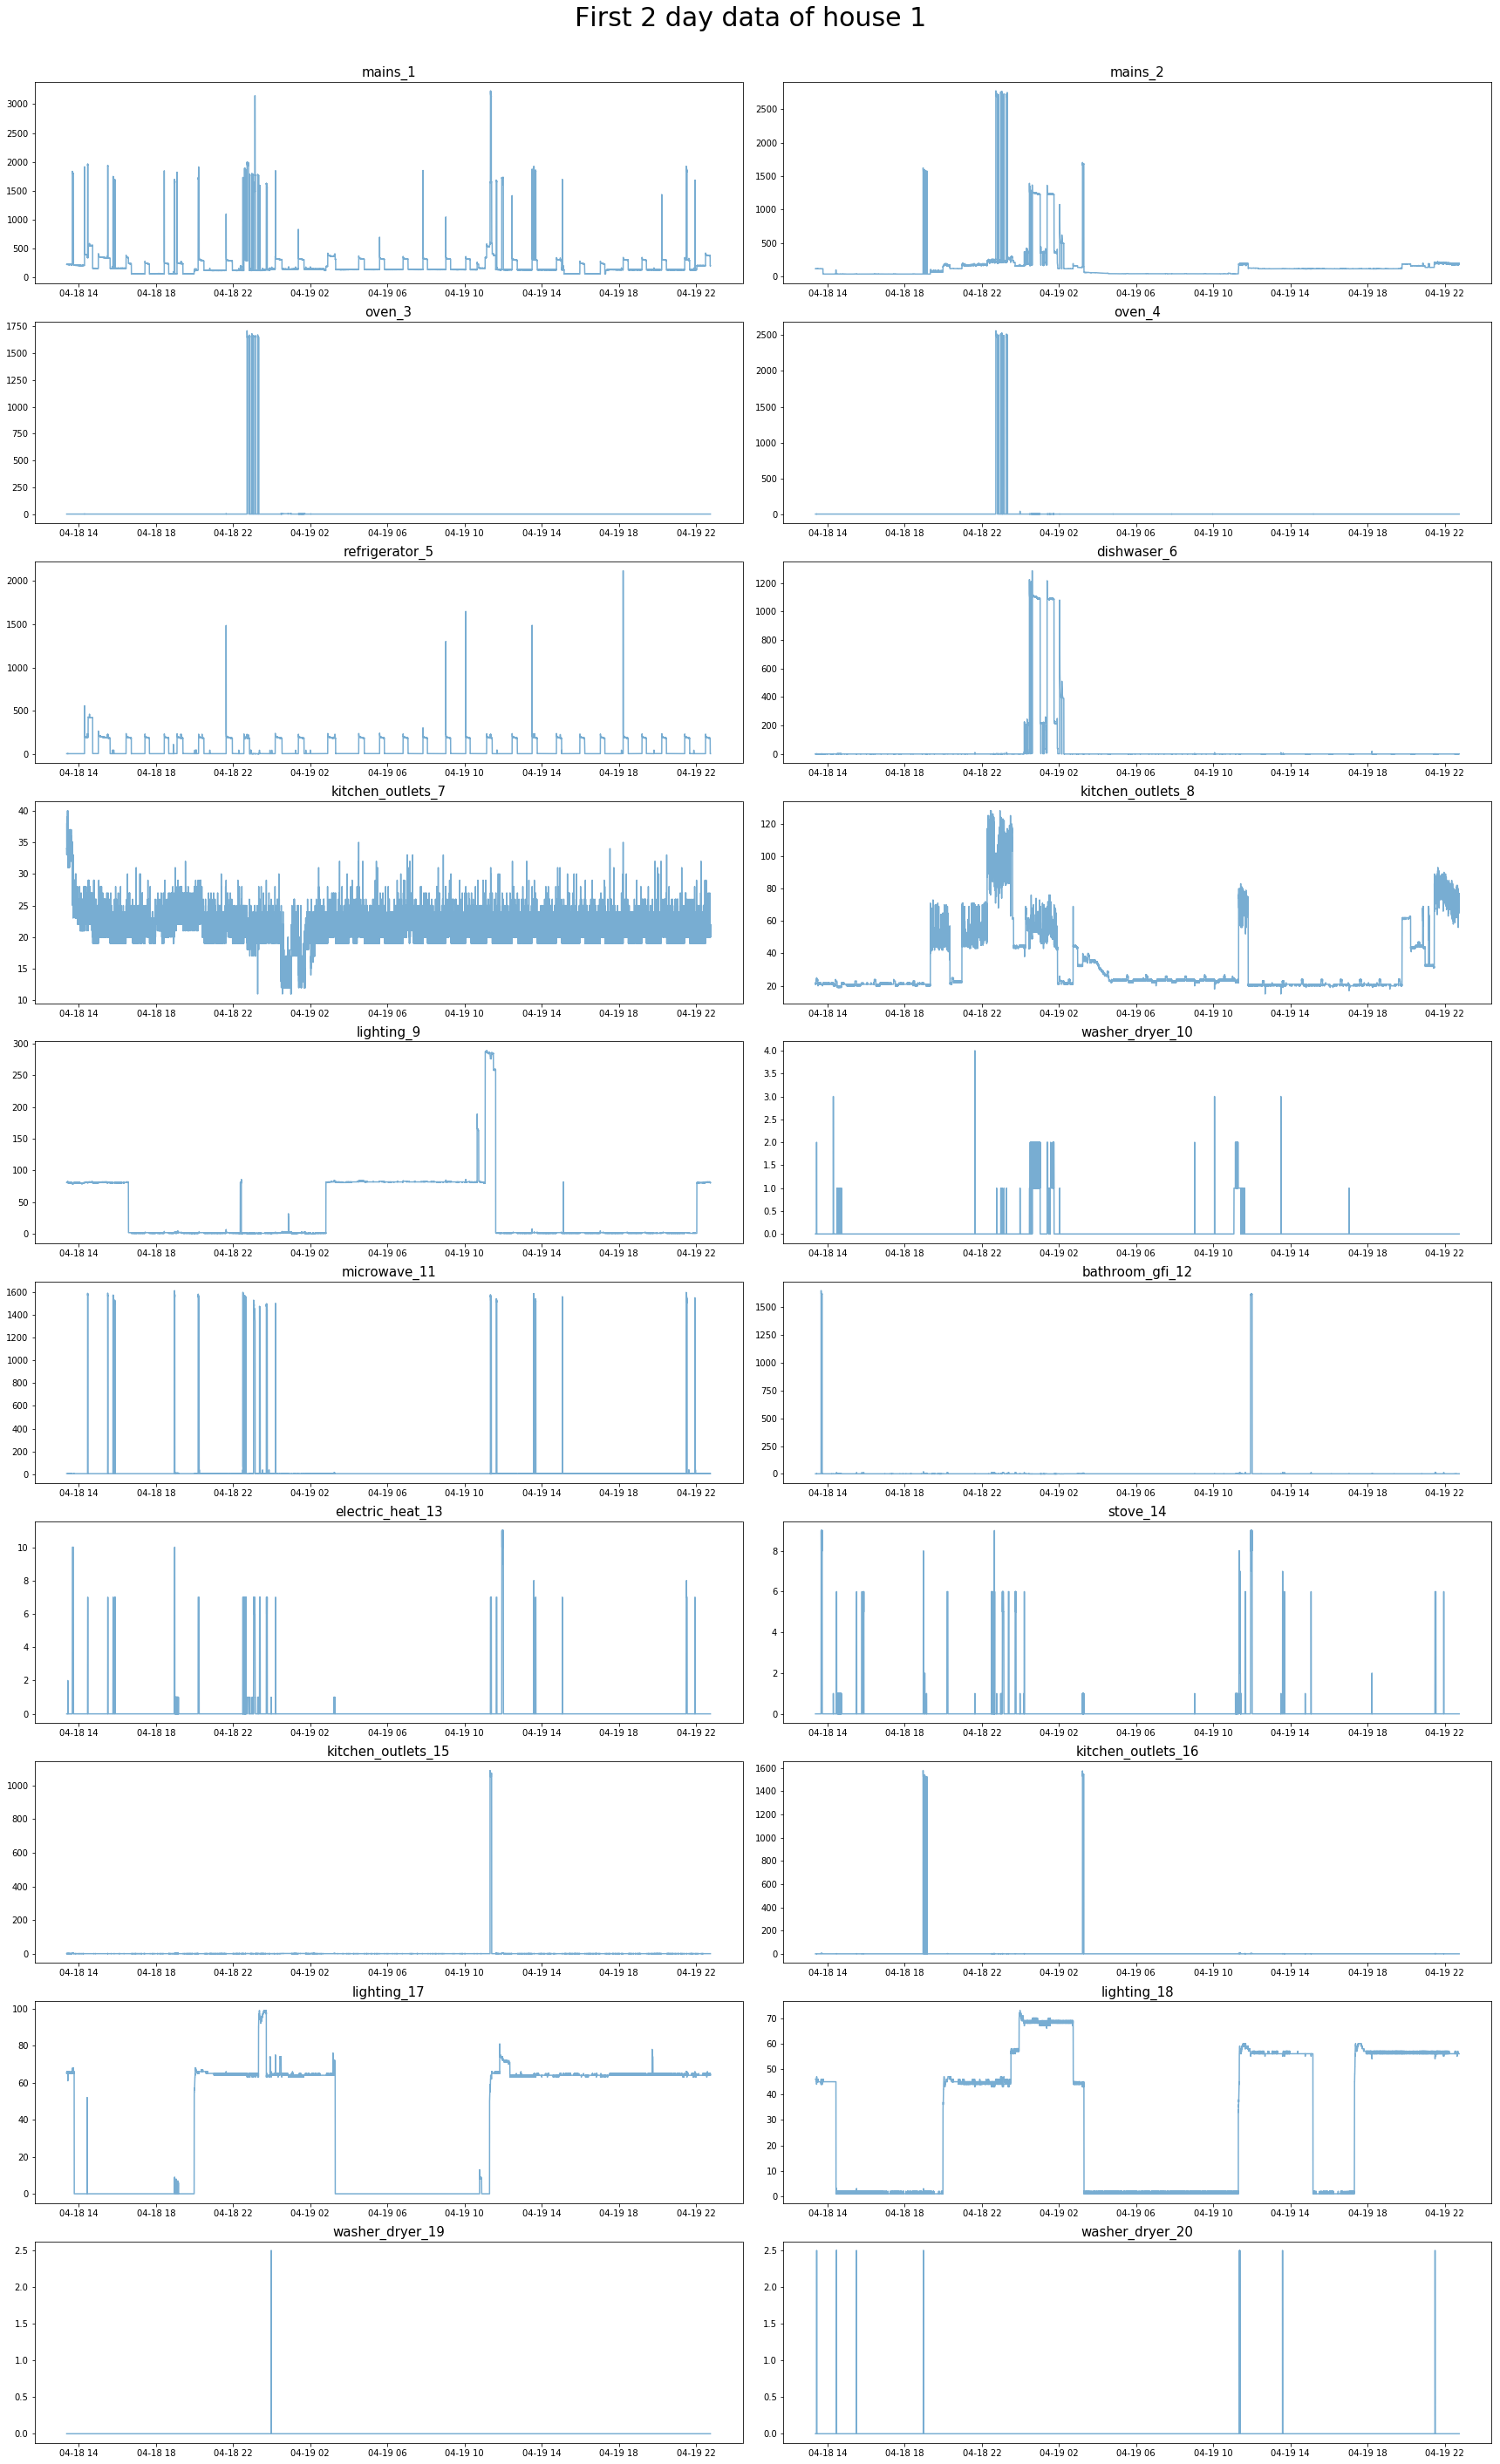

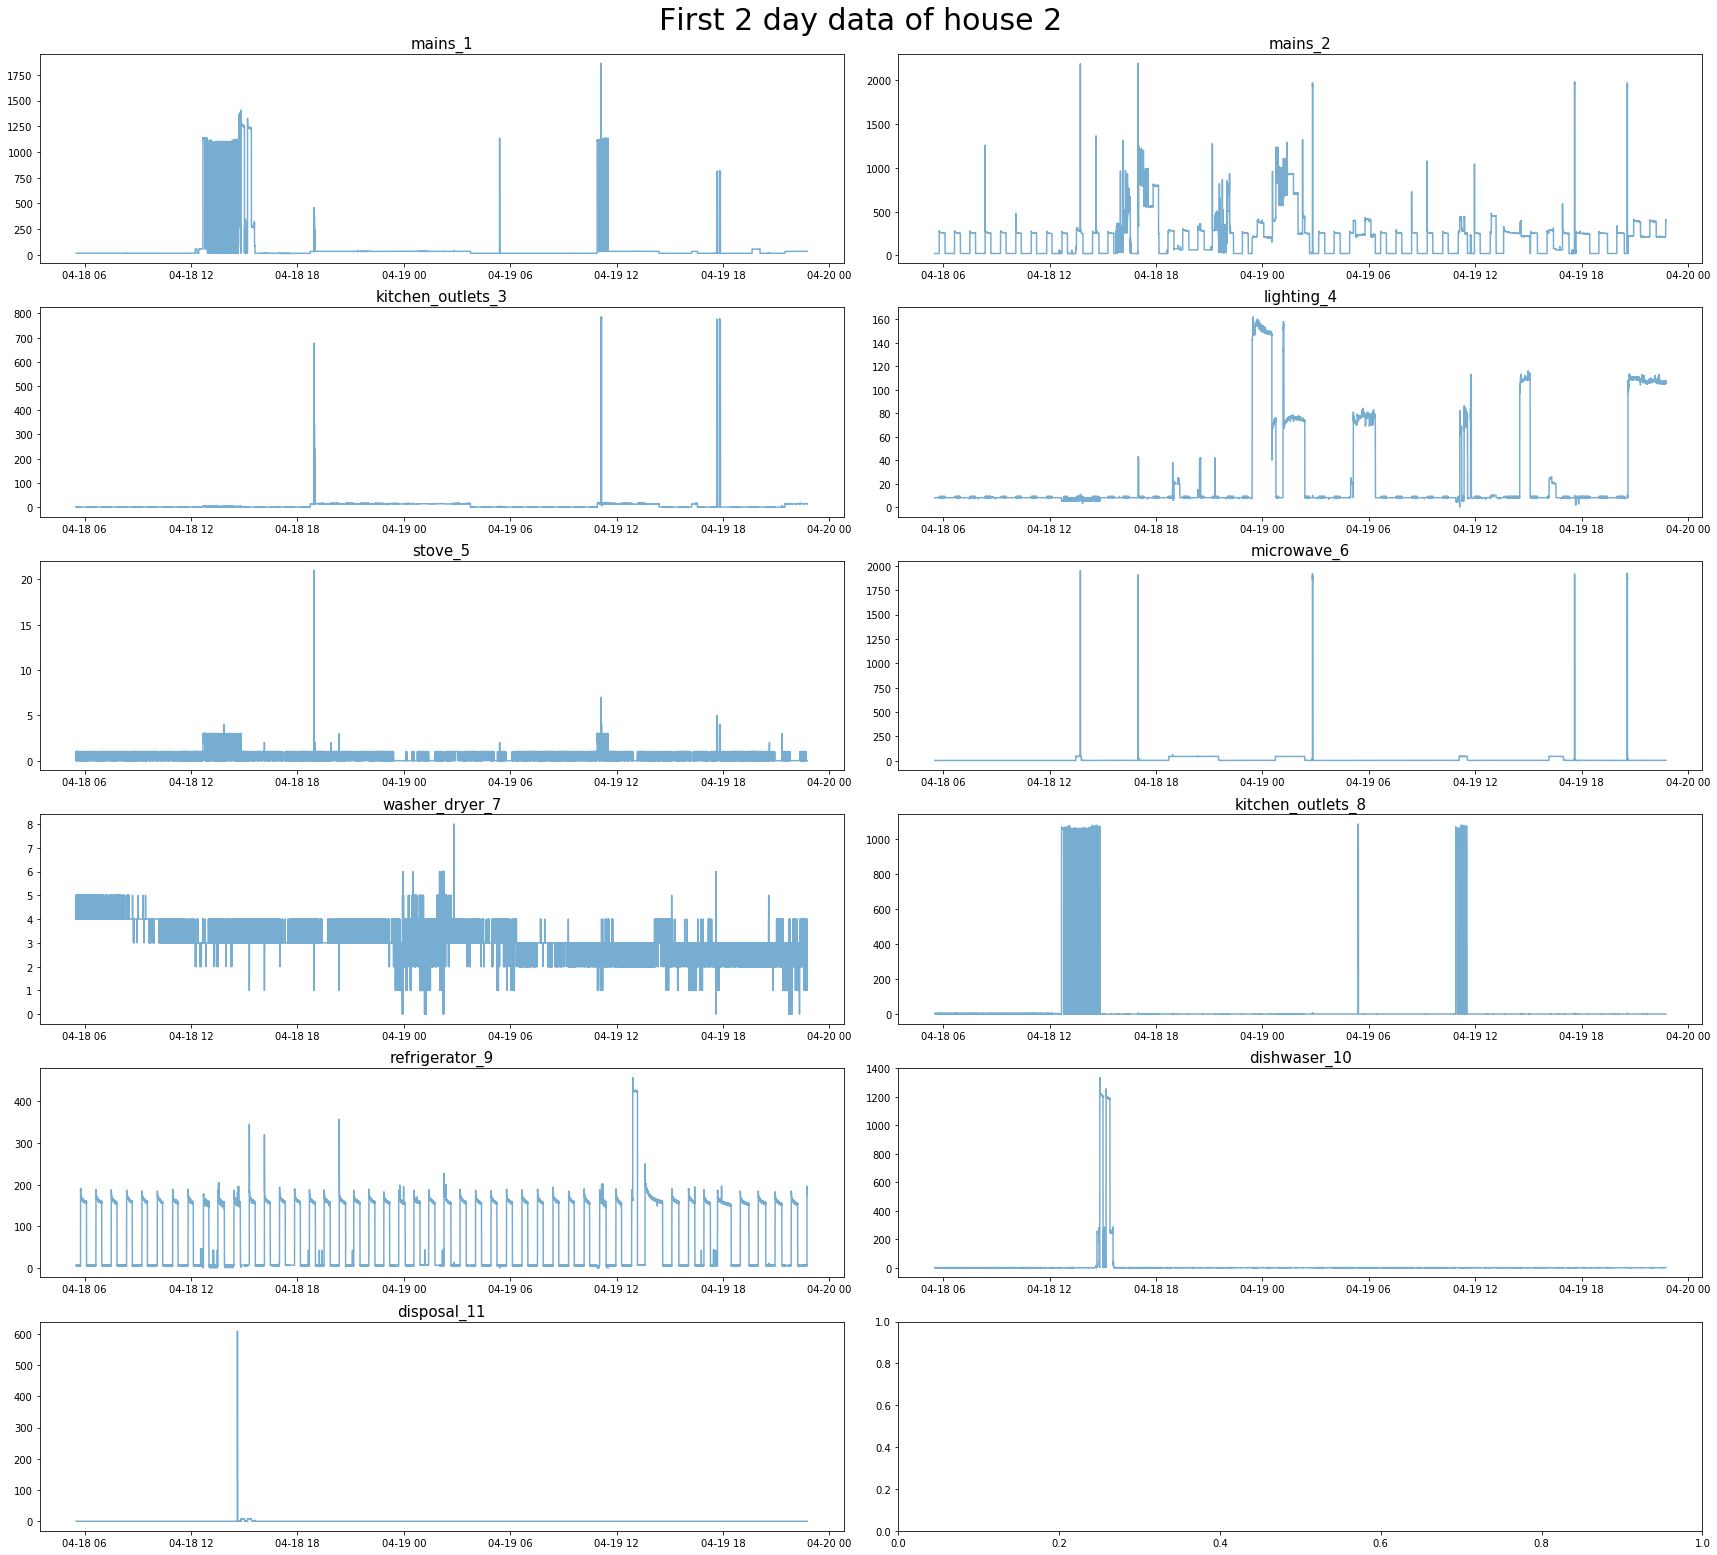

In [7]:
# Plot 2 first day data of house 1 and 2
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,3):
    plot_df(df[i].ix[:dates[i][1]], 'First 2 day data of house {}'.format(i))

Text(0.5,1,u'House 2')

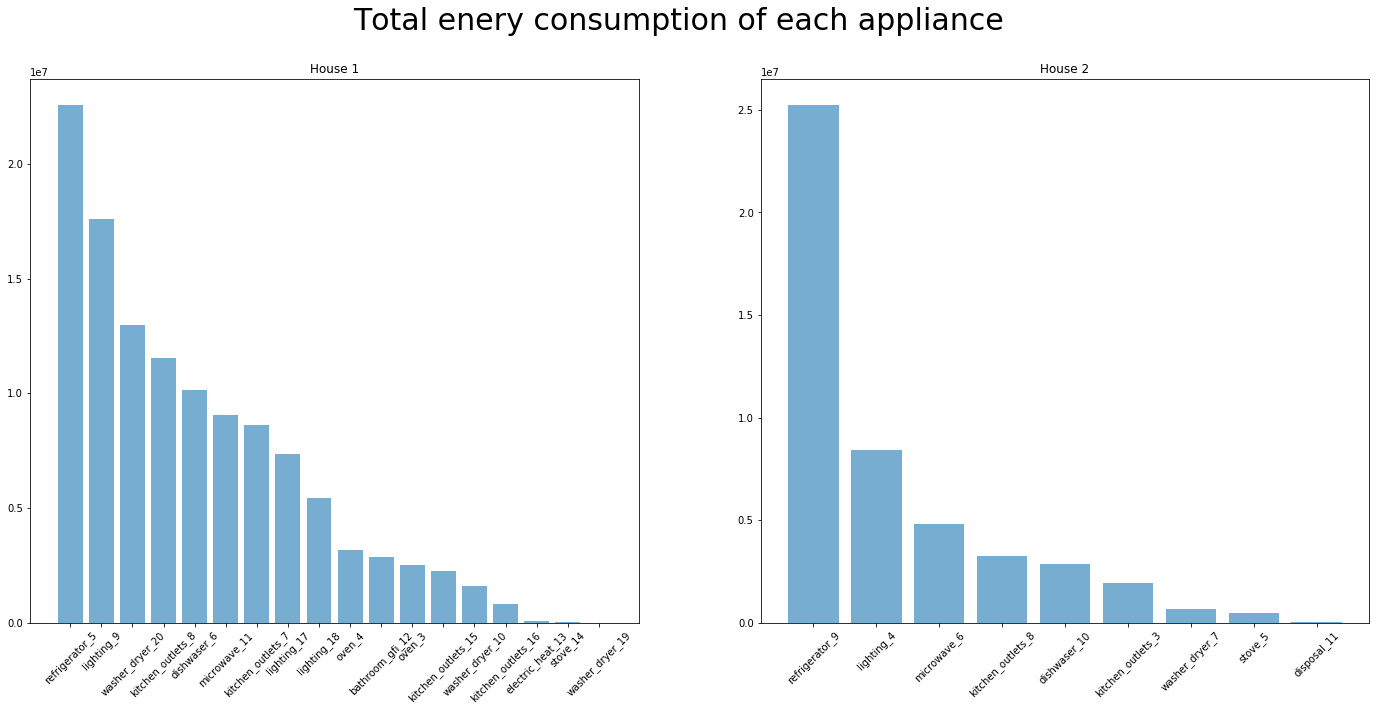

In [8]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(1,2,figsize=(24, 10))
plt.suptitle('Total enery consumption of each appliance', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0].bar(y_pos1, cons1.values,  alpha=0.6) 
plt.sca(axes[0])
plt.xticks(y_pos1, app1, rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[1].bar(y_pos2, cons2.values, alpha=0.6)
plt.sca(axes[1])
plt.xticks(y_pos2, app2, rotation = 45)
plt.title('House 2')



### Train and test on house 1 - Decision tree regression

In [9]:
# Separate house 1 data into train, validation and test data
df1_train = df[1].ix[:dates[1][10]]
df1_val = df[1].ix[dates[1][11]:dates[1][16]]
df1_test = df[1].ix[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

('df_train.shape: ', (214816, 20))
('df_val.shape: ', (104875, 20))
('df_test.shape: ', (87057, 20))


In [10]:
np.savetxt("Decision tree-train.txt",np.array(df1_train))
np.savetxt("Decision tree-valid.txt",np.array(df1_val))
np.savetxt("Decision tree-test.txt",np.array(df1_test))

In [11]:
# Using mains_1, mains_2 to predict refrigerator
X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['refrigerator_5'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['refrigerator_5'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['refrigerator_5'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

np.savetxt("Decision tree-Xtrain.txt",np.array(df1_train[['mains_1','mains_2']].values))
np.savetxt("Decision tree-Ytrain.txt",np.array(df1_train['refrigerator_5'].values))
np.savetxt("Decision tree-Xvalid.txt",np.array(df1_val[['mains_1','mains_2']].values))
np.savetxt("Decision tree-Yvalid.txt",np.array(df1_val['refrigerator_5'].values))
np.savetxt("Decision tree-Xtest.txt",np.array(df1_test[['mains_1','mains_2']].values))
np.savetxt("Decision tree-Ytest.txt",np.array(df1_test['refrigerator_5'].values))

((214816, 2), (214816,), (104875, 2), (104875,), (87057, 2), (87057,))


In [ ]:
# Using decision tree regression, here we use validation data to turn the min_samples_split parameter
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

min_samples_split=np.arange(2, 400, 10)
from sklearn.svm import SVR
def tree_reg(X_train, y_train, X_val, y_val):
    clfs = []
    losses = []
    #start = time.time()
    clf = SVR(C=1.0, epsilon=0.2)
    clf.fit(X_train, y_train)
    y_predict_val = clf.predict(X_val)
    clfs.append(clf)
    losses.append( mse_loss(y_predict_val, y_val) )
    #print('Trainning time: ', time.time() - start)
    return clfs, losses
tree_clfs_1, tree_losses_1 = tree_reg(X_train1, y_train1, X_val1, y_val1)

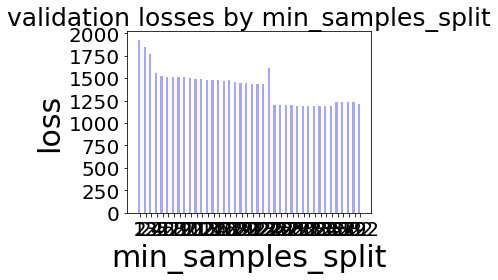

In [65]:
print(tree_clfs_1)
print(tree_losses_1)

In [66]:
y_test_predict_1 = tree_clfs_1.predict(X_test1)
mse_tree_1 = mse_loss(y_test_predict_1, y_test1)
mae_tree_1 = mae_loss(y_test_predict_1, y_test1)
print('Mean square error on test set: ', mse_tree_1)
print('Mean absolute error on the test set: ', mae_tree_1)

('Mean square error on test set: ', 1636.3664965623984)
('Mean absolute error on the test set: ', 12.69569809210917)


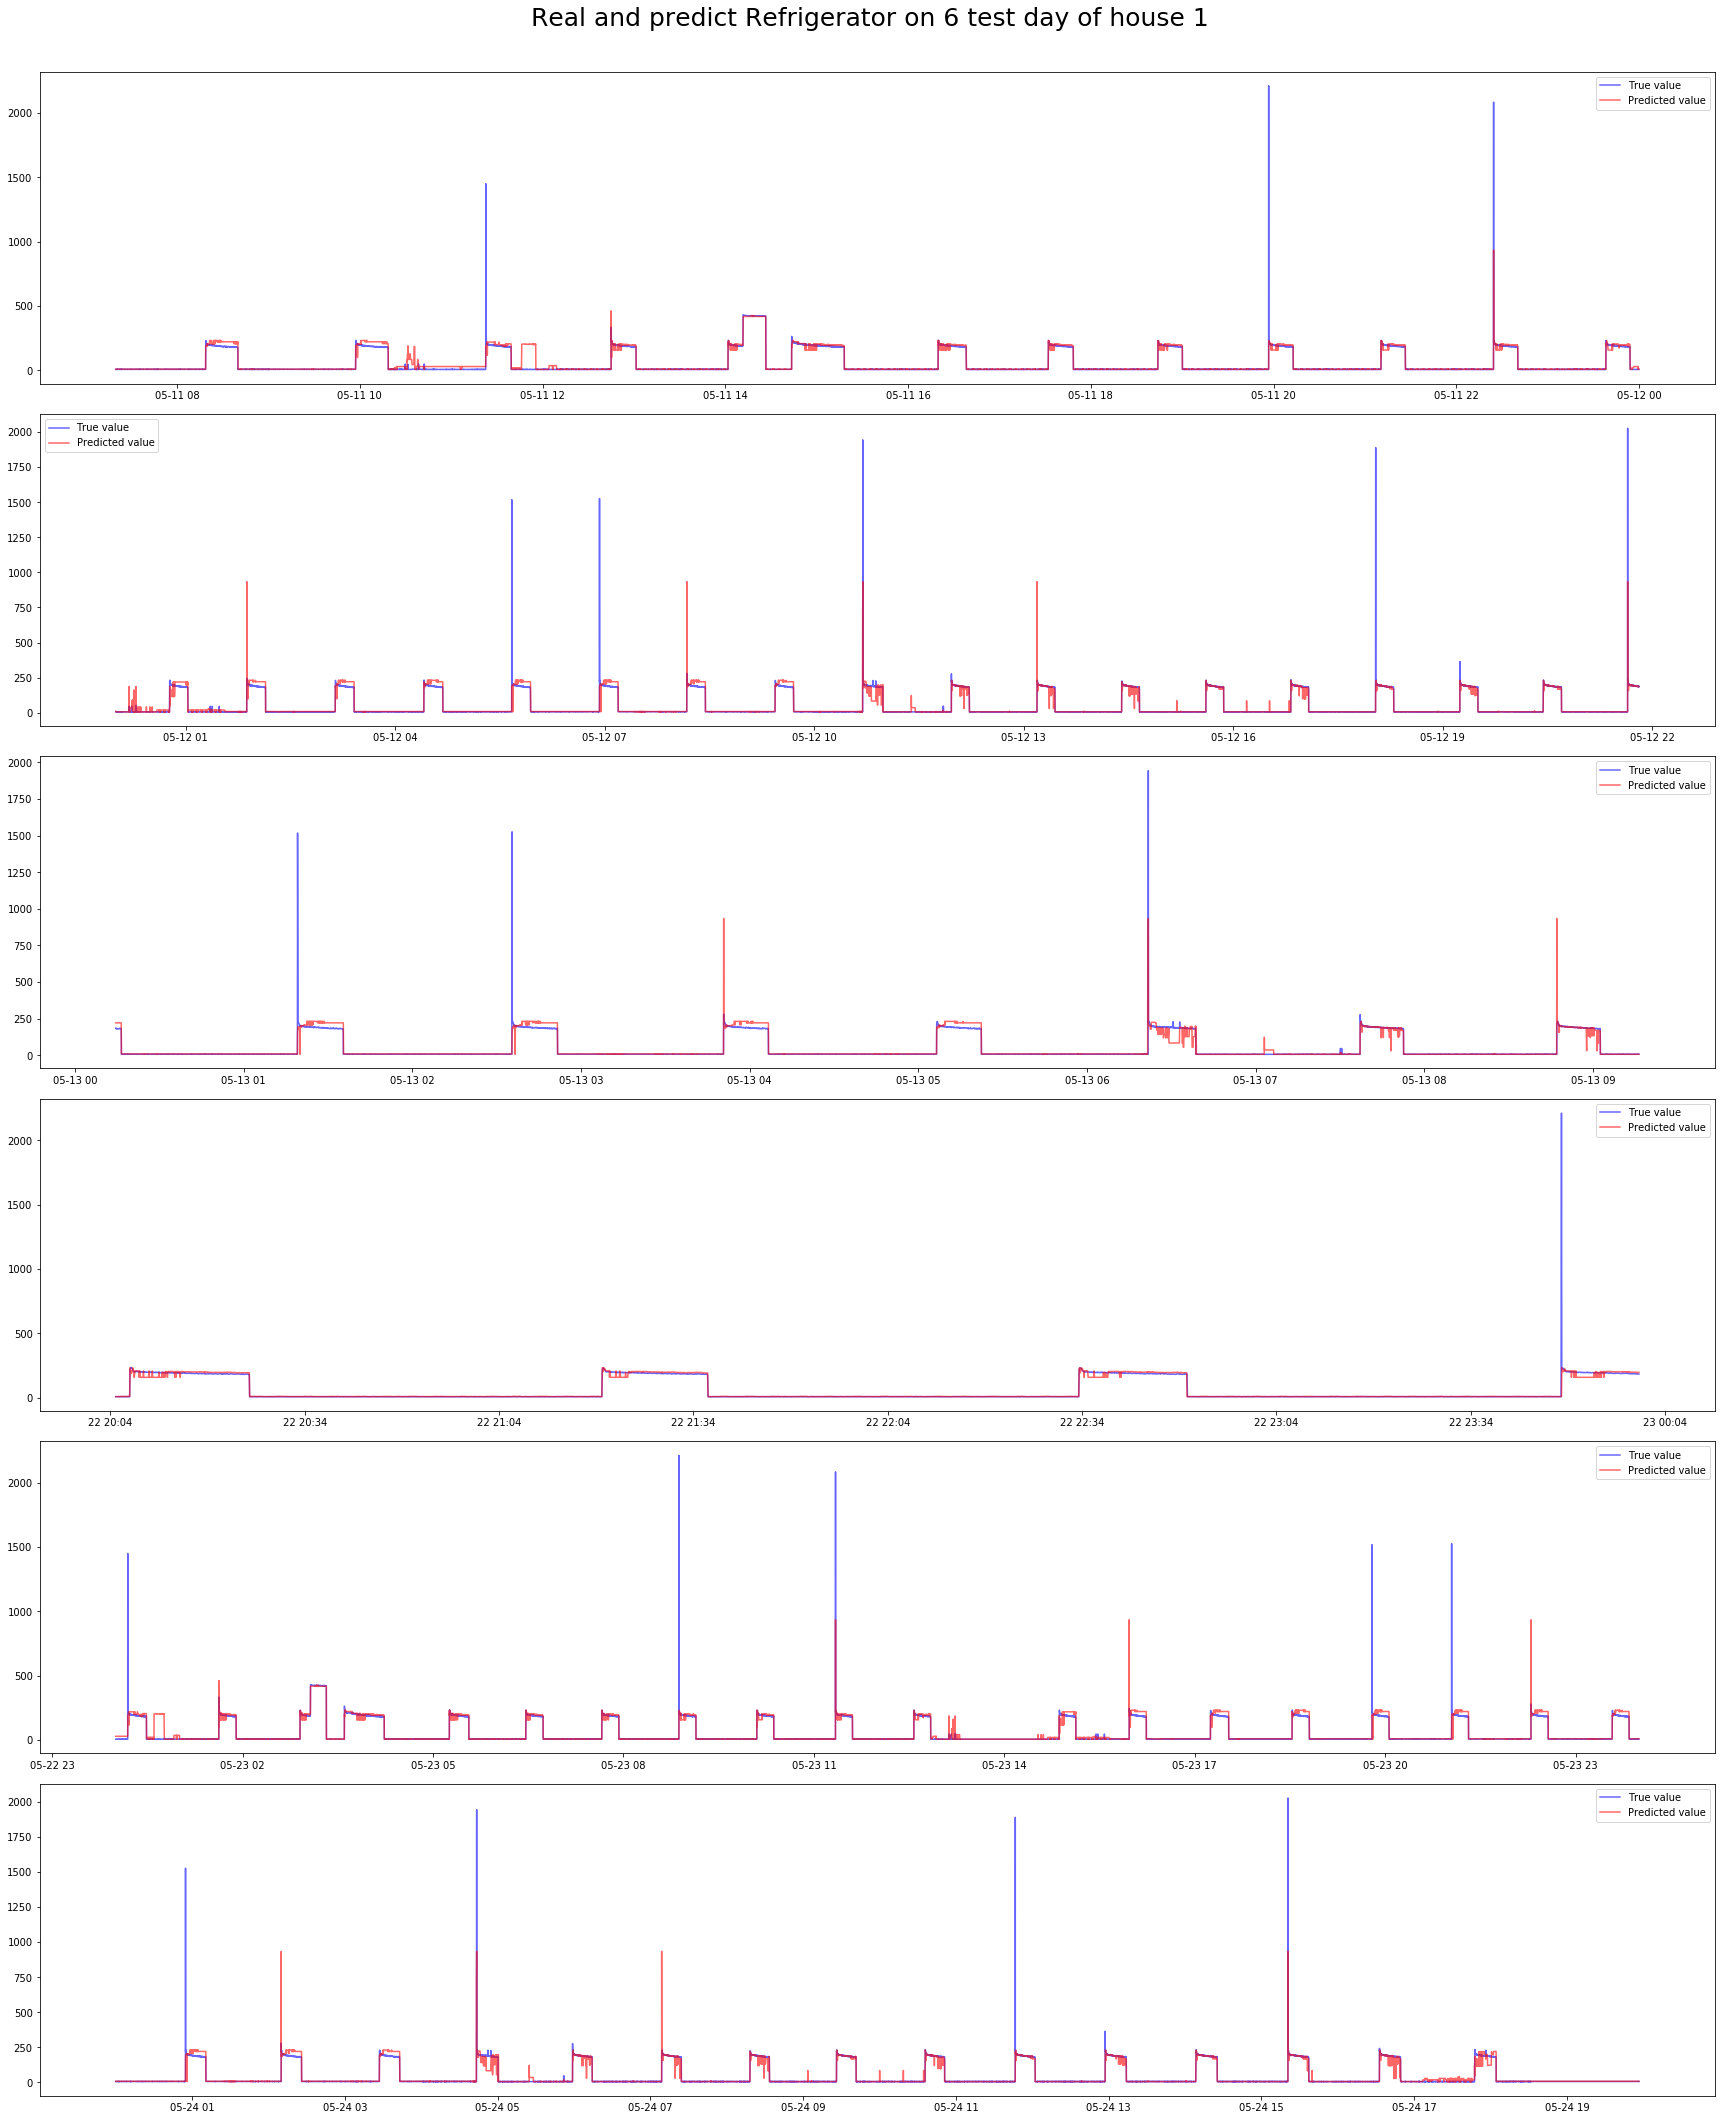

In [67]:
# Plot real and predict refrigerator consumption on six days of test data
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.ix[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)


plot_each_app(df1_test, dates[1][17:], y_test_predict_1, y_test1, 'Real and predict Refrigerator on 6 test day of house 1')

#### Using decision tree model we have just trained on house 1 to predict refrigerator consumtion on house 2

In [12]:
X_2 = df[2][['mains_2','mains_1']].values
y_2 = df[2]['refrigerator_9'].values
print(X_2.shape, y_2.shape)
np.savetxt("Decision tree-house2-Xtrain.txt",np.array(df[2][['mains_2','mains_1']].values))
np.savetxt("Decision tree-house2-Ytrain.txt",np.array(df[2]['refrigerator_9'].values))

((316840, 2), (316840,))


In [13]:
y_predict_2 = tree_clfs_1.predict(X_2)
mse_tree_2 = mse_loss(y_predict_2, y_2)
mae_tree_2 = mae_loss(y_predict_2, y_2)
print('Mean square error on test set: ', mse_tree_2)
print('Mean absolute error on the test set: ', mae_tree_2)

NameError: name 'tree_clfs_1' is not defined

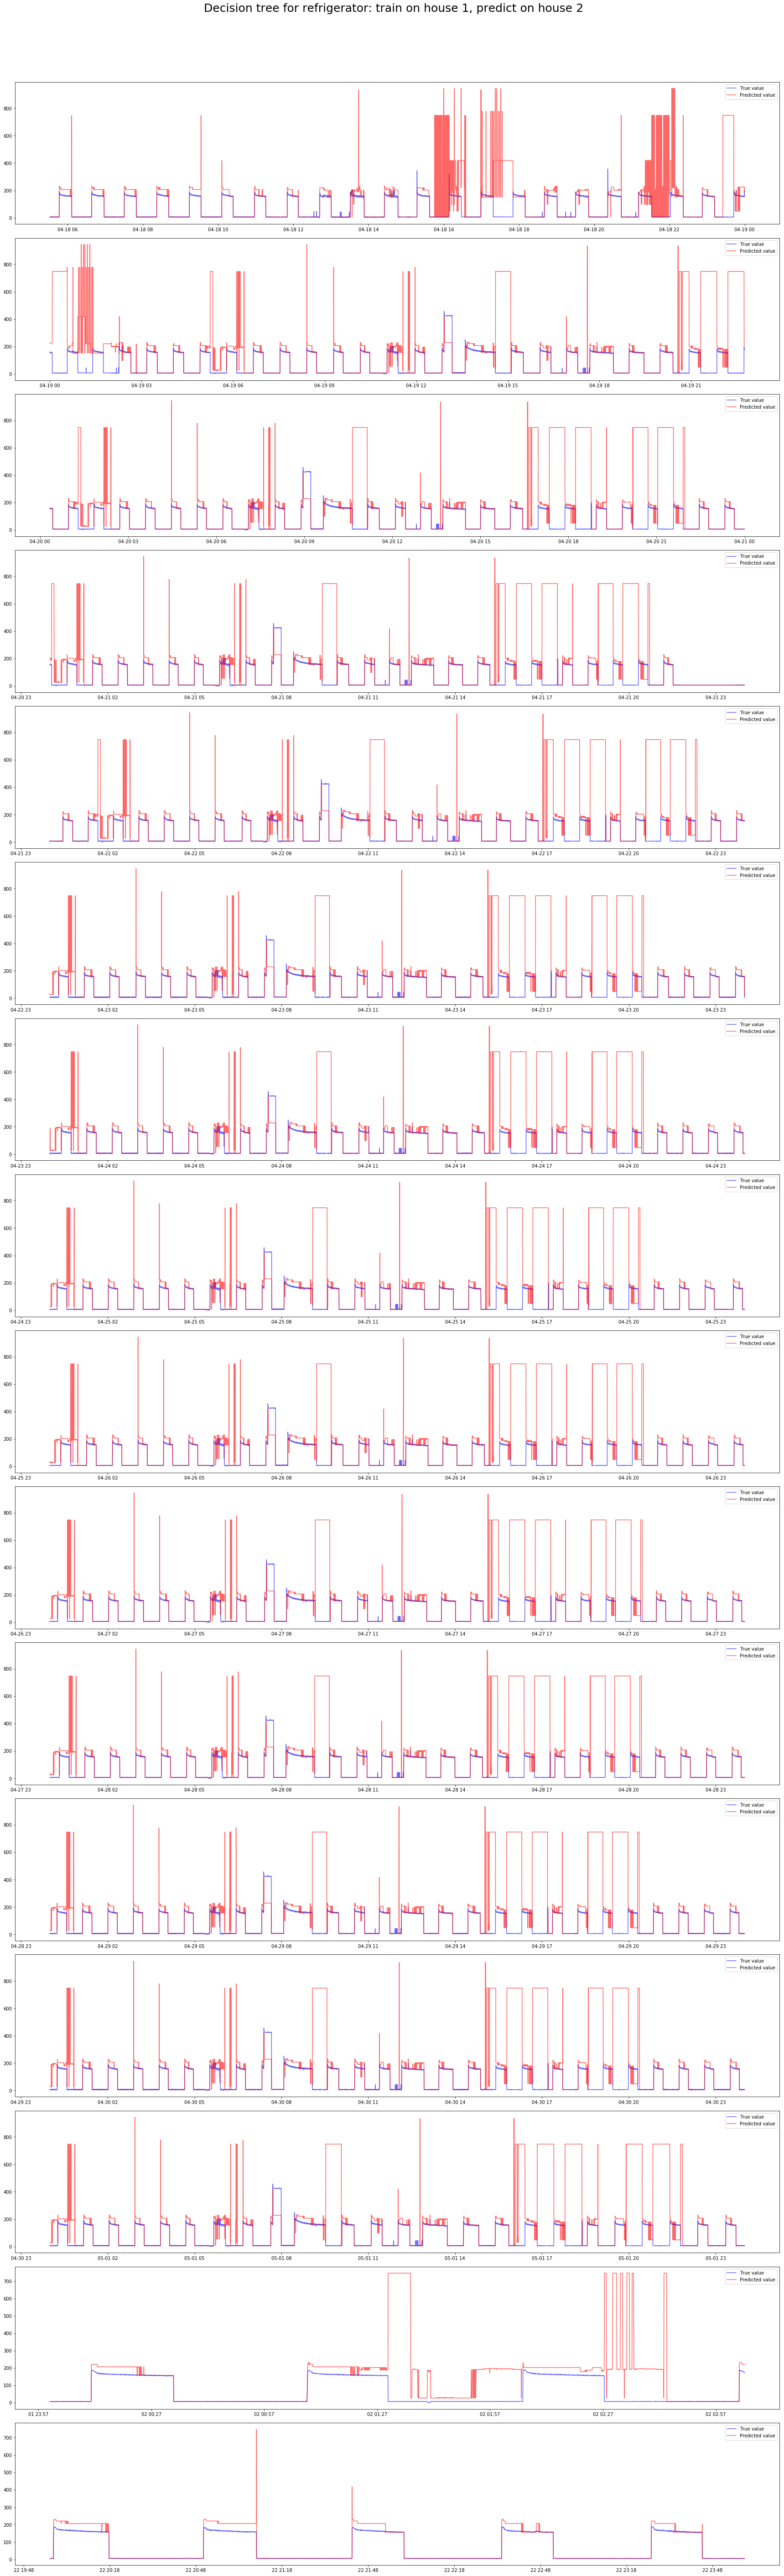

In [30]:
plot_each_app(df[2], dates[2], y_predict_2, y_2, 'Decision tree for refrigerator: train on house 1, predict on house 2')

#### Now, we will try decision tree method for other appliances in house 1

In [14]:
# List of other appliances in house 1:
appliances = list(df[1].columns.values[2:])
appliances.pop(2)
print(appliances)

['oven_3', 'oven_4', 'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9', 'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12', 'electric_heat_13', 'stove_14', 'kitchen_outlets_15', 'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19', 'washer_dryer_20']


In [72]:
# using decision tree model on other appliances
def tree_reg_mult_apps():
    #start = time.time()
    min_samples_split=np.arange(2, 400, 10)
    pred = {}
    for app in appliances:
        list_clfs = []
        losses = []
        y_train = df1_train[app].values
        y_val = df1_val[app].values
        clf = SVR(C=1.0, epsilon=0.2)
        clf.fit(X_train1, y_train)
        y_predict_val = clf.predict(X_val1)
        list_clfs.append(clf)
        losses.append( mse_loss(y_predict_val, y_val) )
        pred[app] = list_clfs[0].predict(X_test1)
    #print('Trainning time: ', time.time() - start)
    return pred

mul_pred = tree_reg_mult_apps()

In [73]:
def error_mul_app(mul_pred):
    mse_losses = {}
    mae_losses = {}
    for app in appliances:
        mse_losses[app] = mse_loss(mul_pred[app], df1_test[app].values)
        mae_losses[app] = mae_loss(mul_pred[app], df1_test[app].values)
    return mse_losses, mae_losses

mul_mse_tree, mul_mae_tree = error_mul_app(mul_pred) 

In [74]:
for app in appliances:
    m = np.mean(df1_test[app].values)
    print('mean of {0}: {1:.2f} - mse: {2:.2f} - mae: {3:.2f}'.format(app, m ,mul_mse_tree[app], mul_mae_tree[app]))

mean of oven_3: 15.63 - mse: 18554.94 - mae: 11.28
mean of oven_4: 17.11 - mse: 7454.70 - mae: 4.92
mean of dishwaser_6: 25.35 - mse: 831.49 - mae: 3.38
mean of kitchen_outlets_7: 21.25 - mse: 4.54 - mae: 1.59
mean of kitchen_outlets_8: 27.71 - mse: 99.51 - mae: 3.43
mean of lighting_9: 28.29 - mse: 1574.78 - mae: 24.09
mean of washer_dryer_10: 3.07 - mse: 934.44 - mae: 2.44
mean of microwave_11: 18.92 - mse: 12442.92 - mae: 13.00
mean of bathroom_gfi_12: 6.73 - mse: 3471.07 - mae: 3.44
mean of electric_heat_13: 0.11 - mse: 0.53 - mae: 0.05
mean of stove_14: 0.10 - mse: 0.23 - mae: 0.04
mean of kitchen_outlets_15: 5.34 - mse: 832.75 - mae: 1.63
mean of kitchen_outlets_16: 1.93 - mse: 718.63 - mae: 0.65
mean of lighting_17: 18.97 - mse: 136.66 - mae: 3.18
mean of lighting_18: 15.68 - mse: 383.82 - mae: 13.12
mean of washer_dryer_19: 0.00 - mse: 0.00 - mae: 0.00
mean of washer_dryer_20: 27.54 - mse: 2087.60 - mae: 1.79


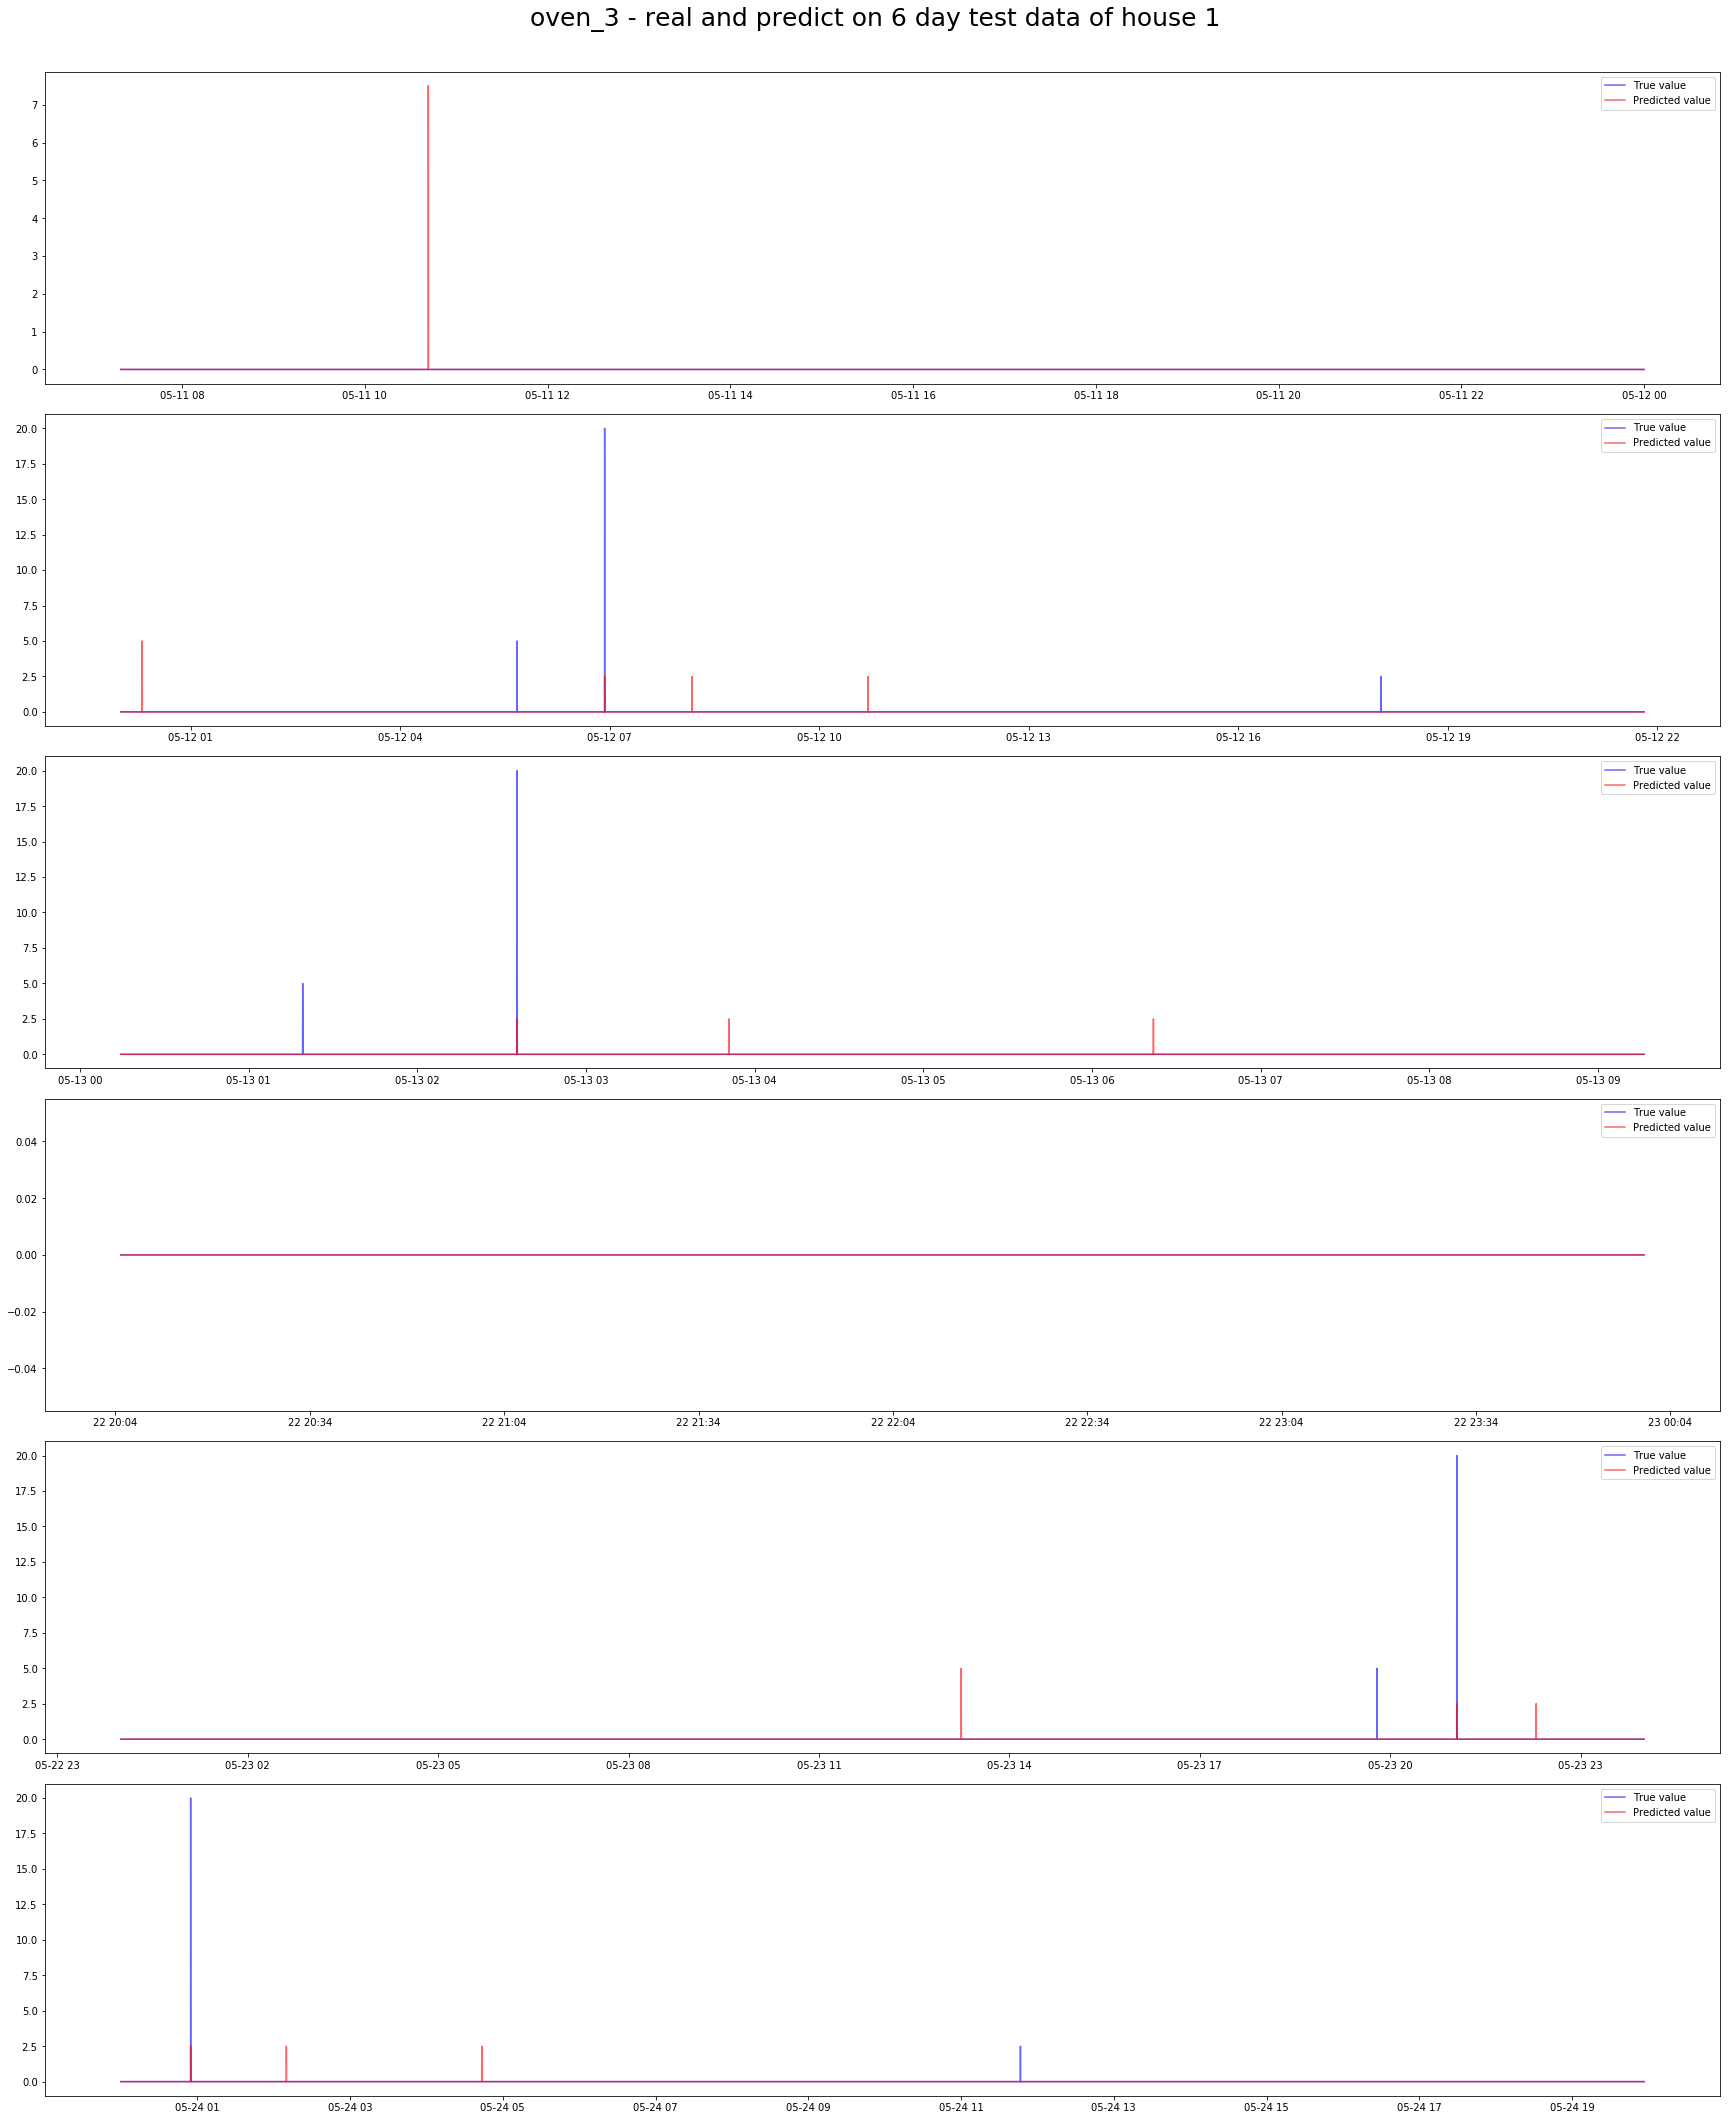

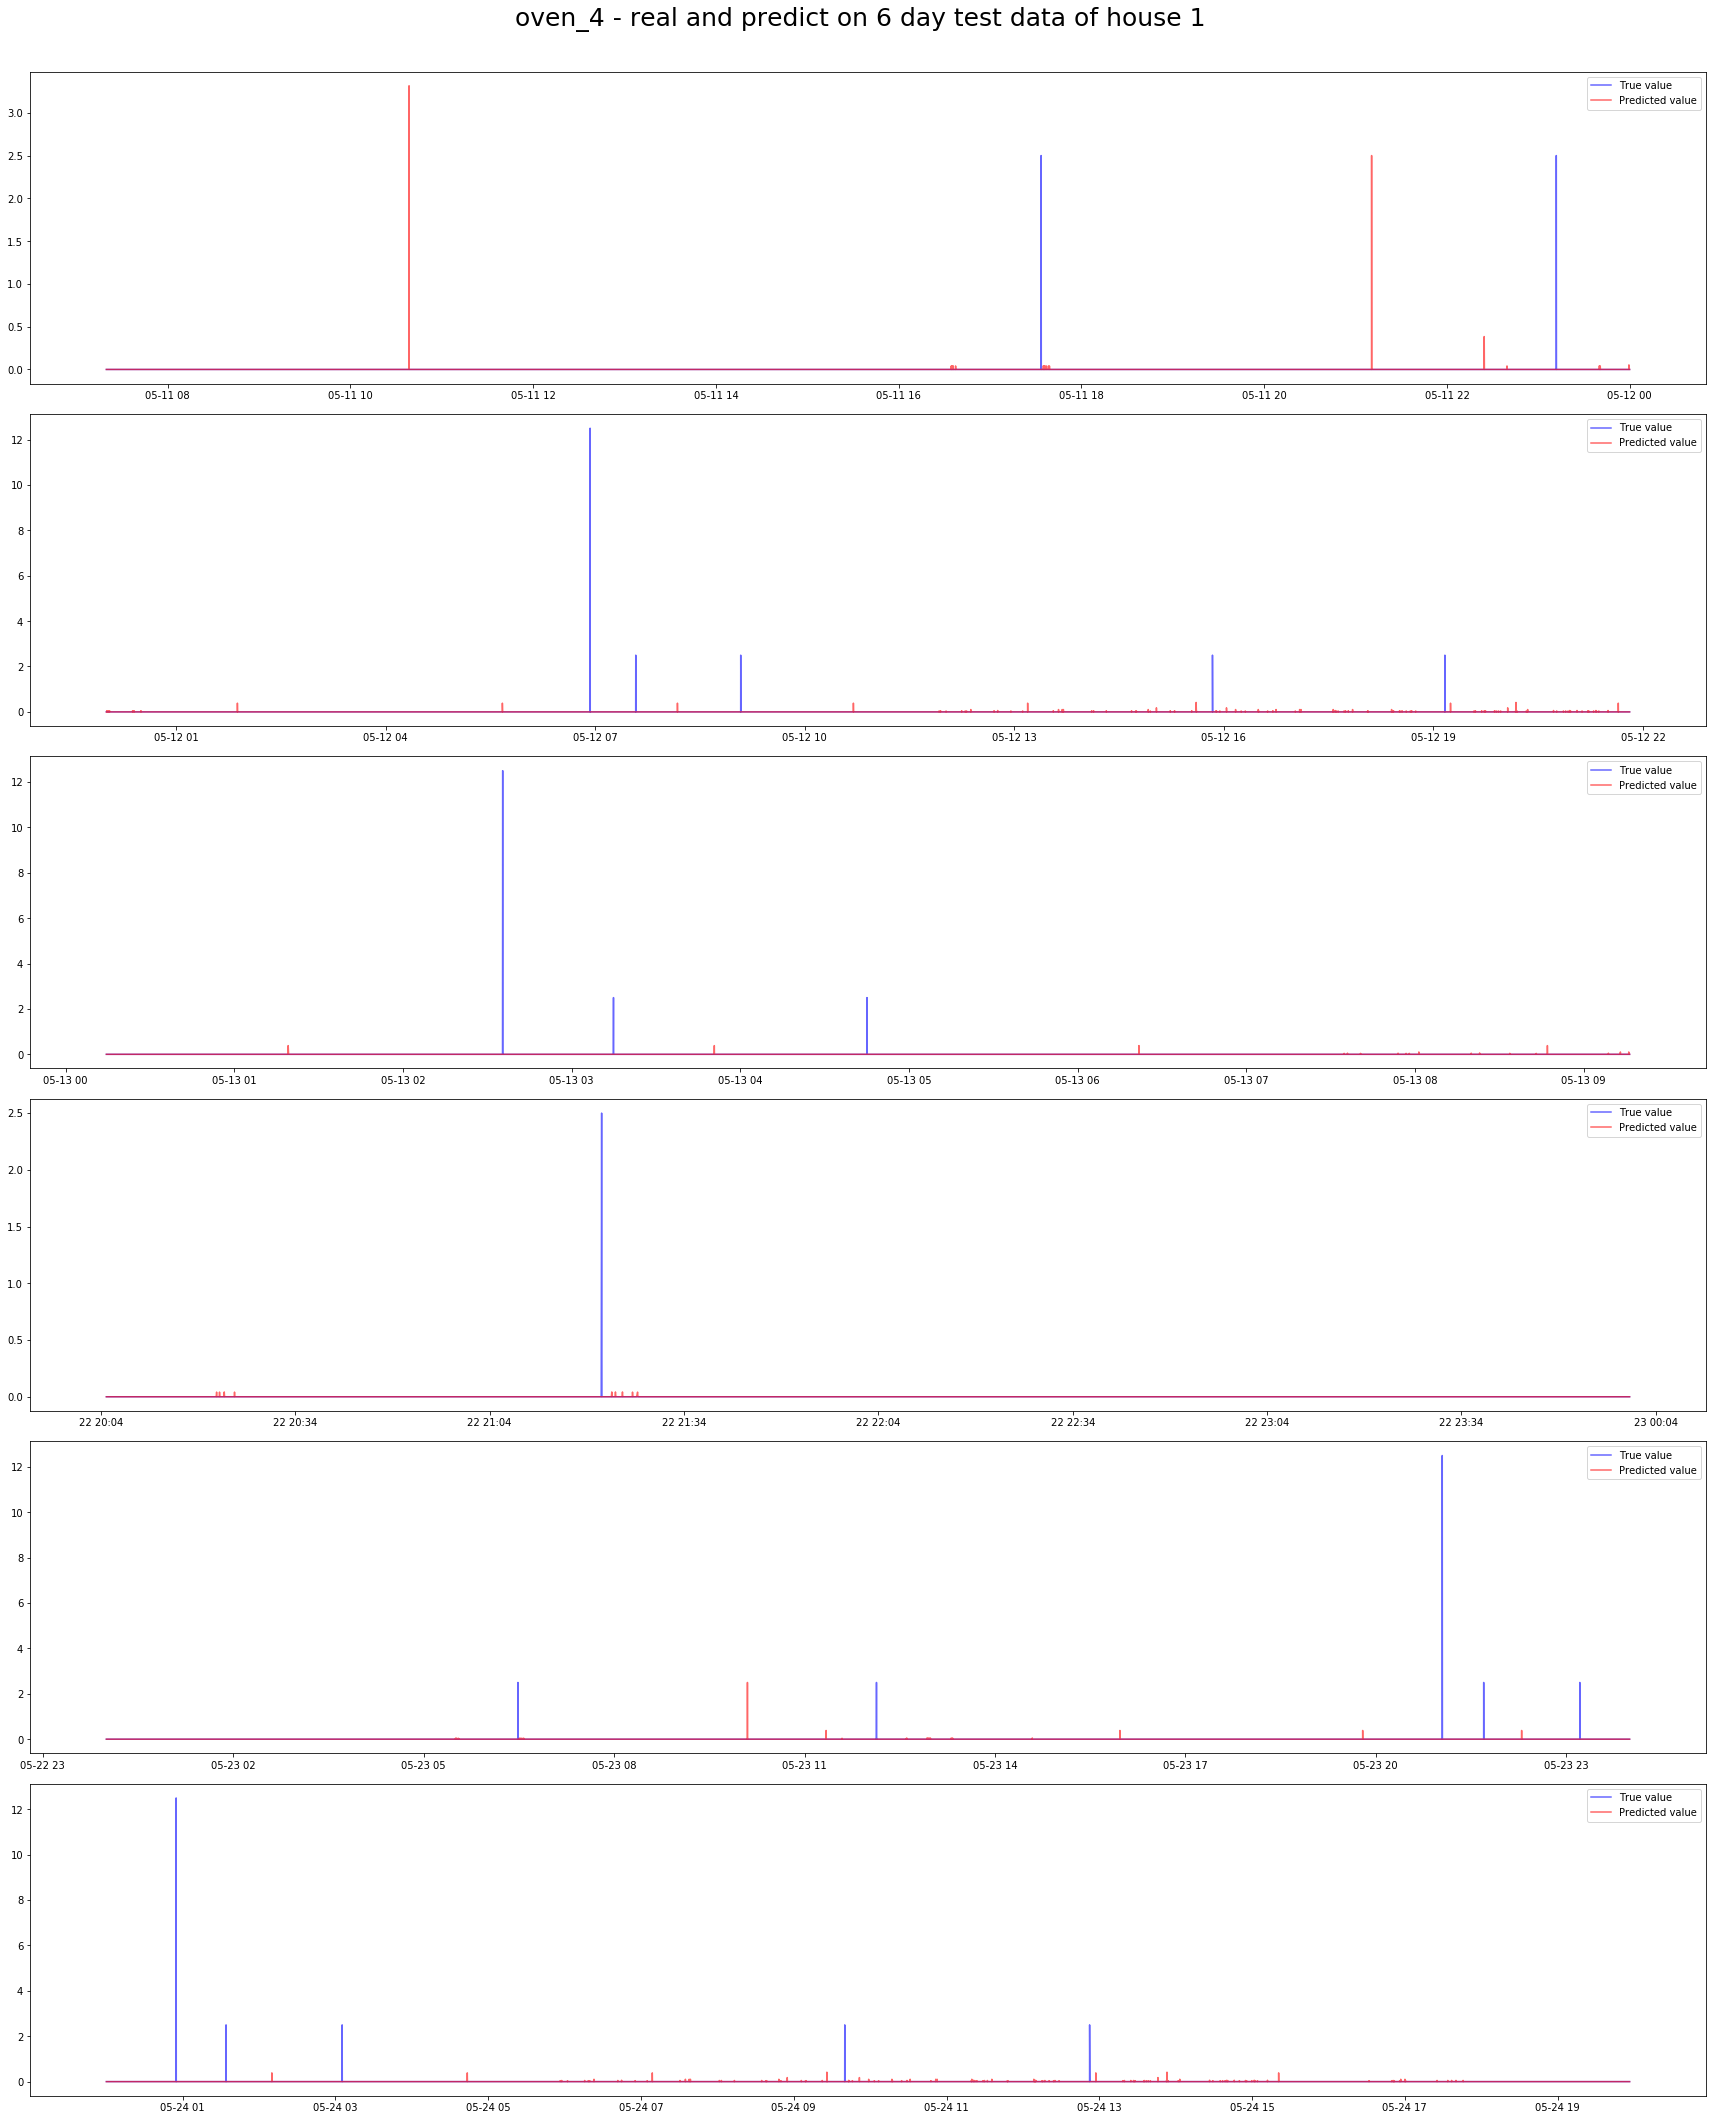

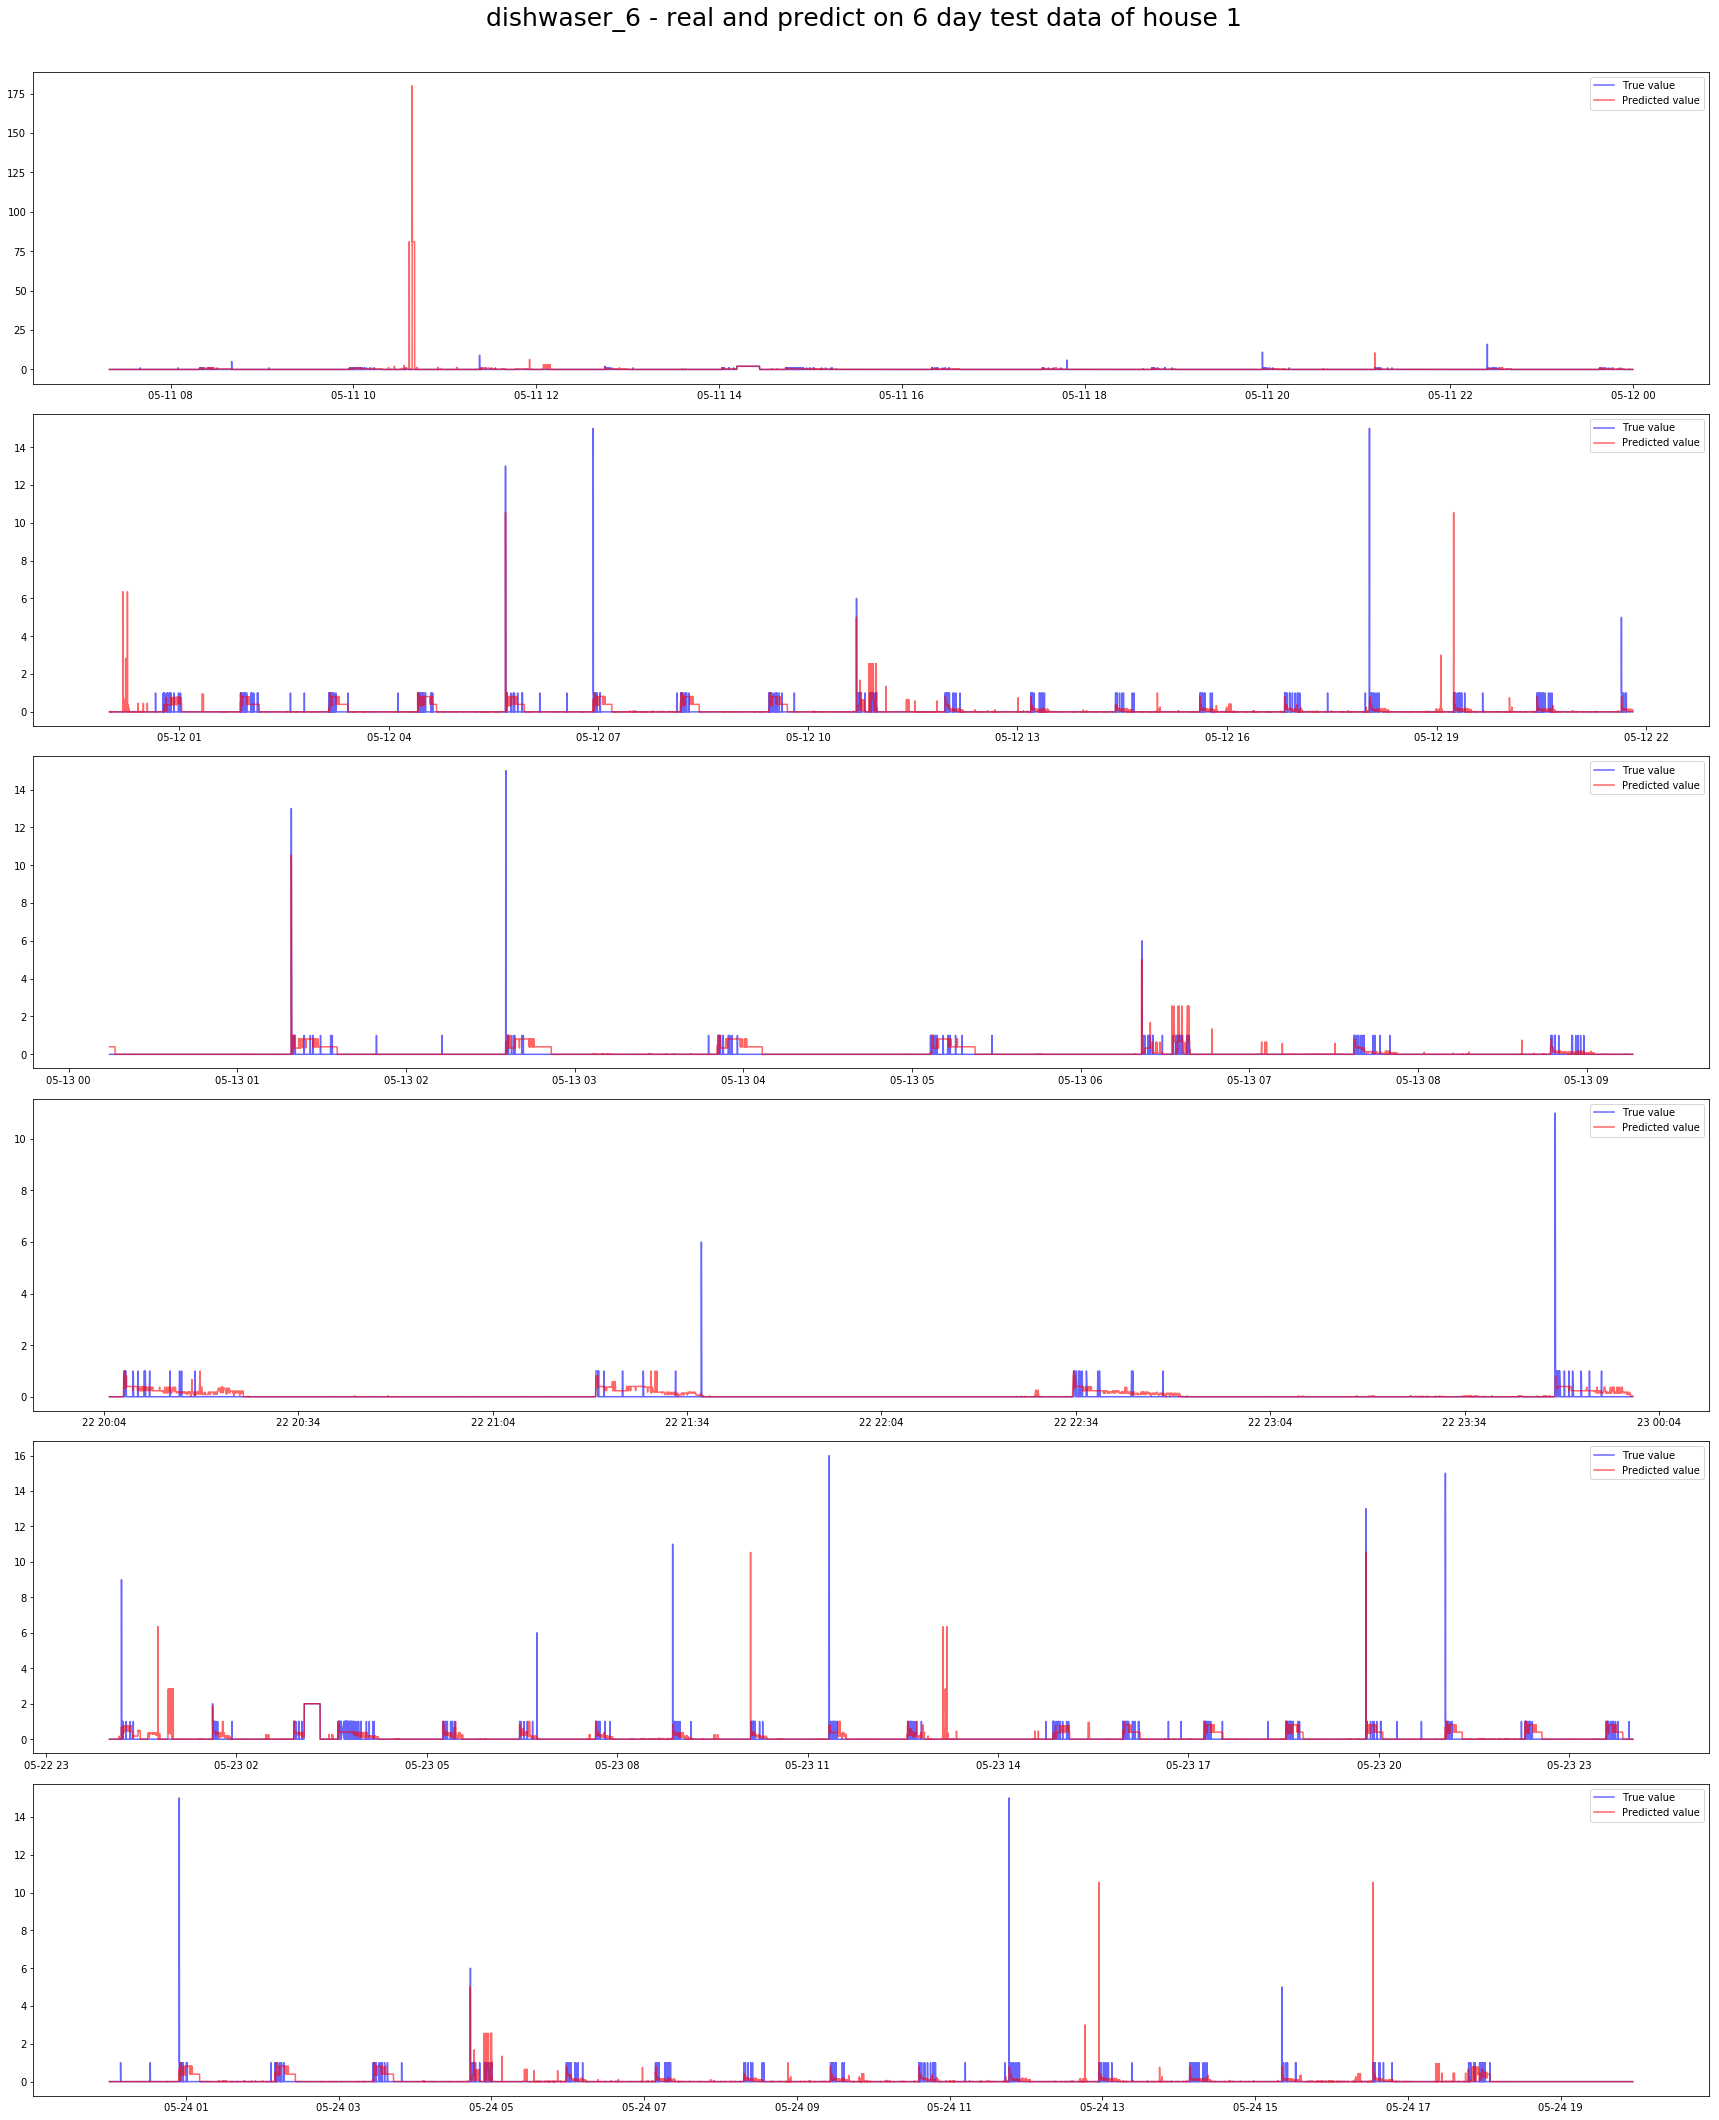

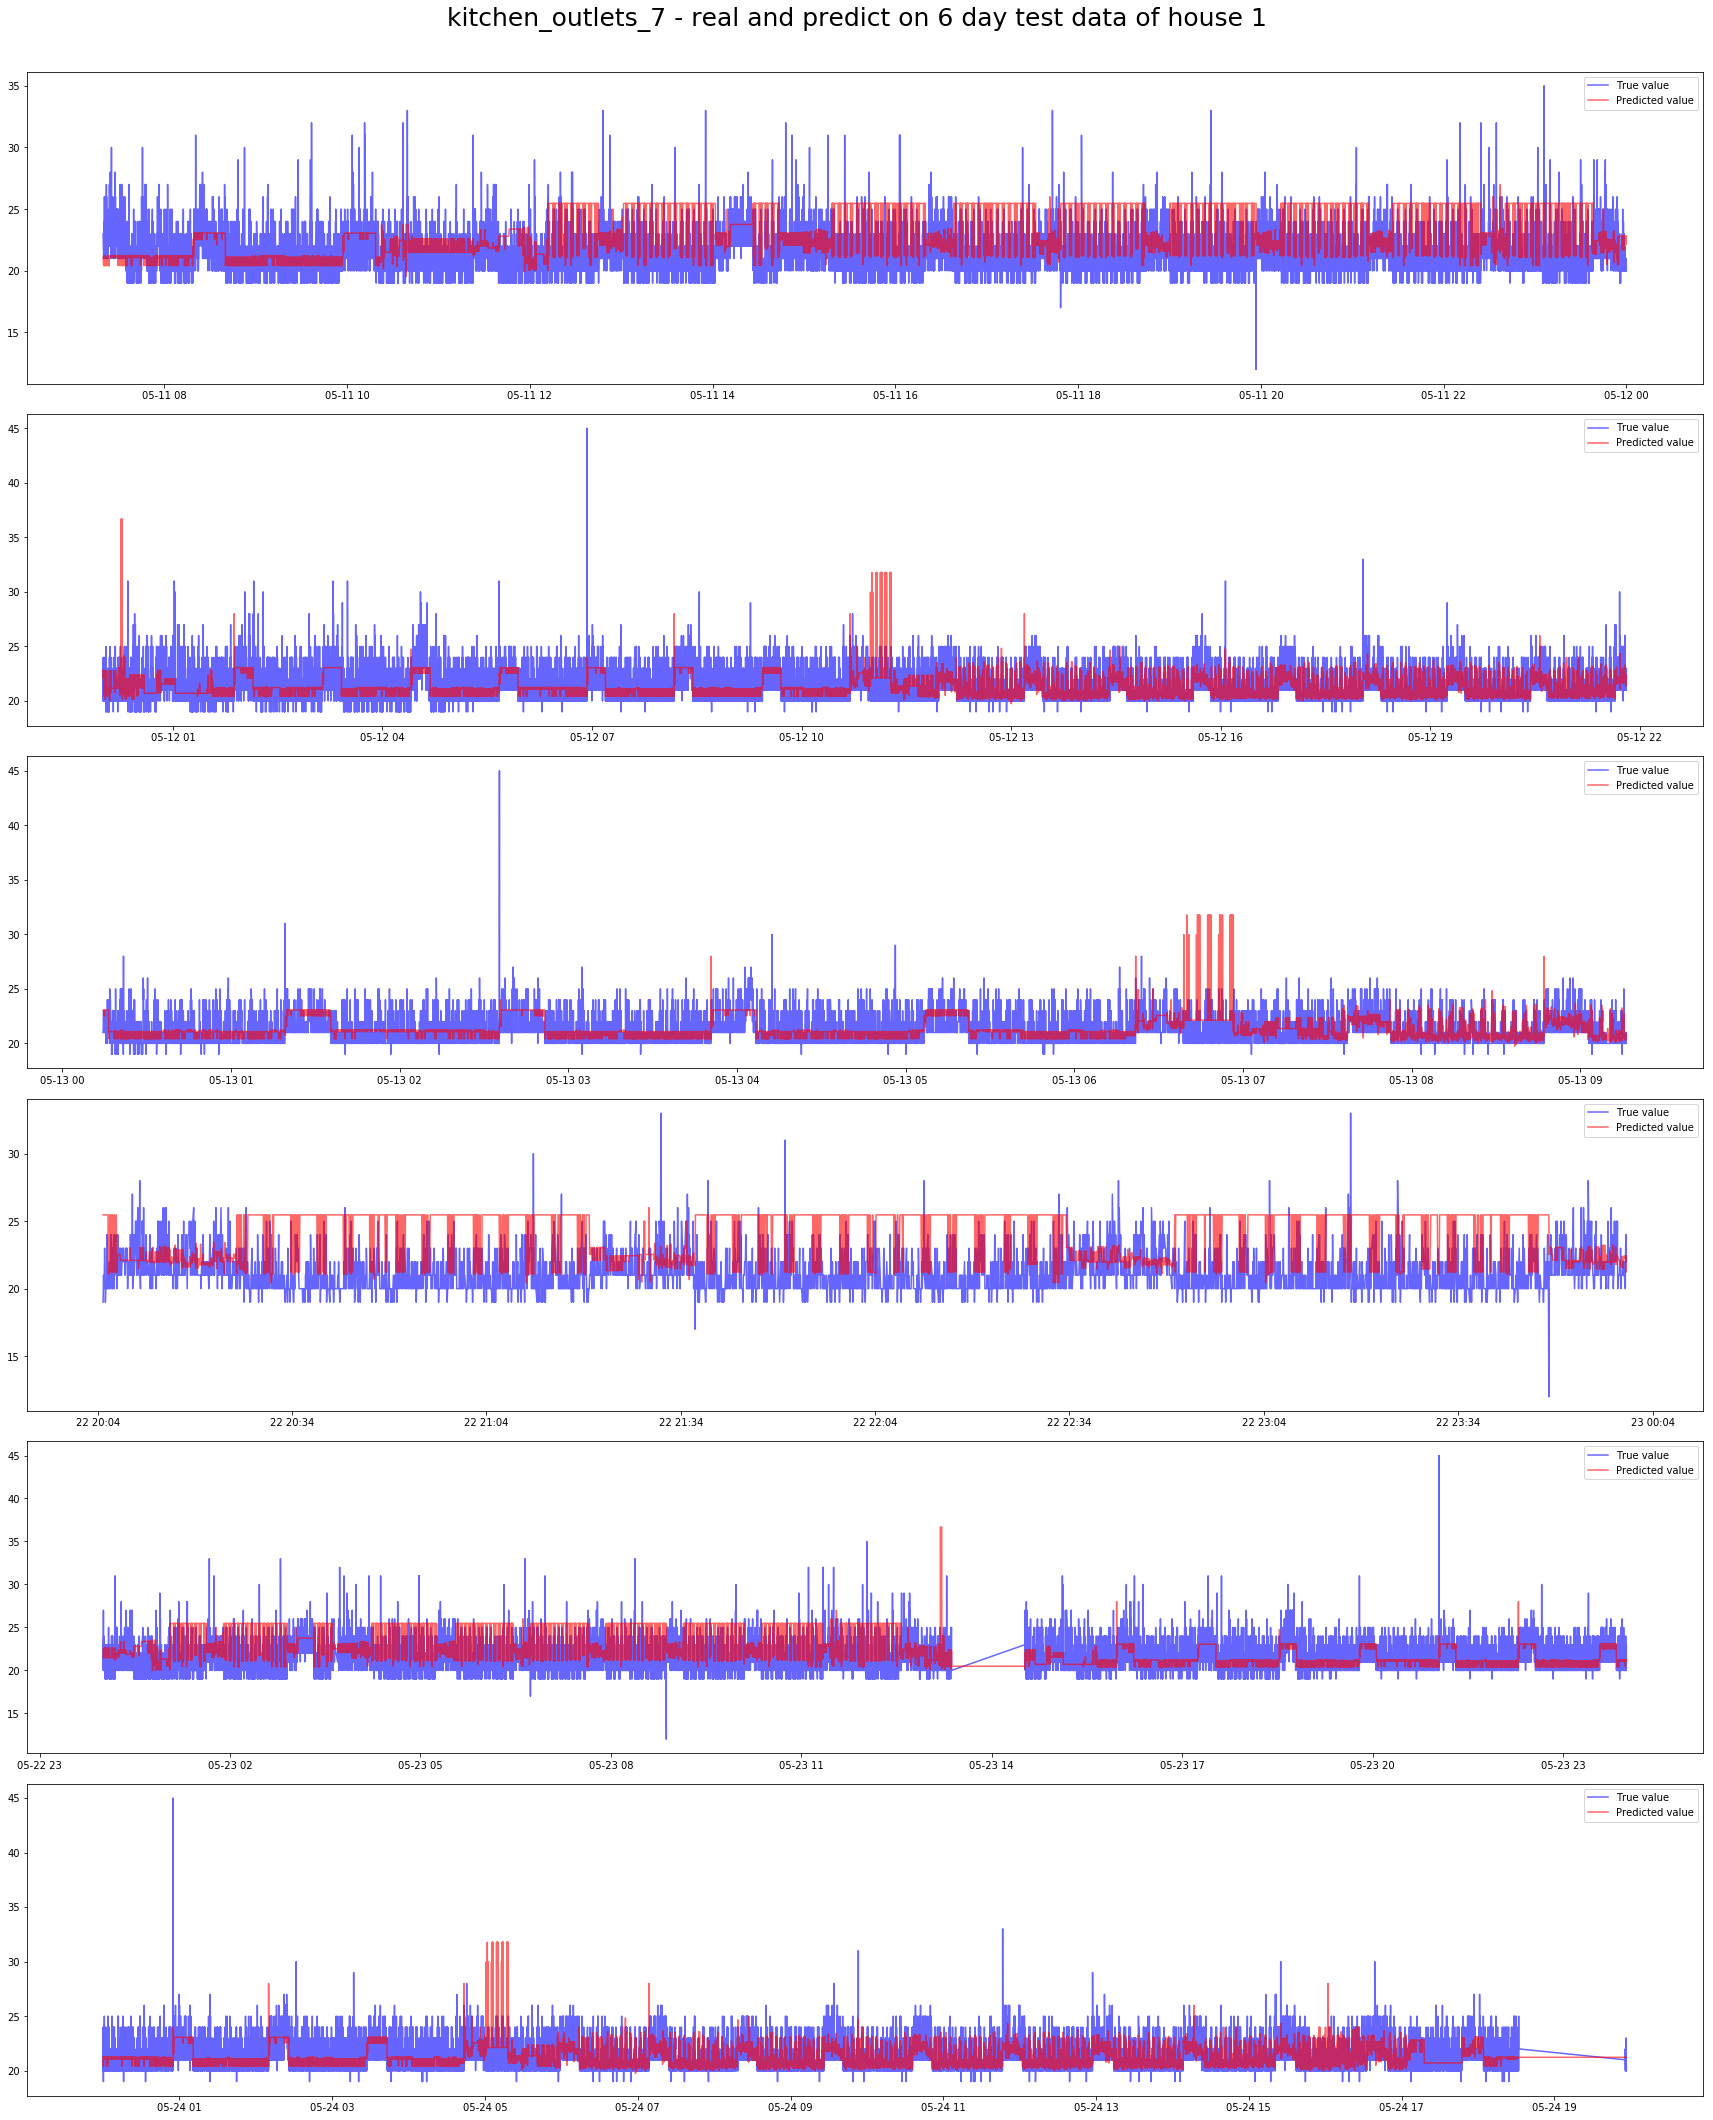

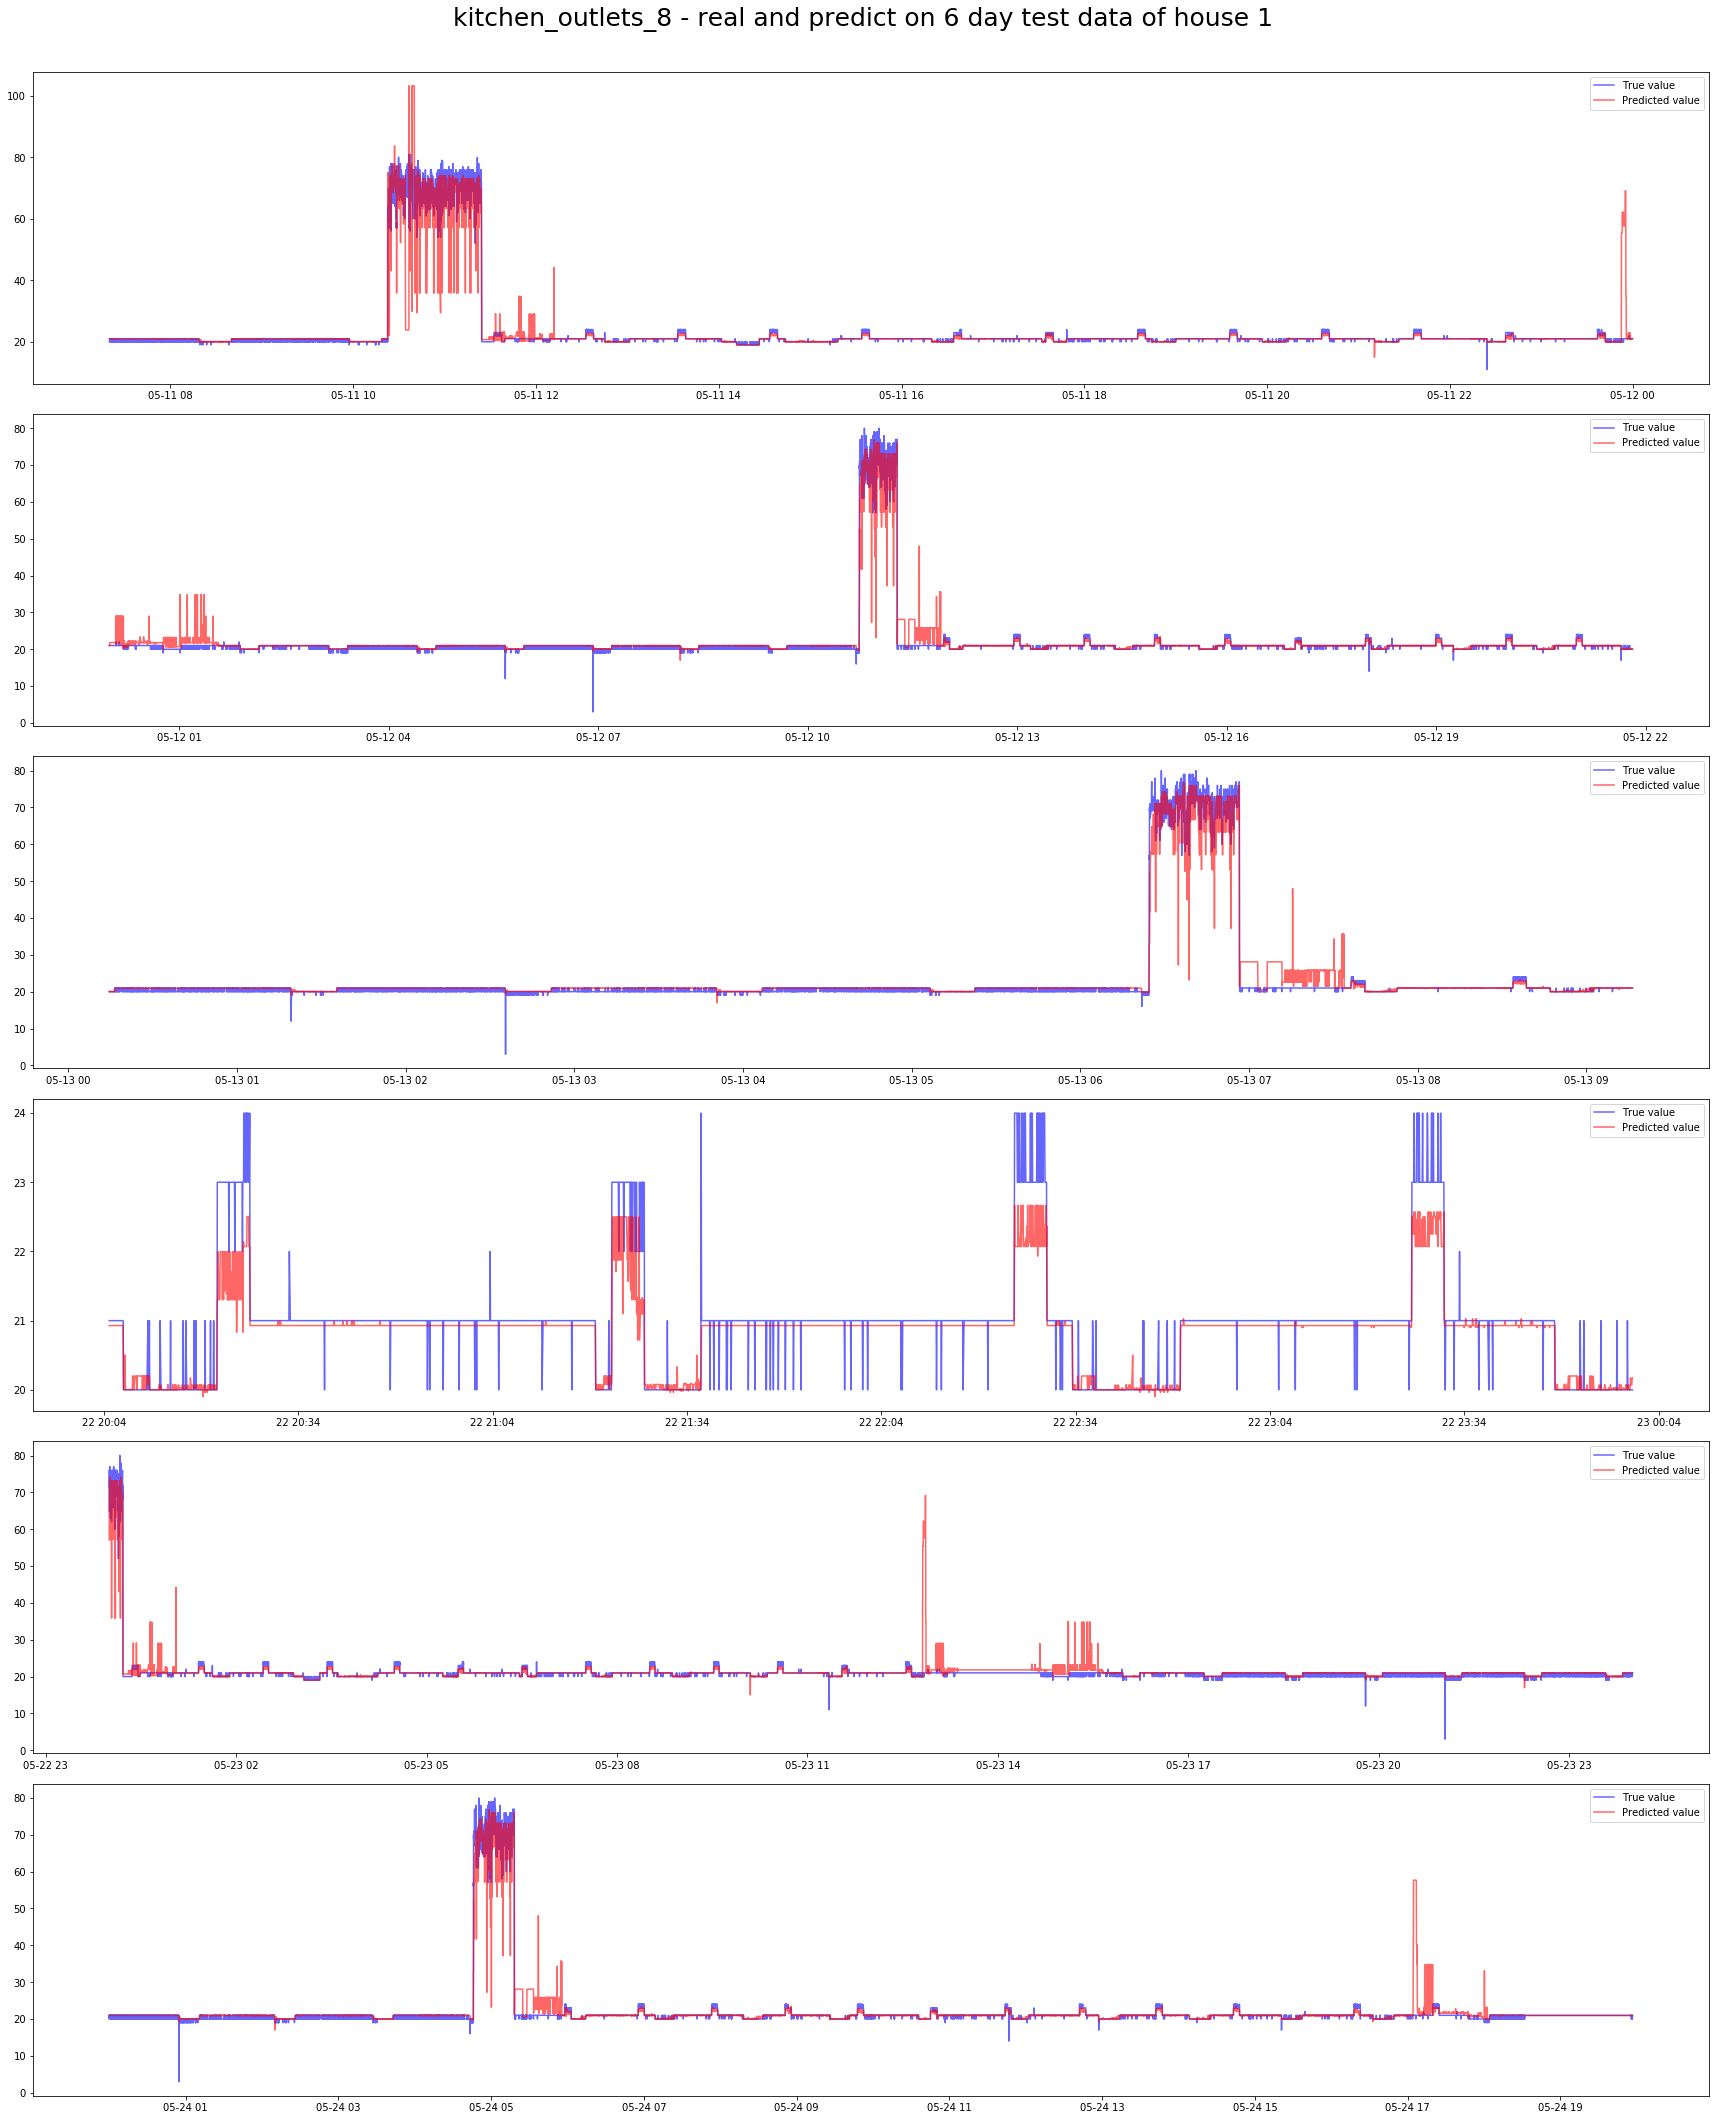

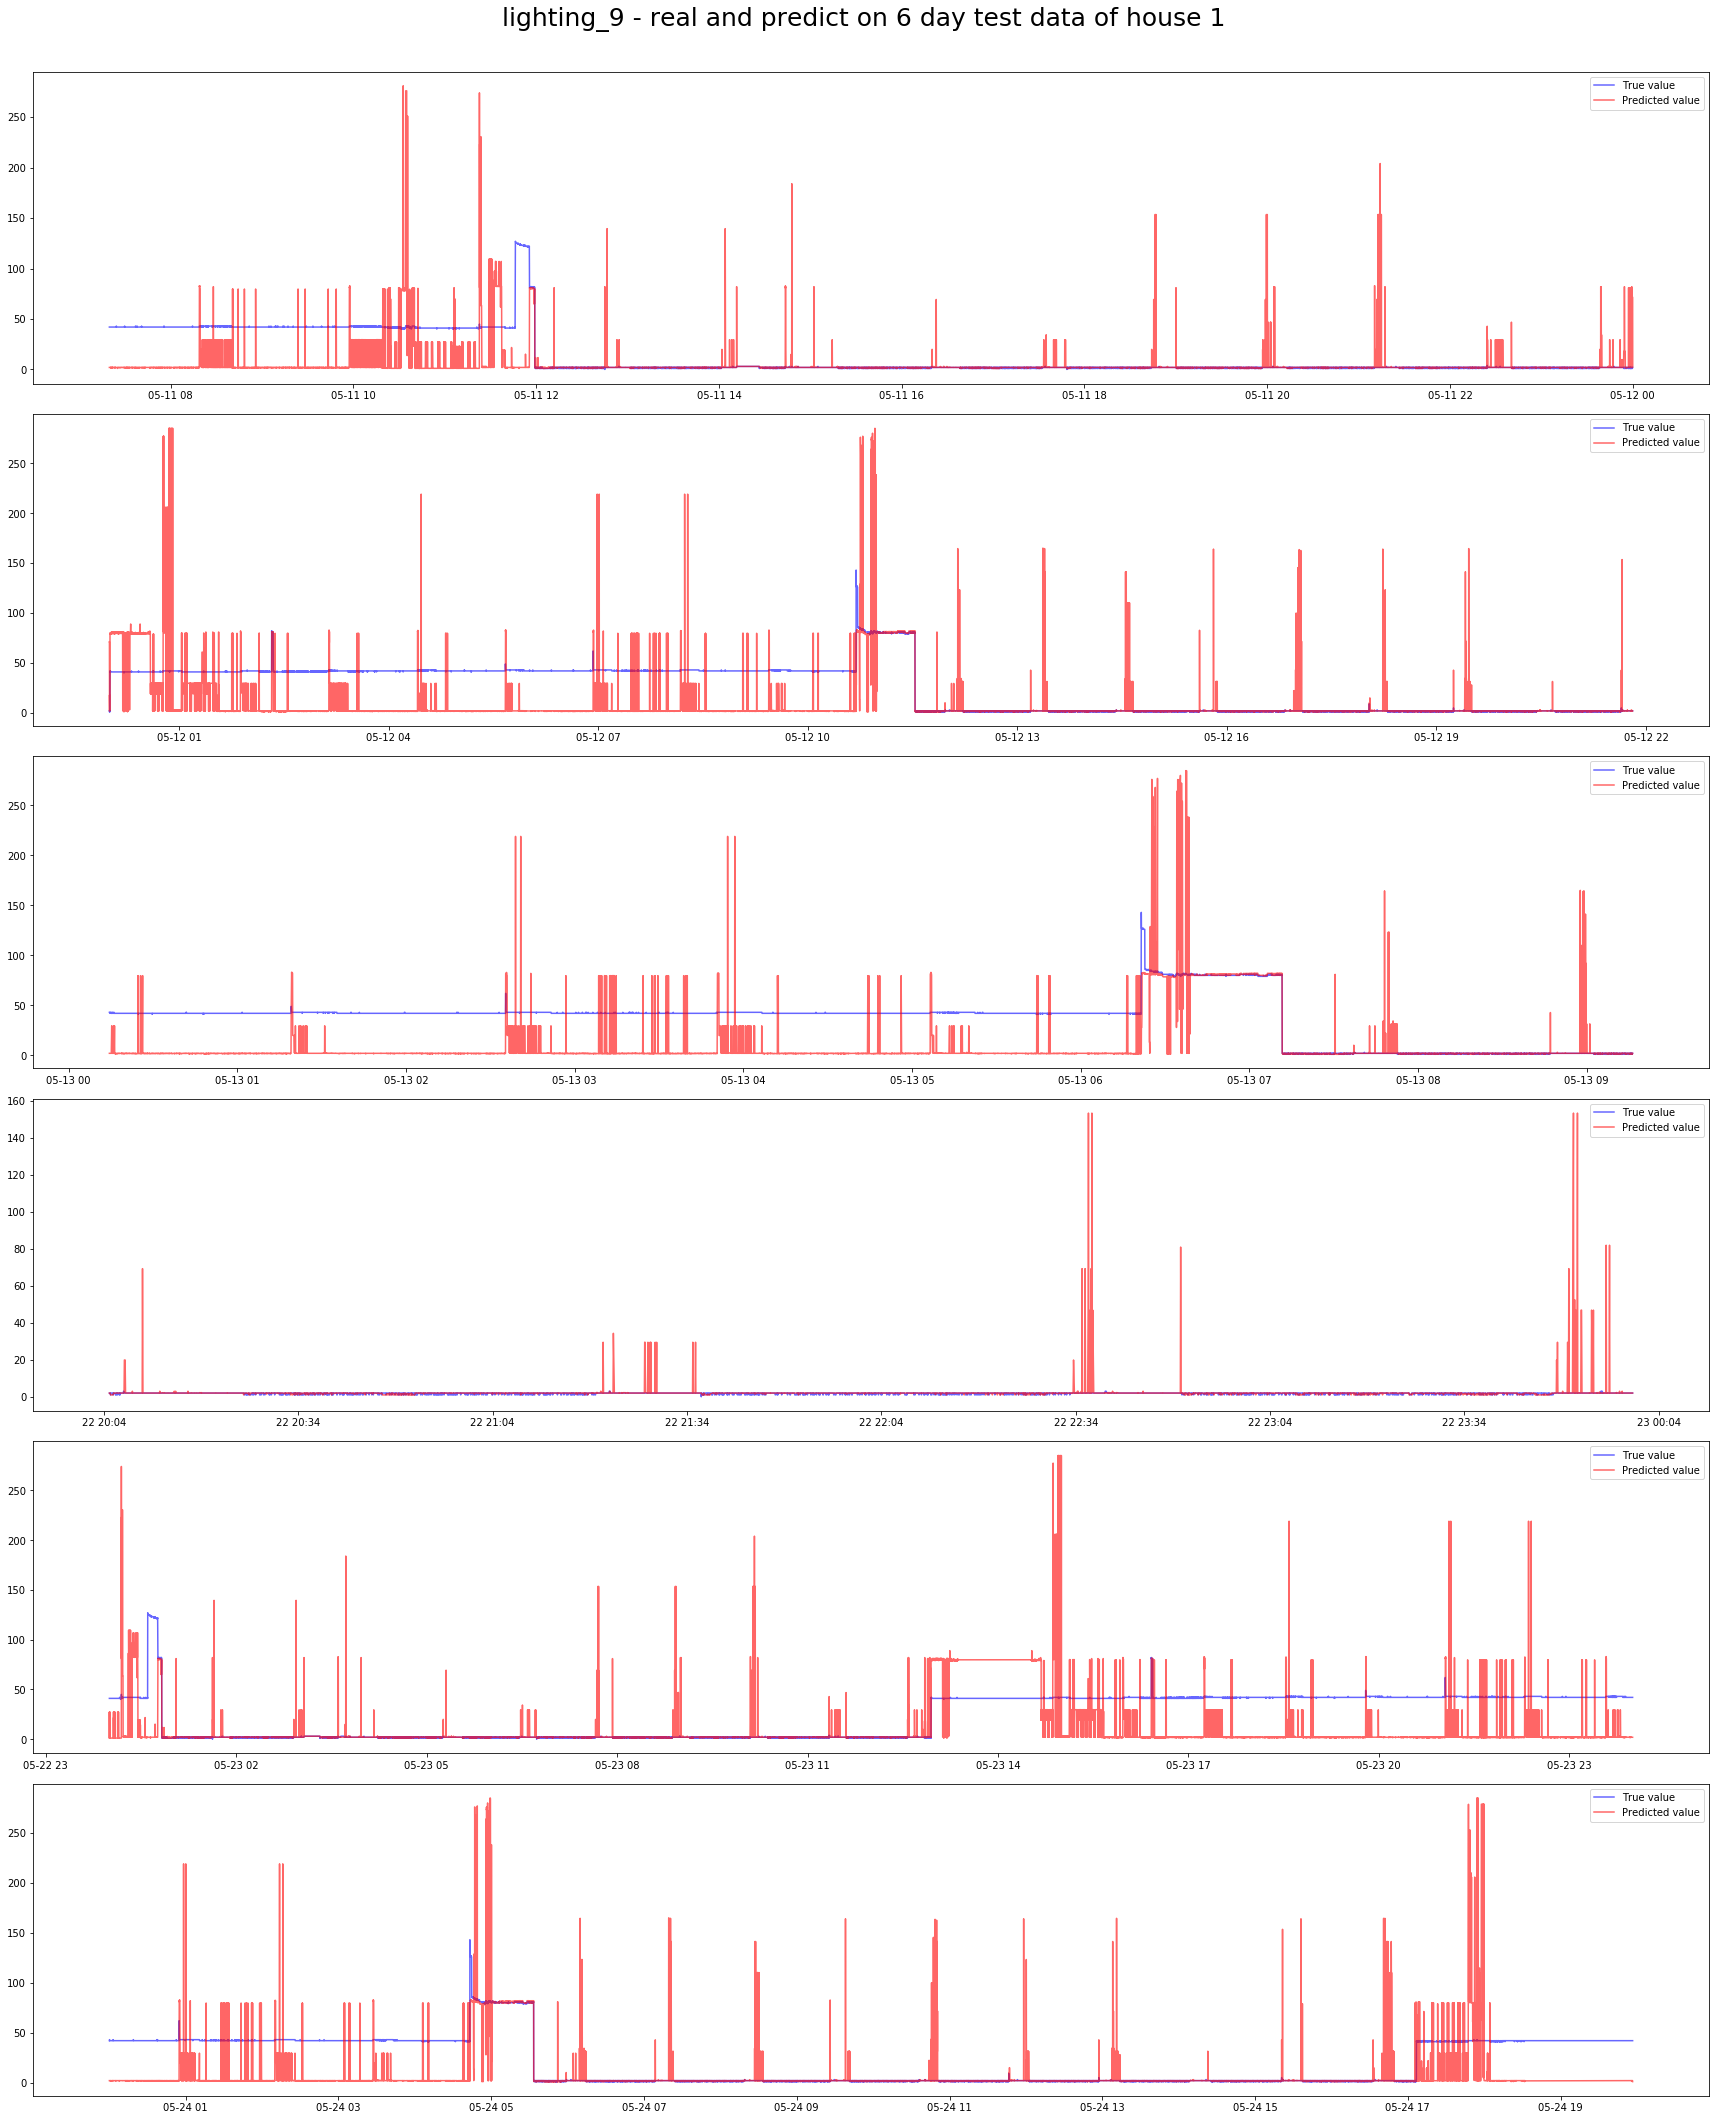

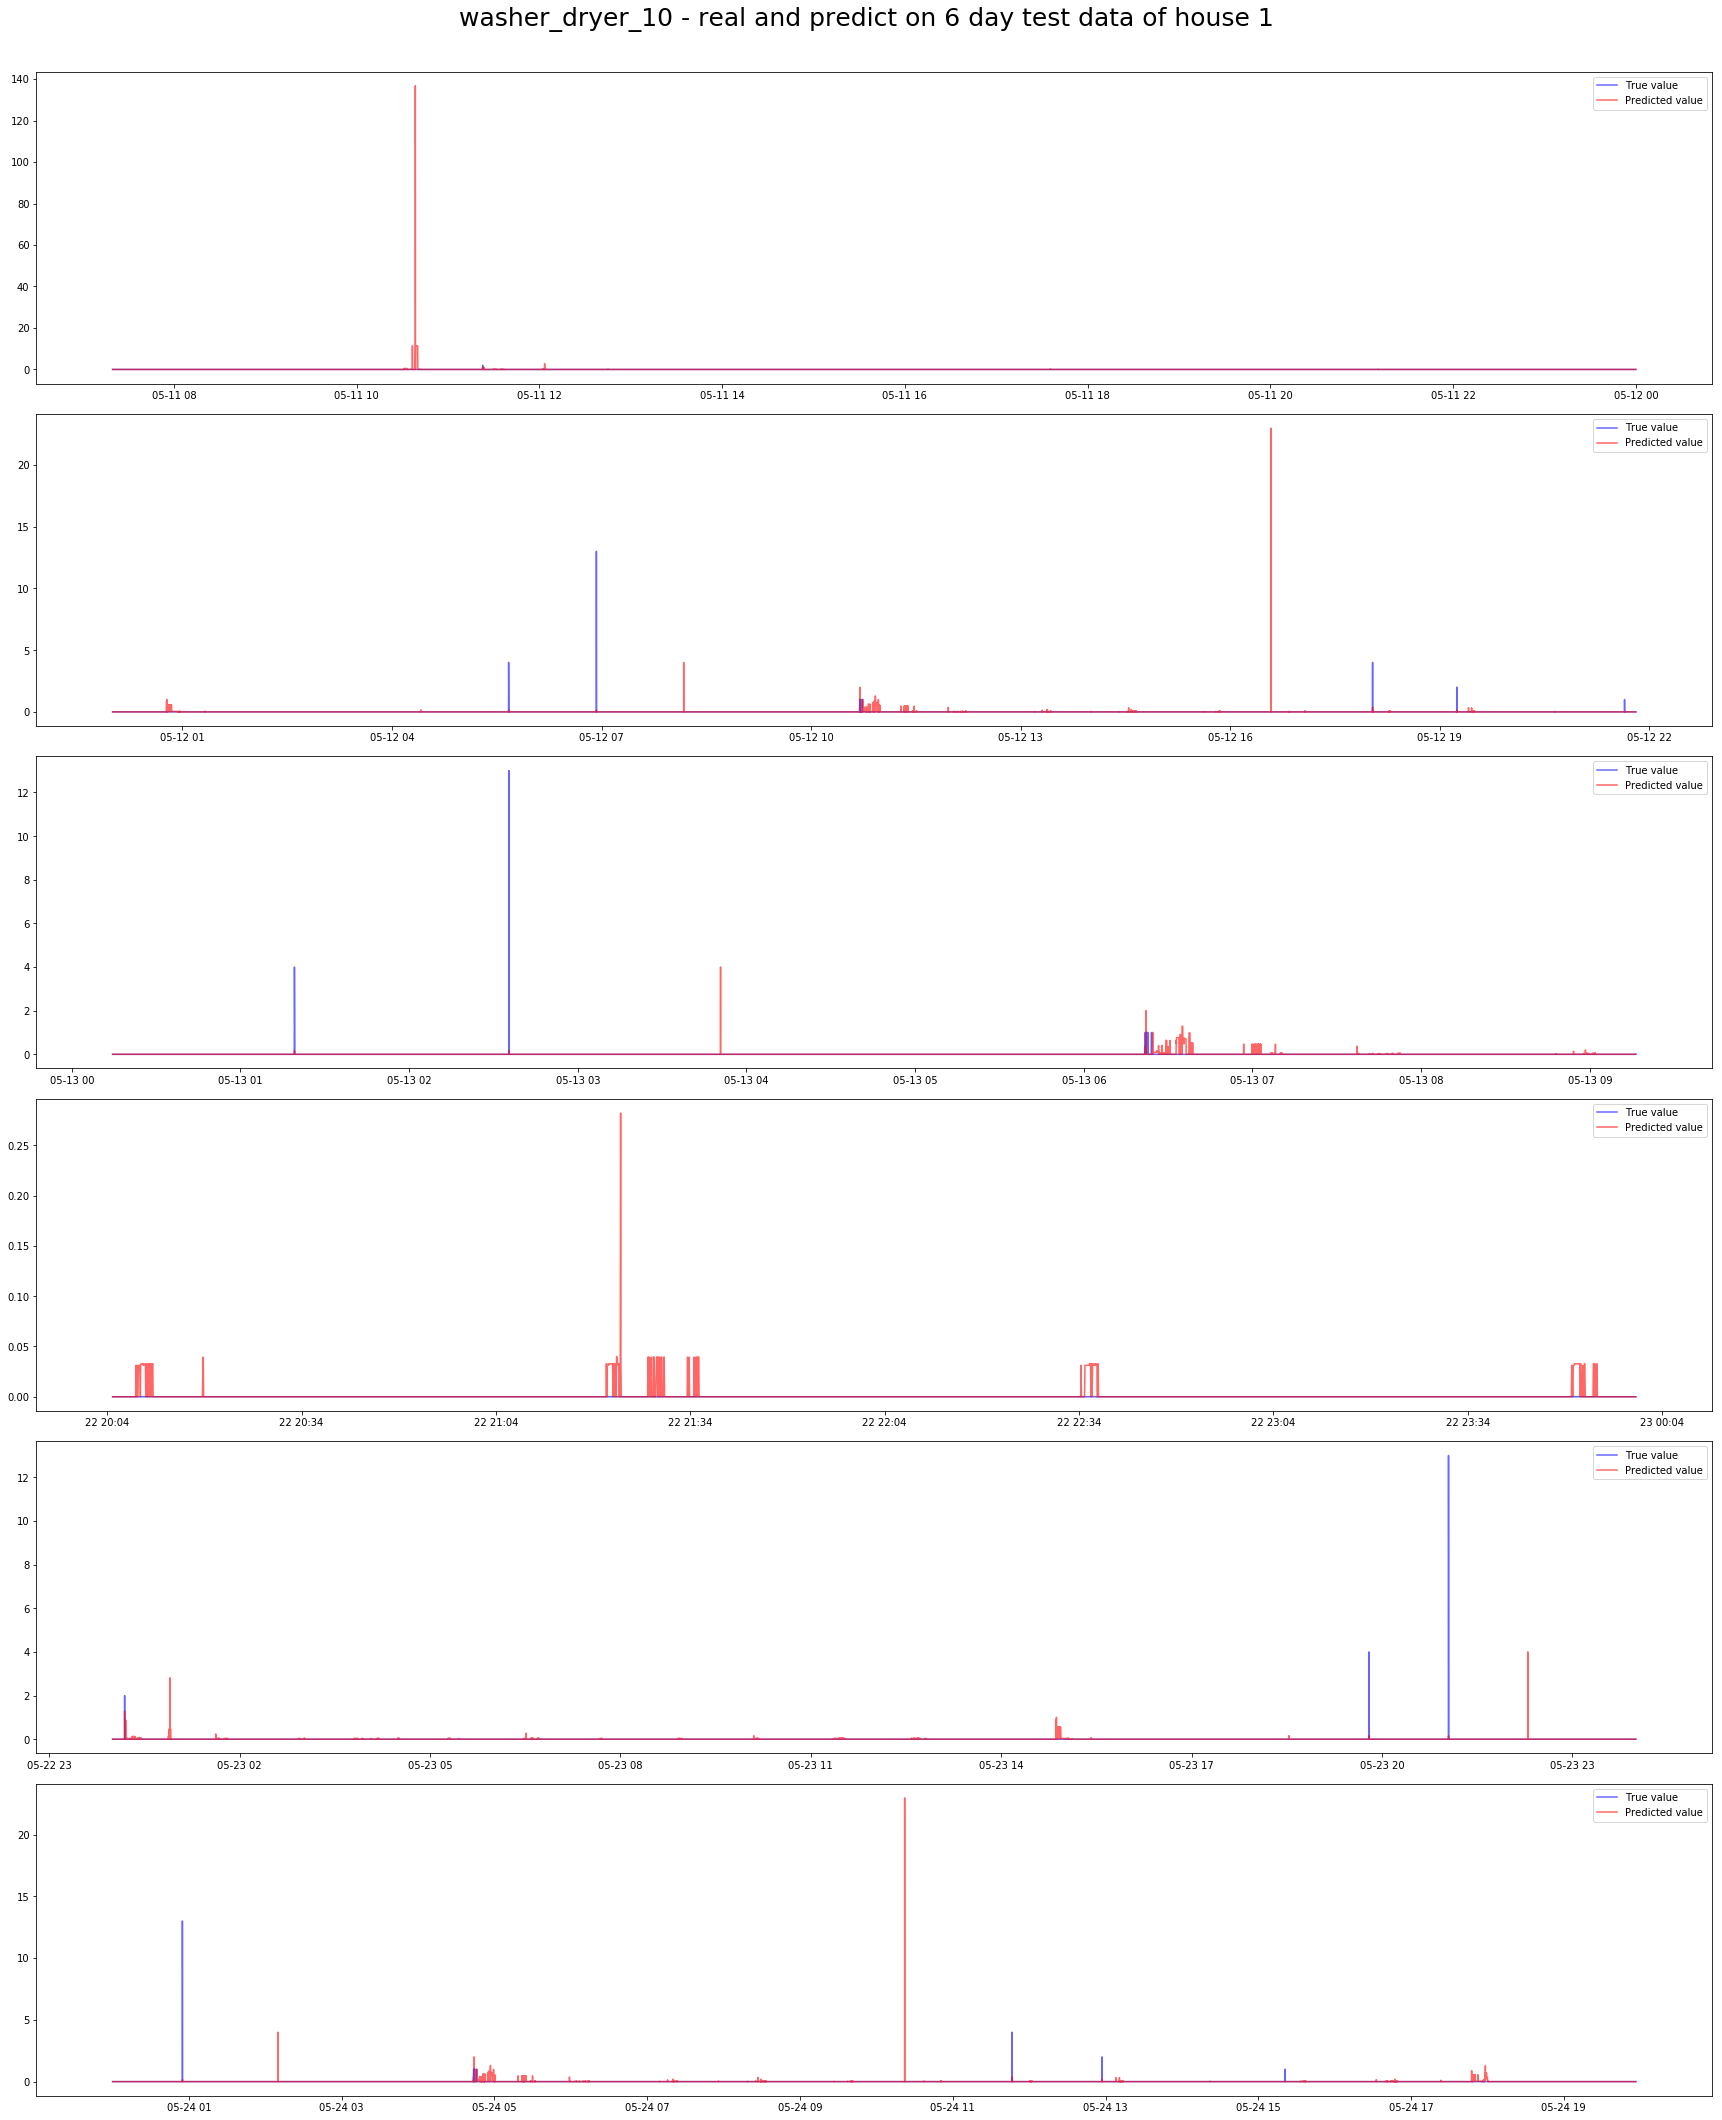

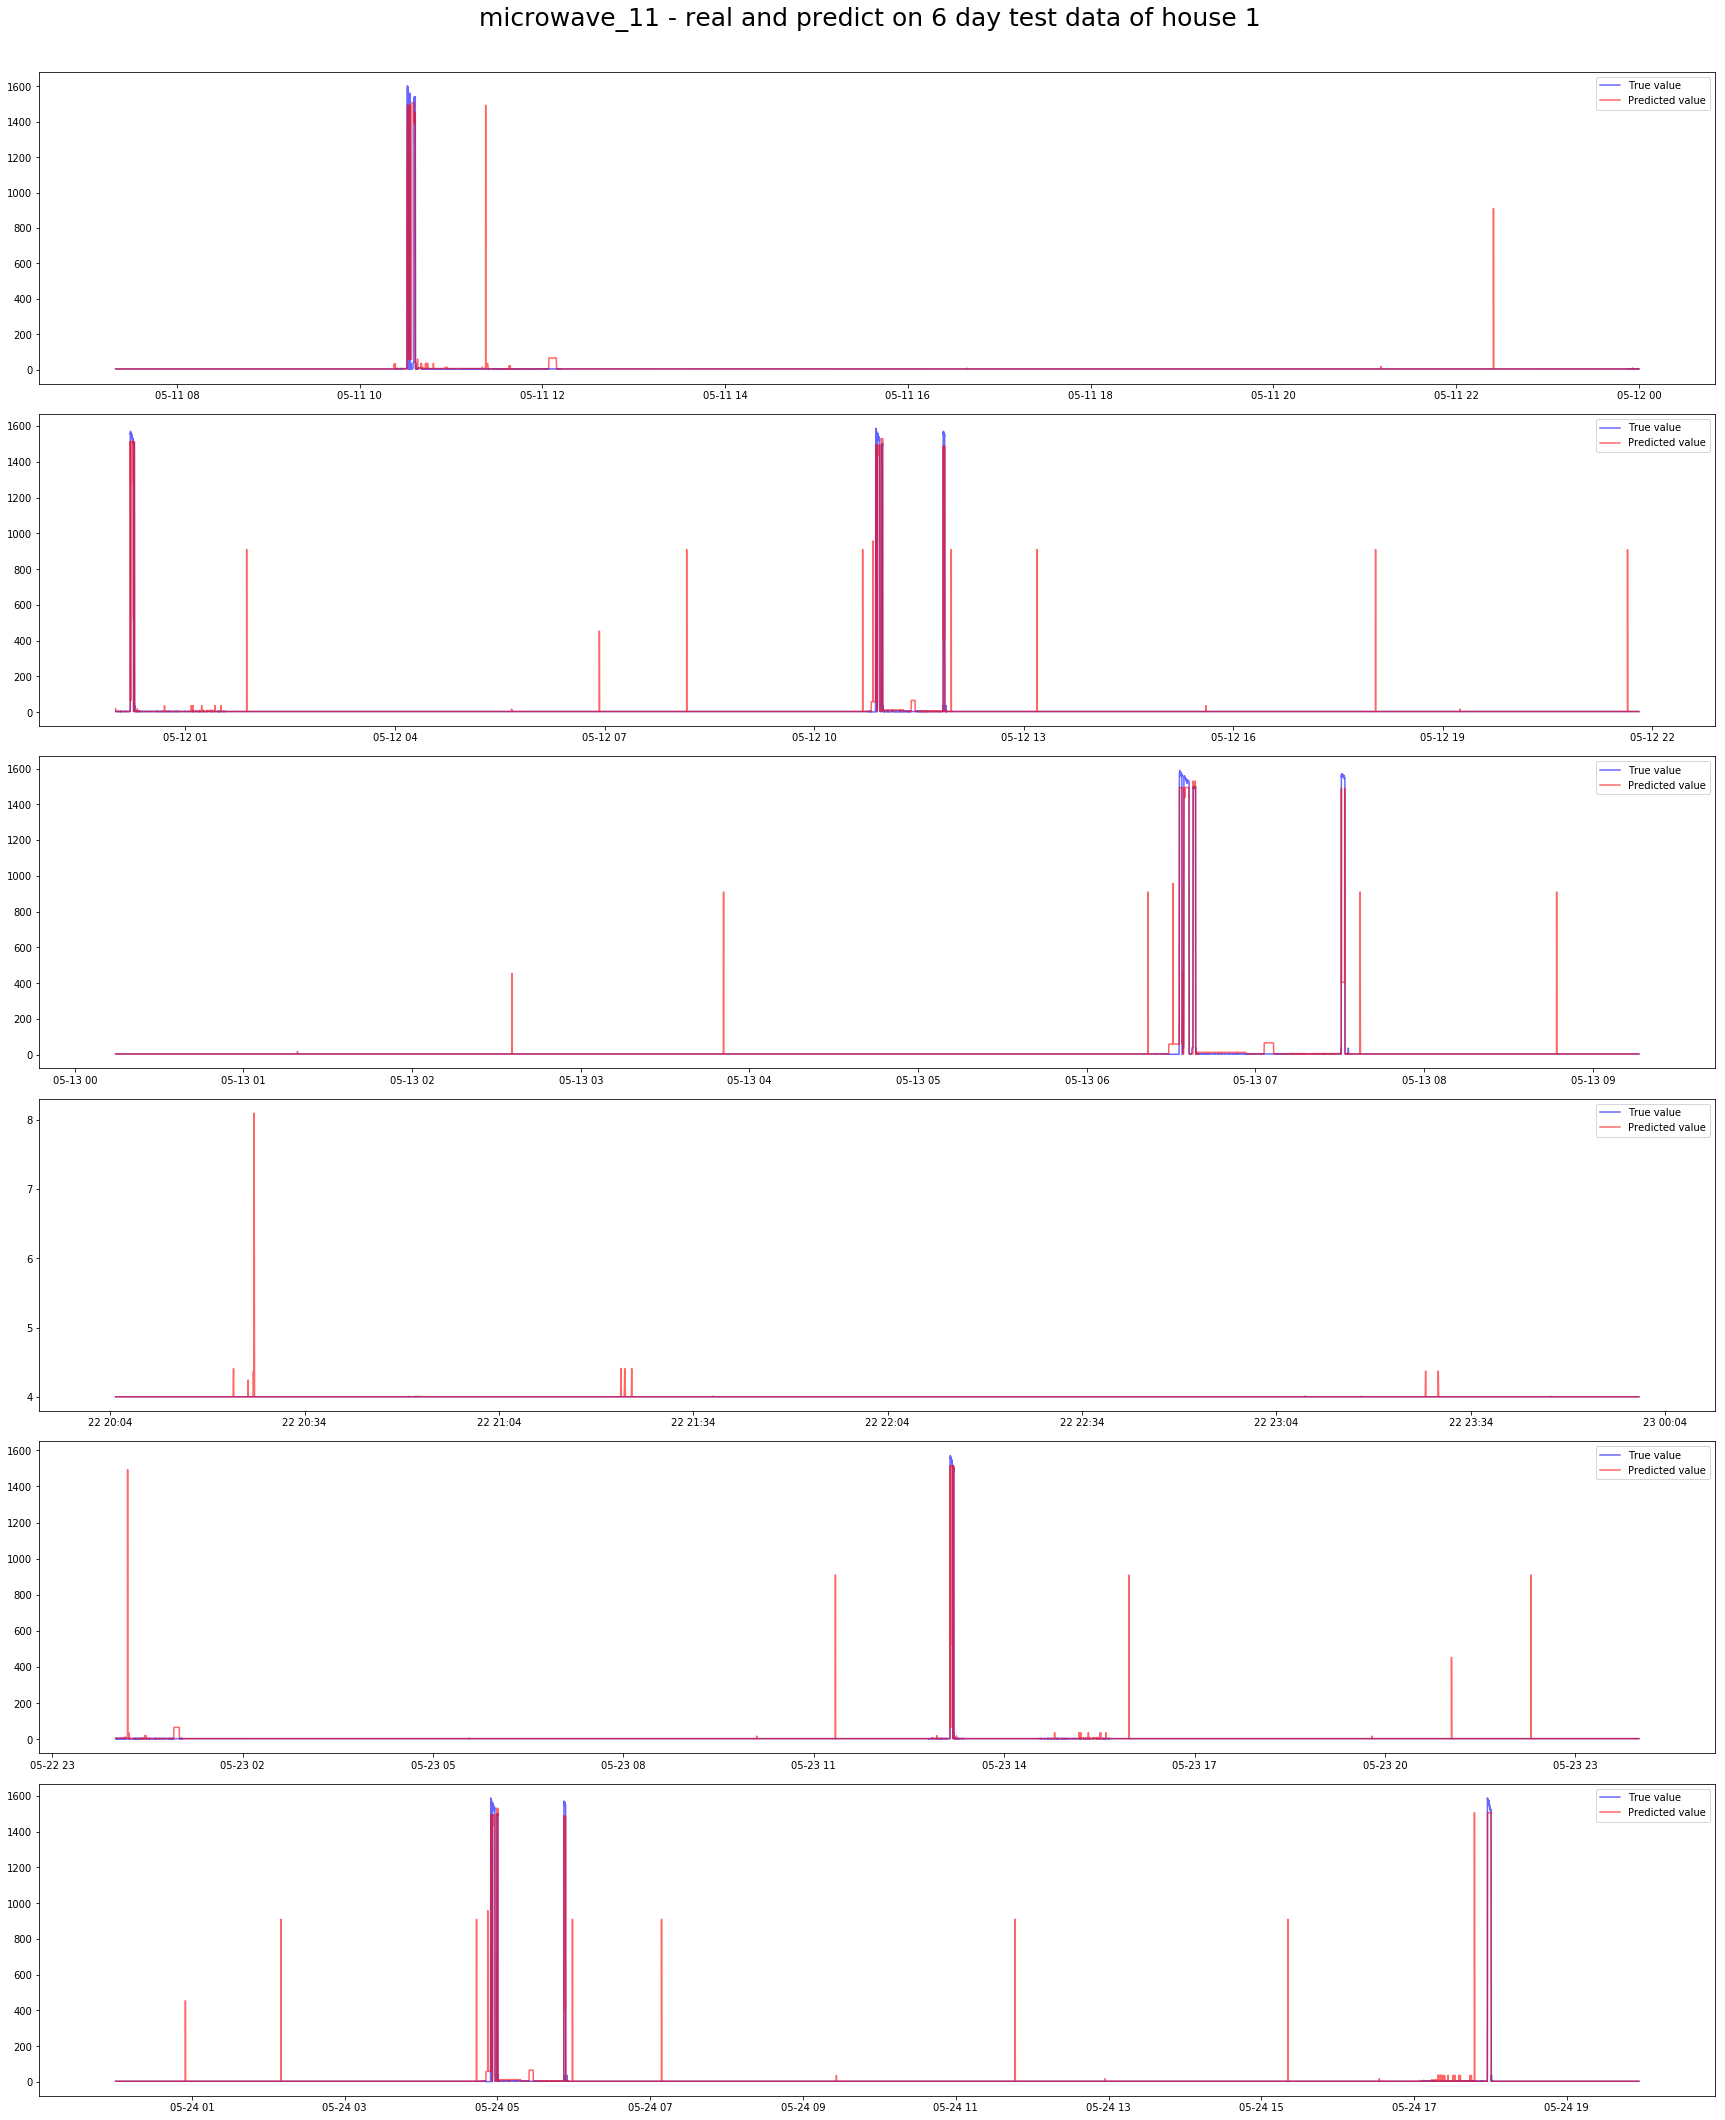

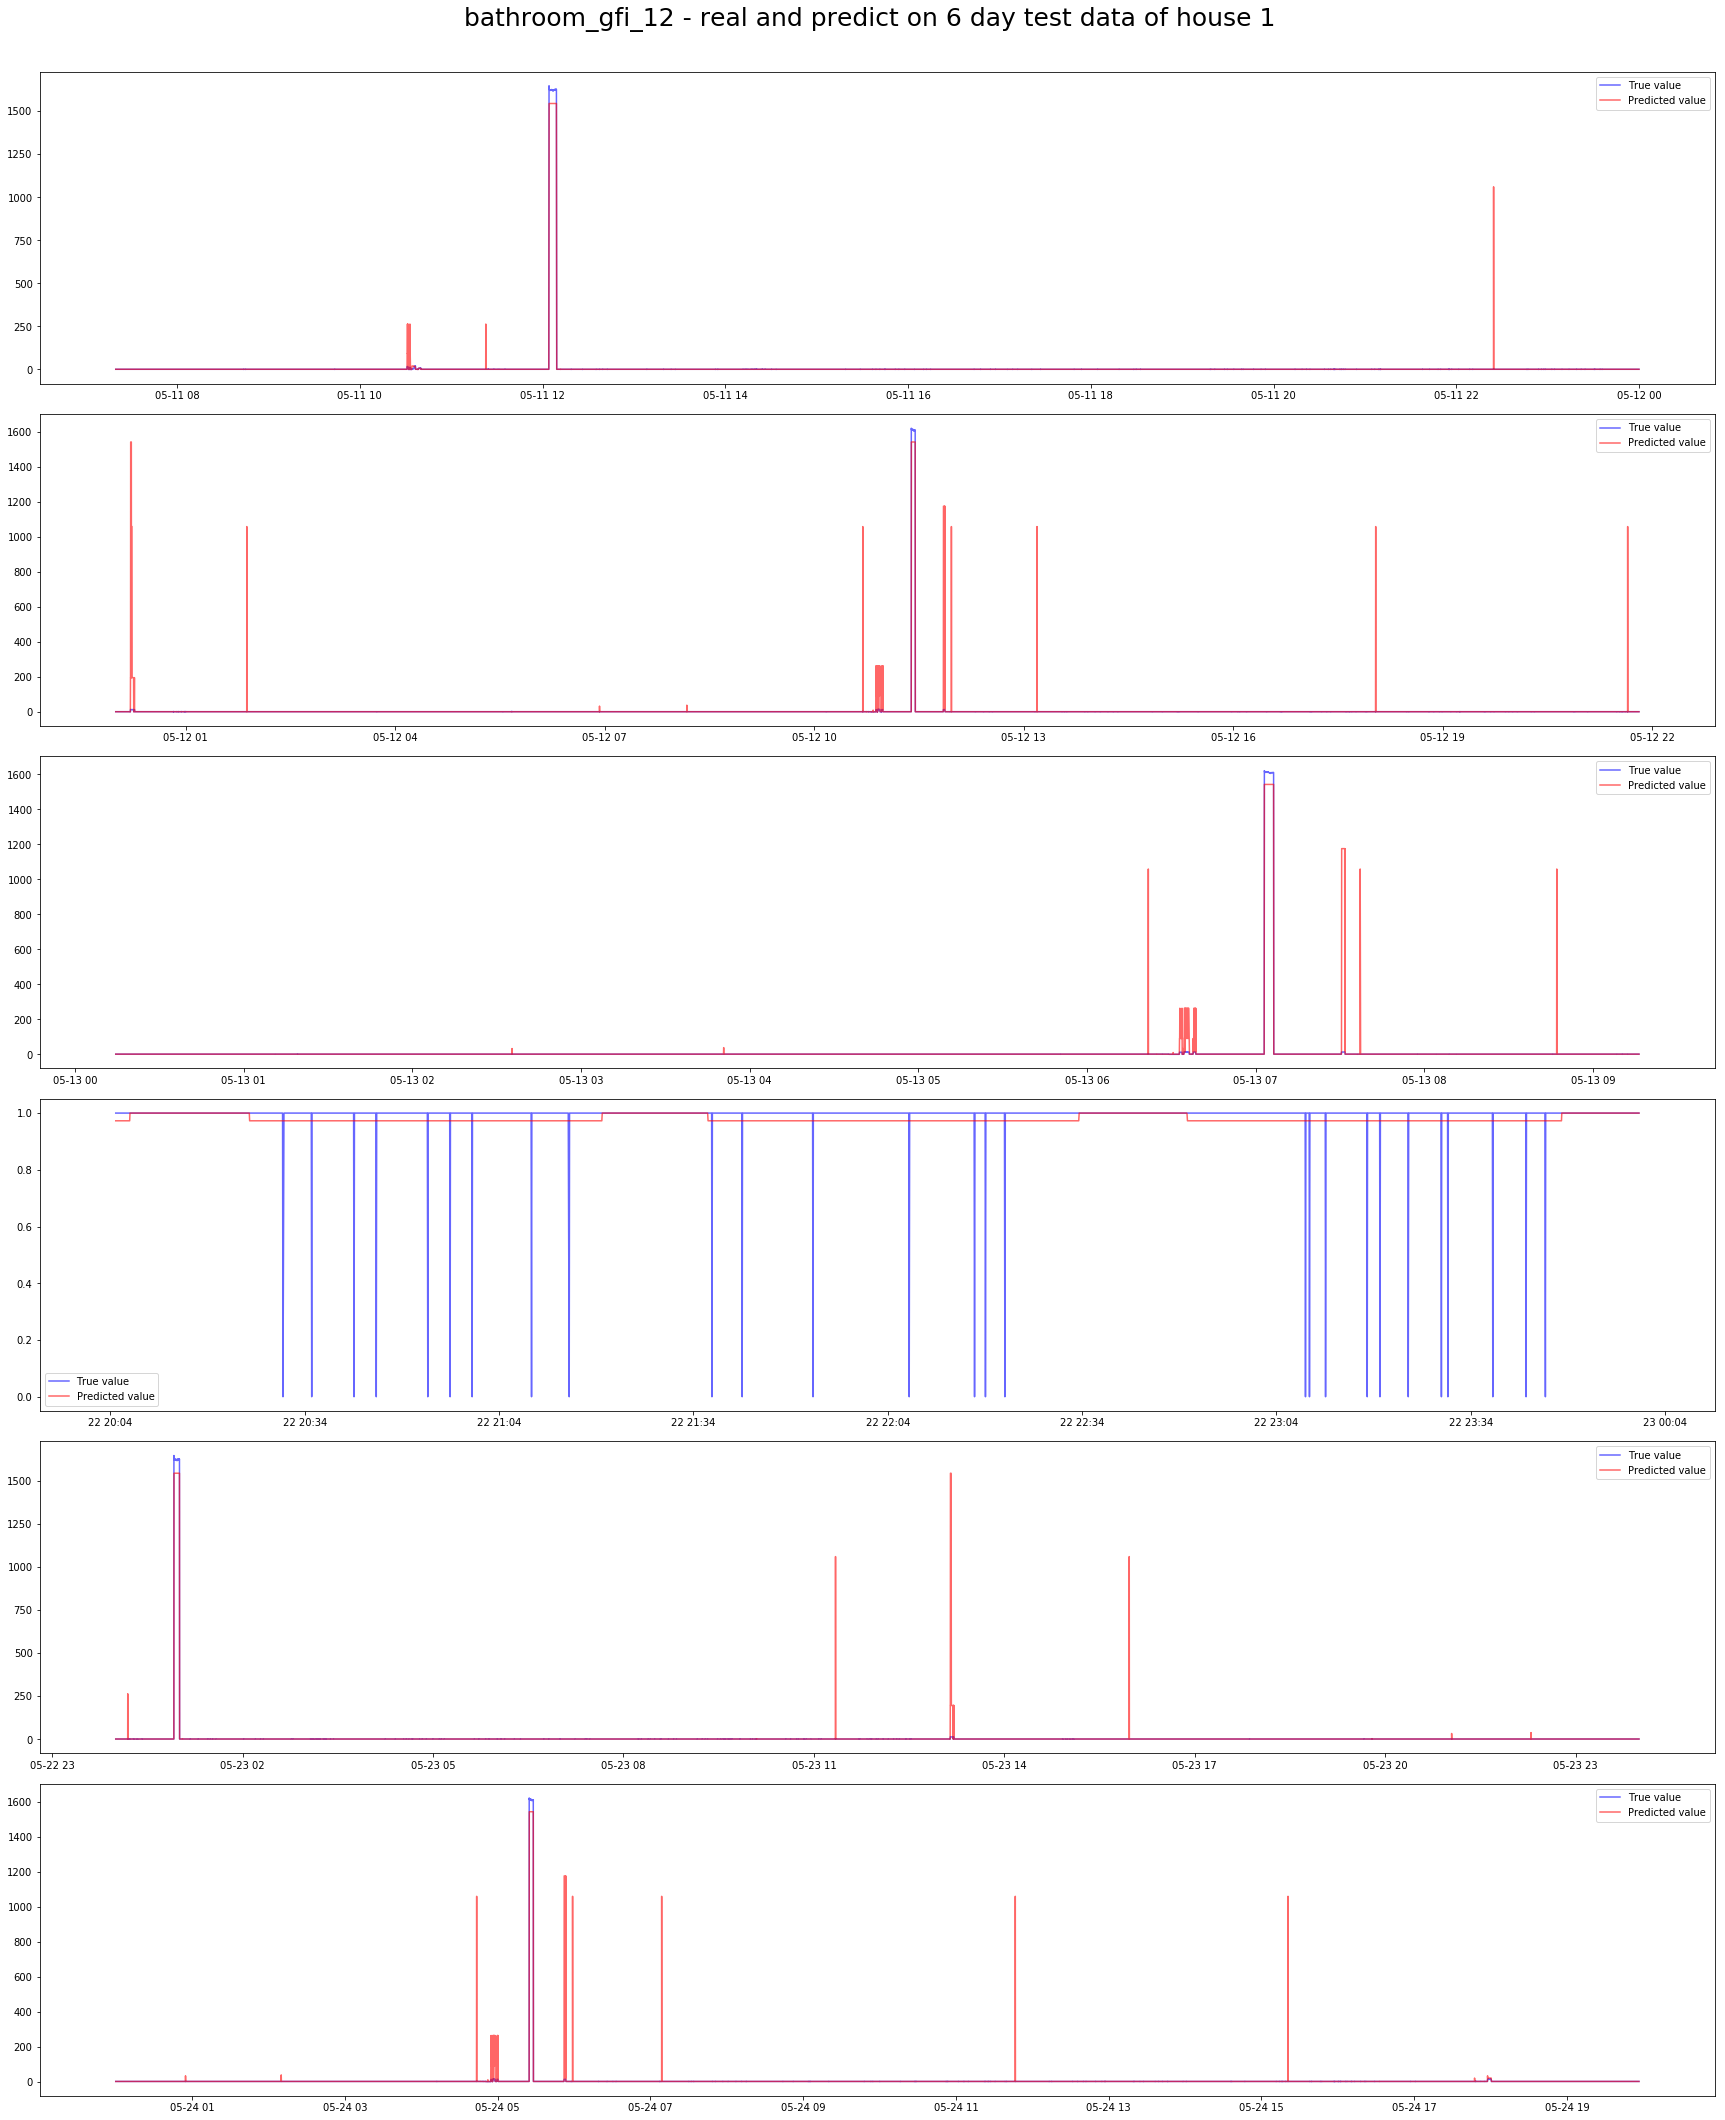

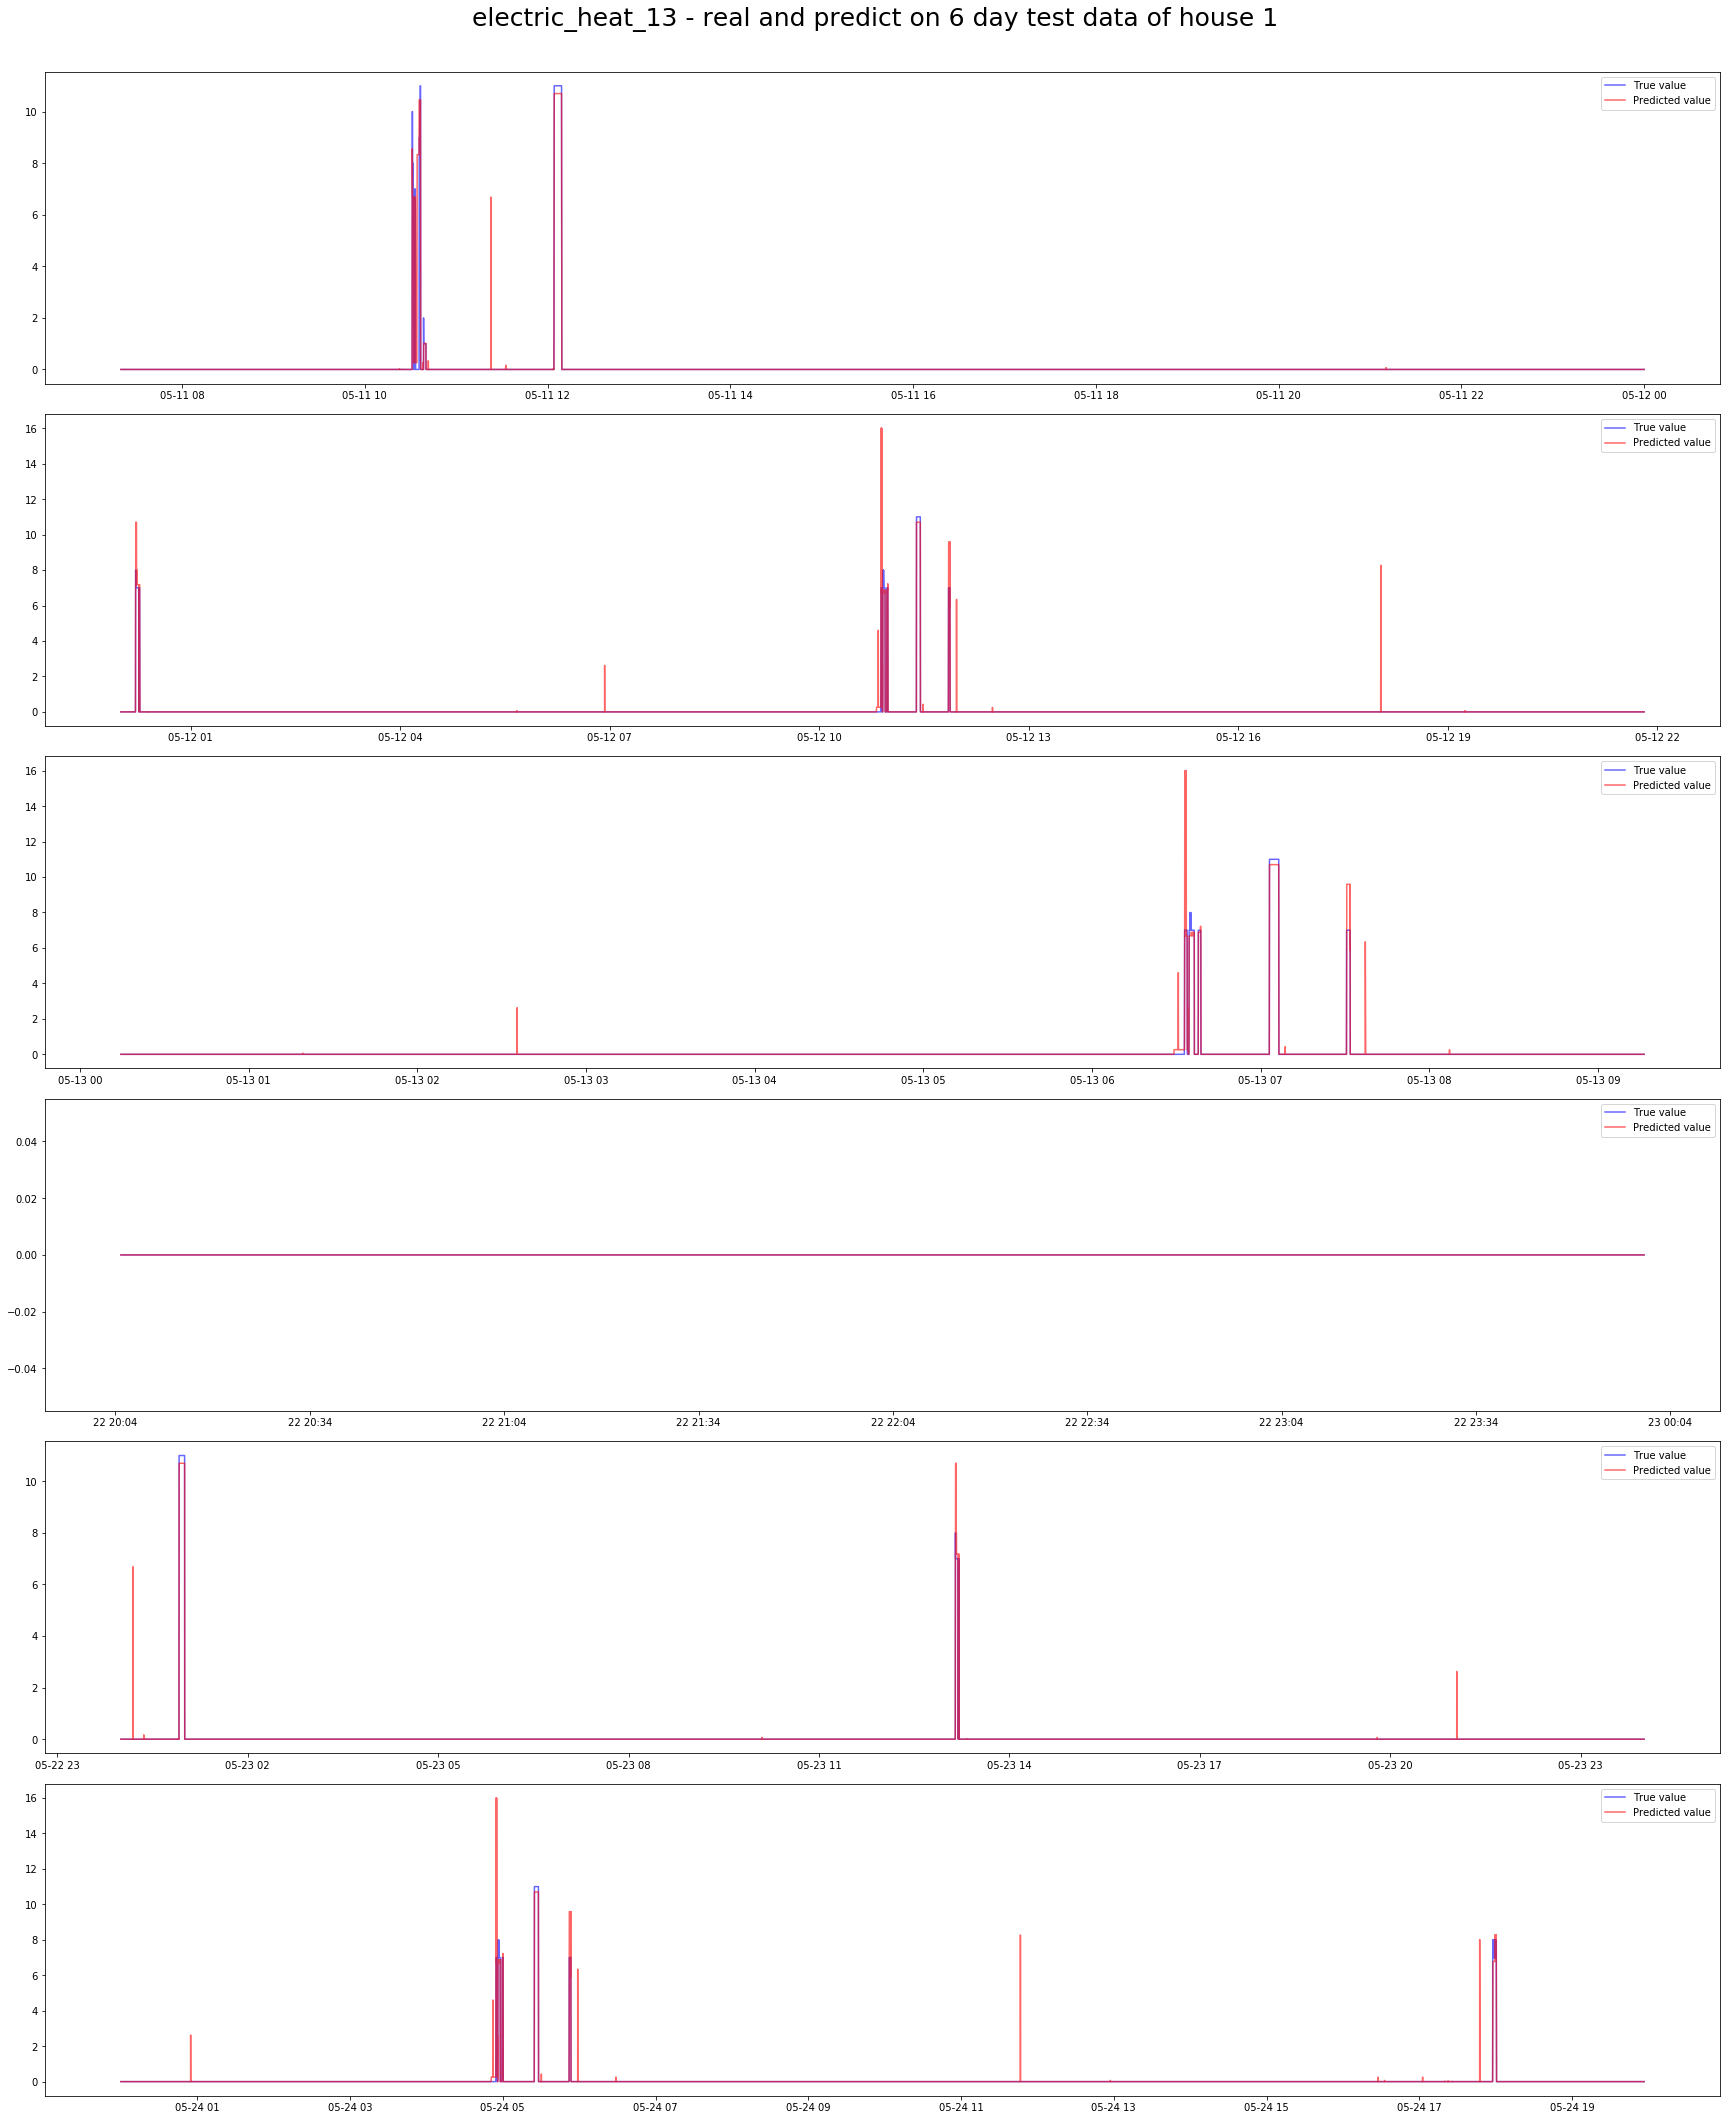

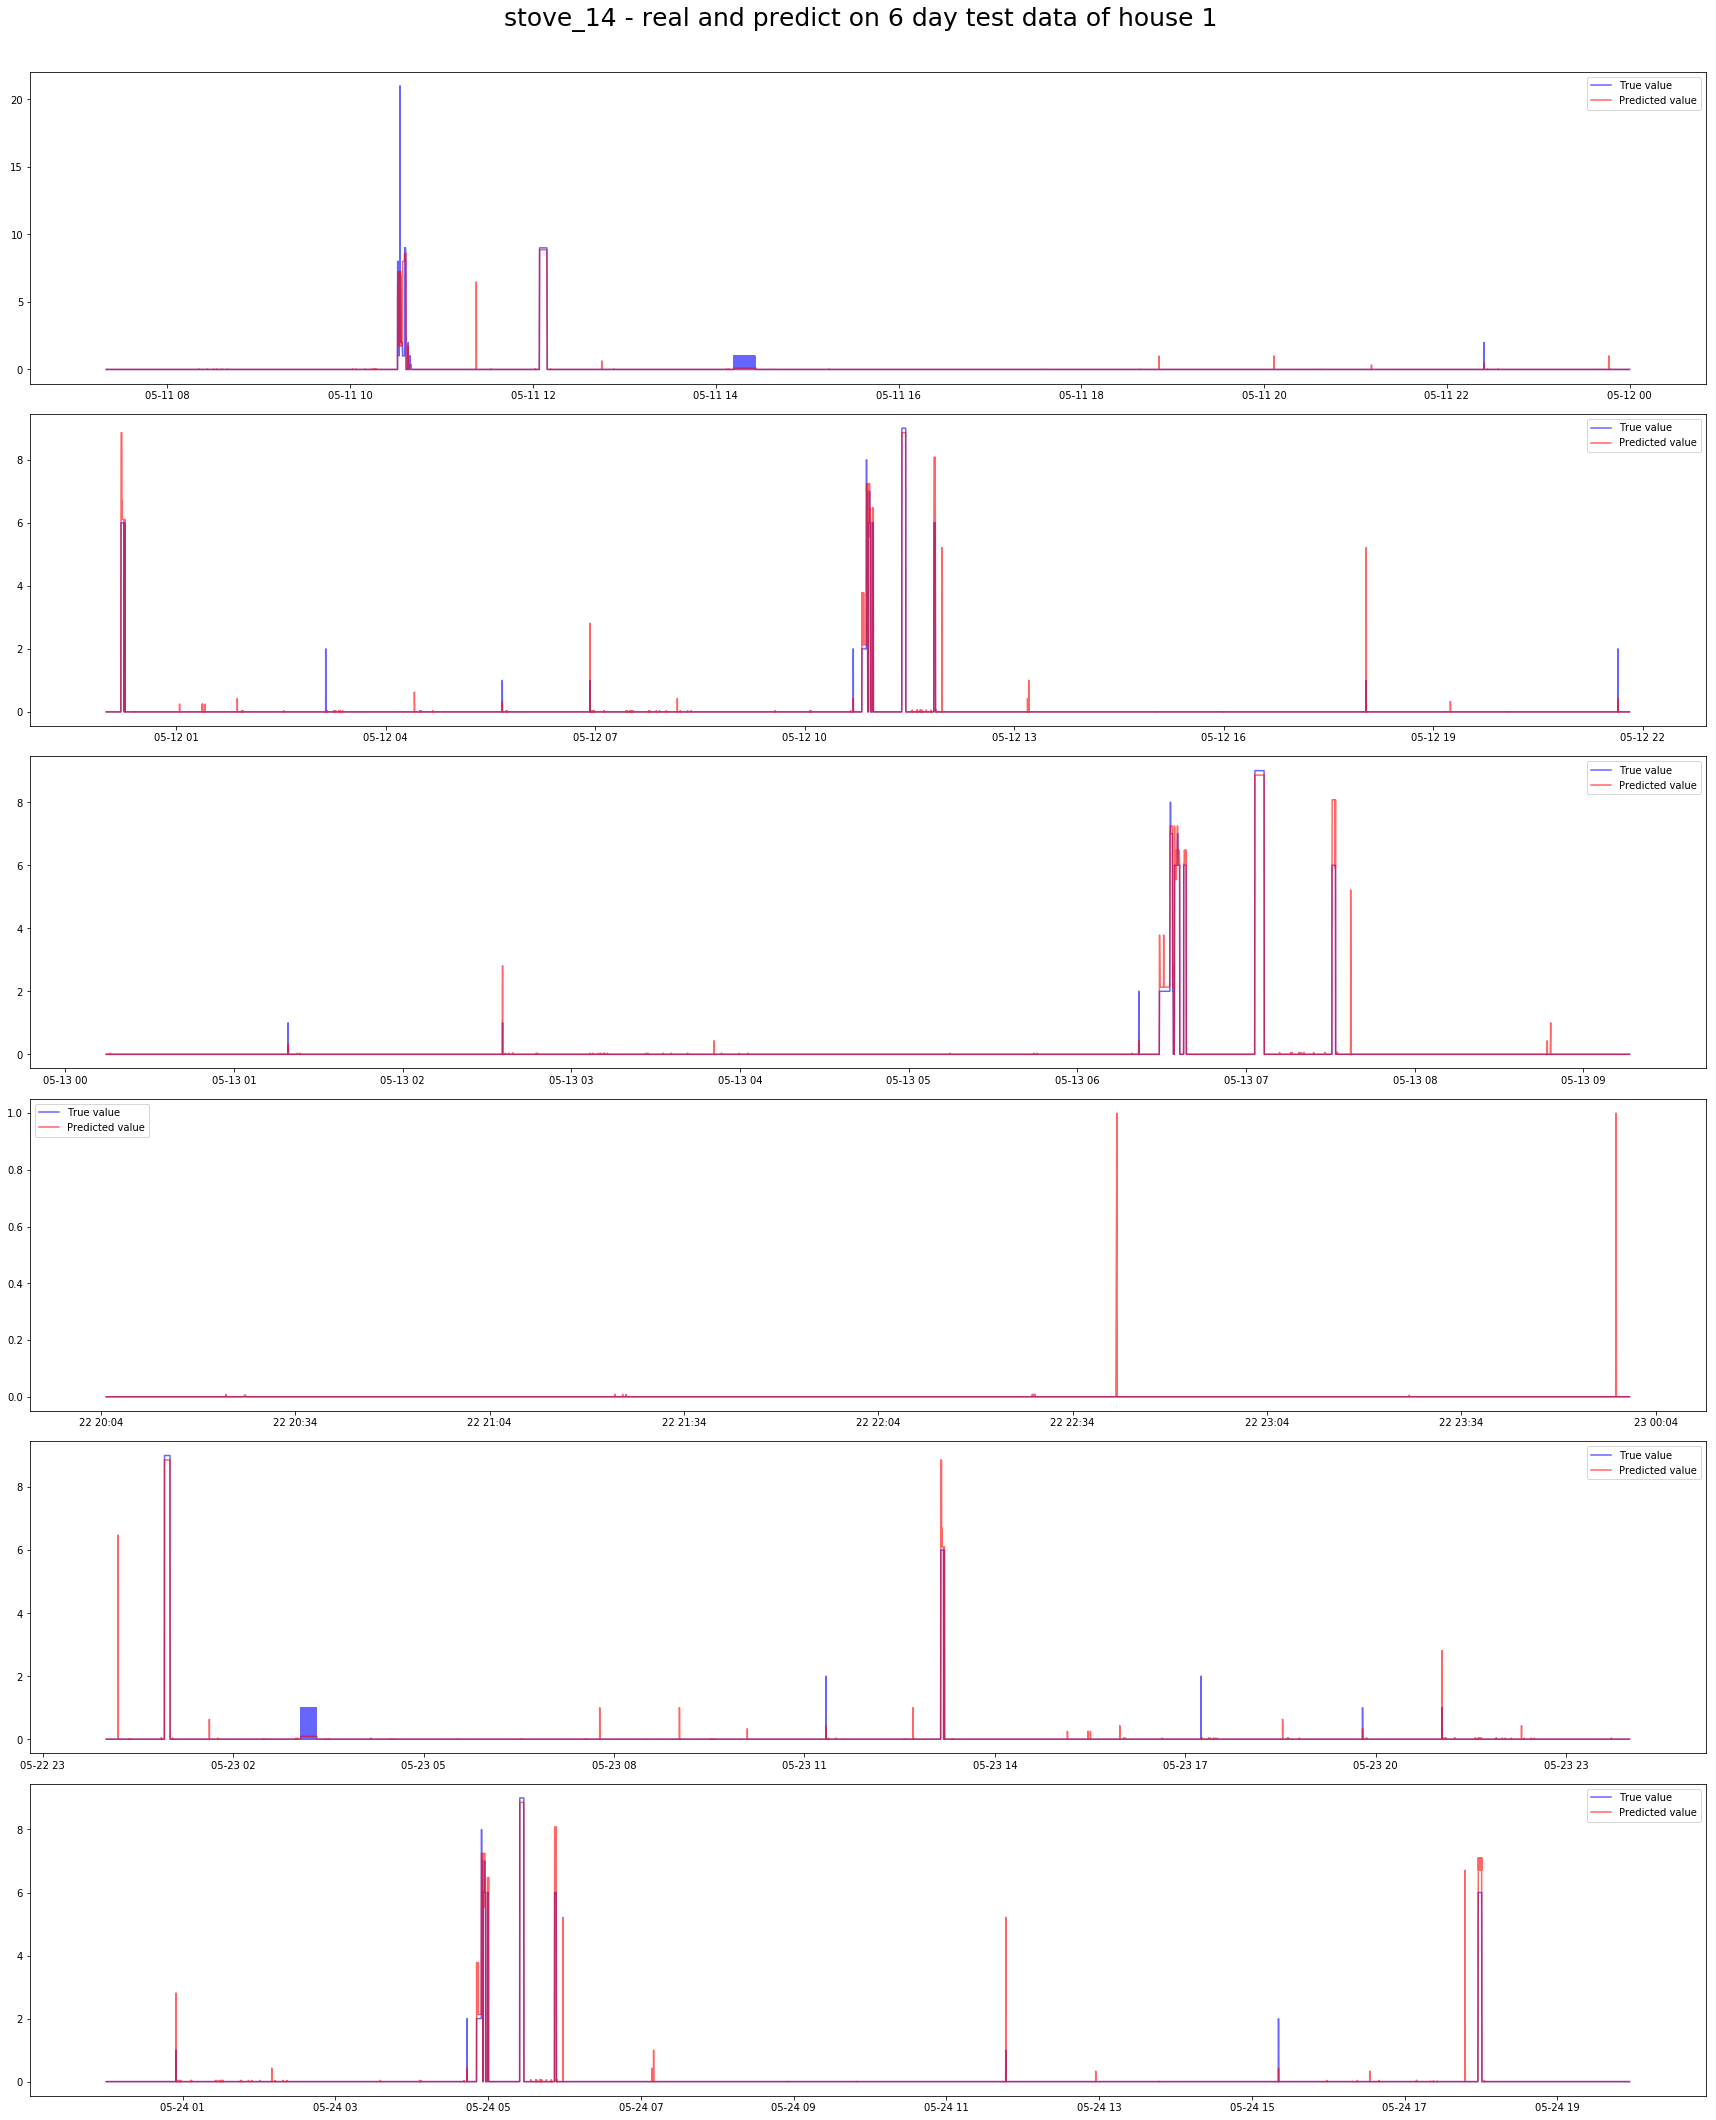

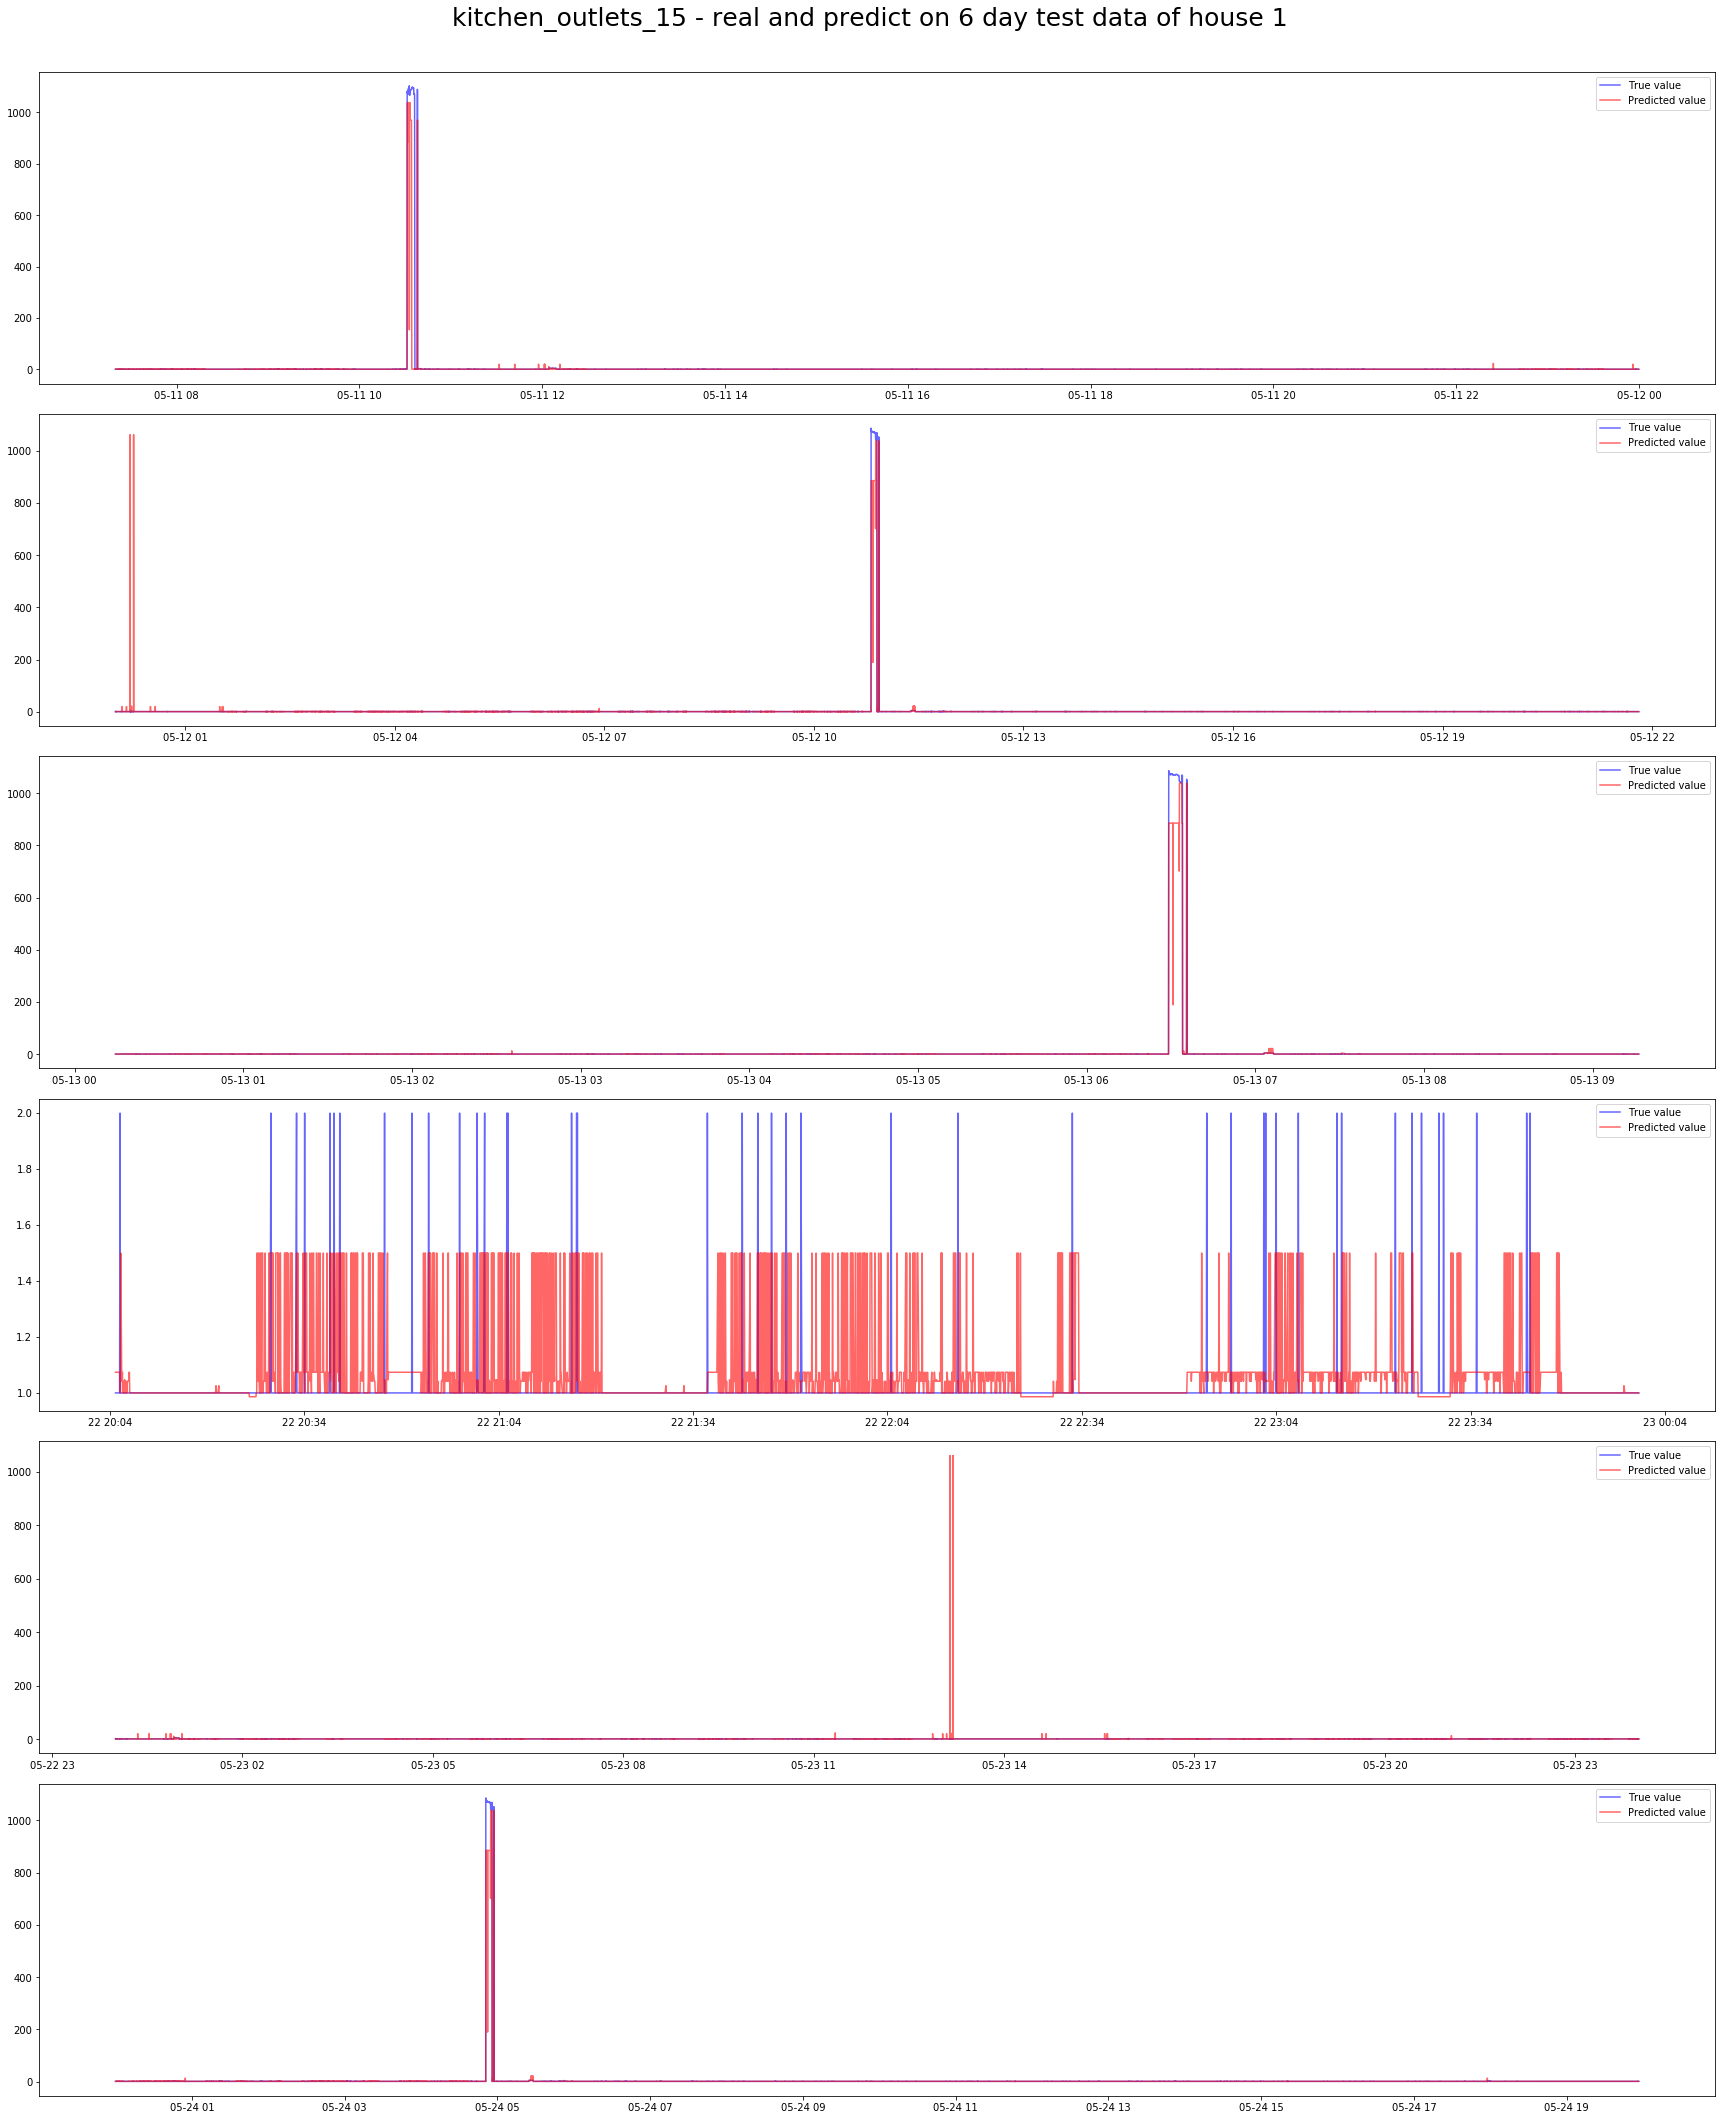

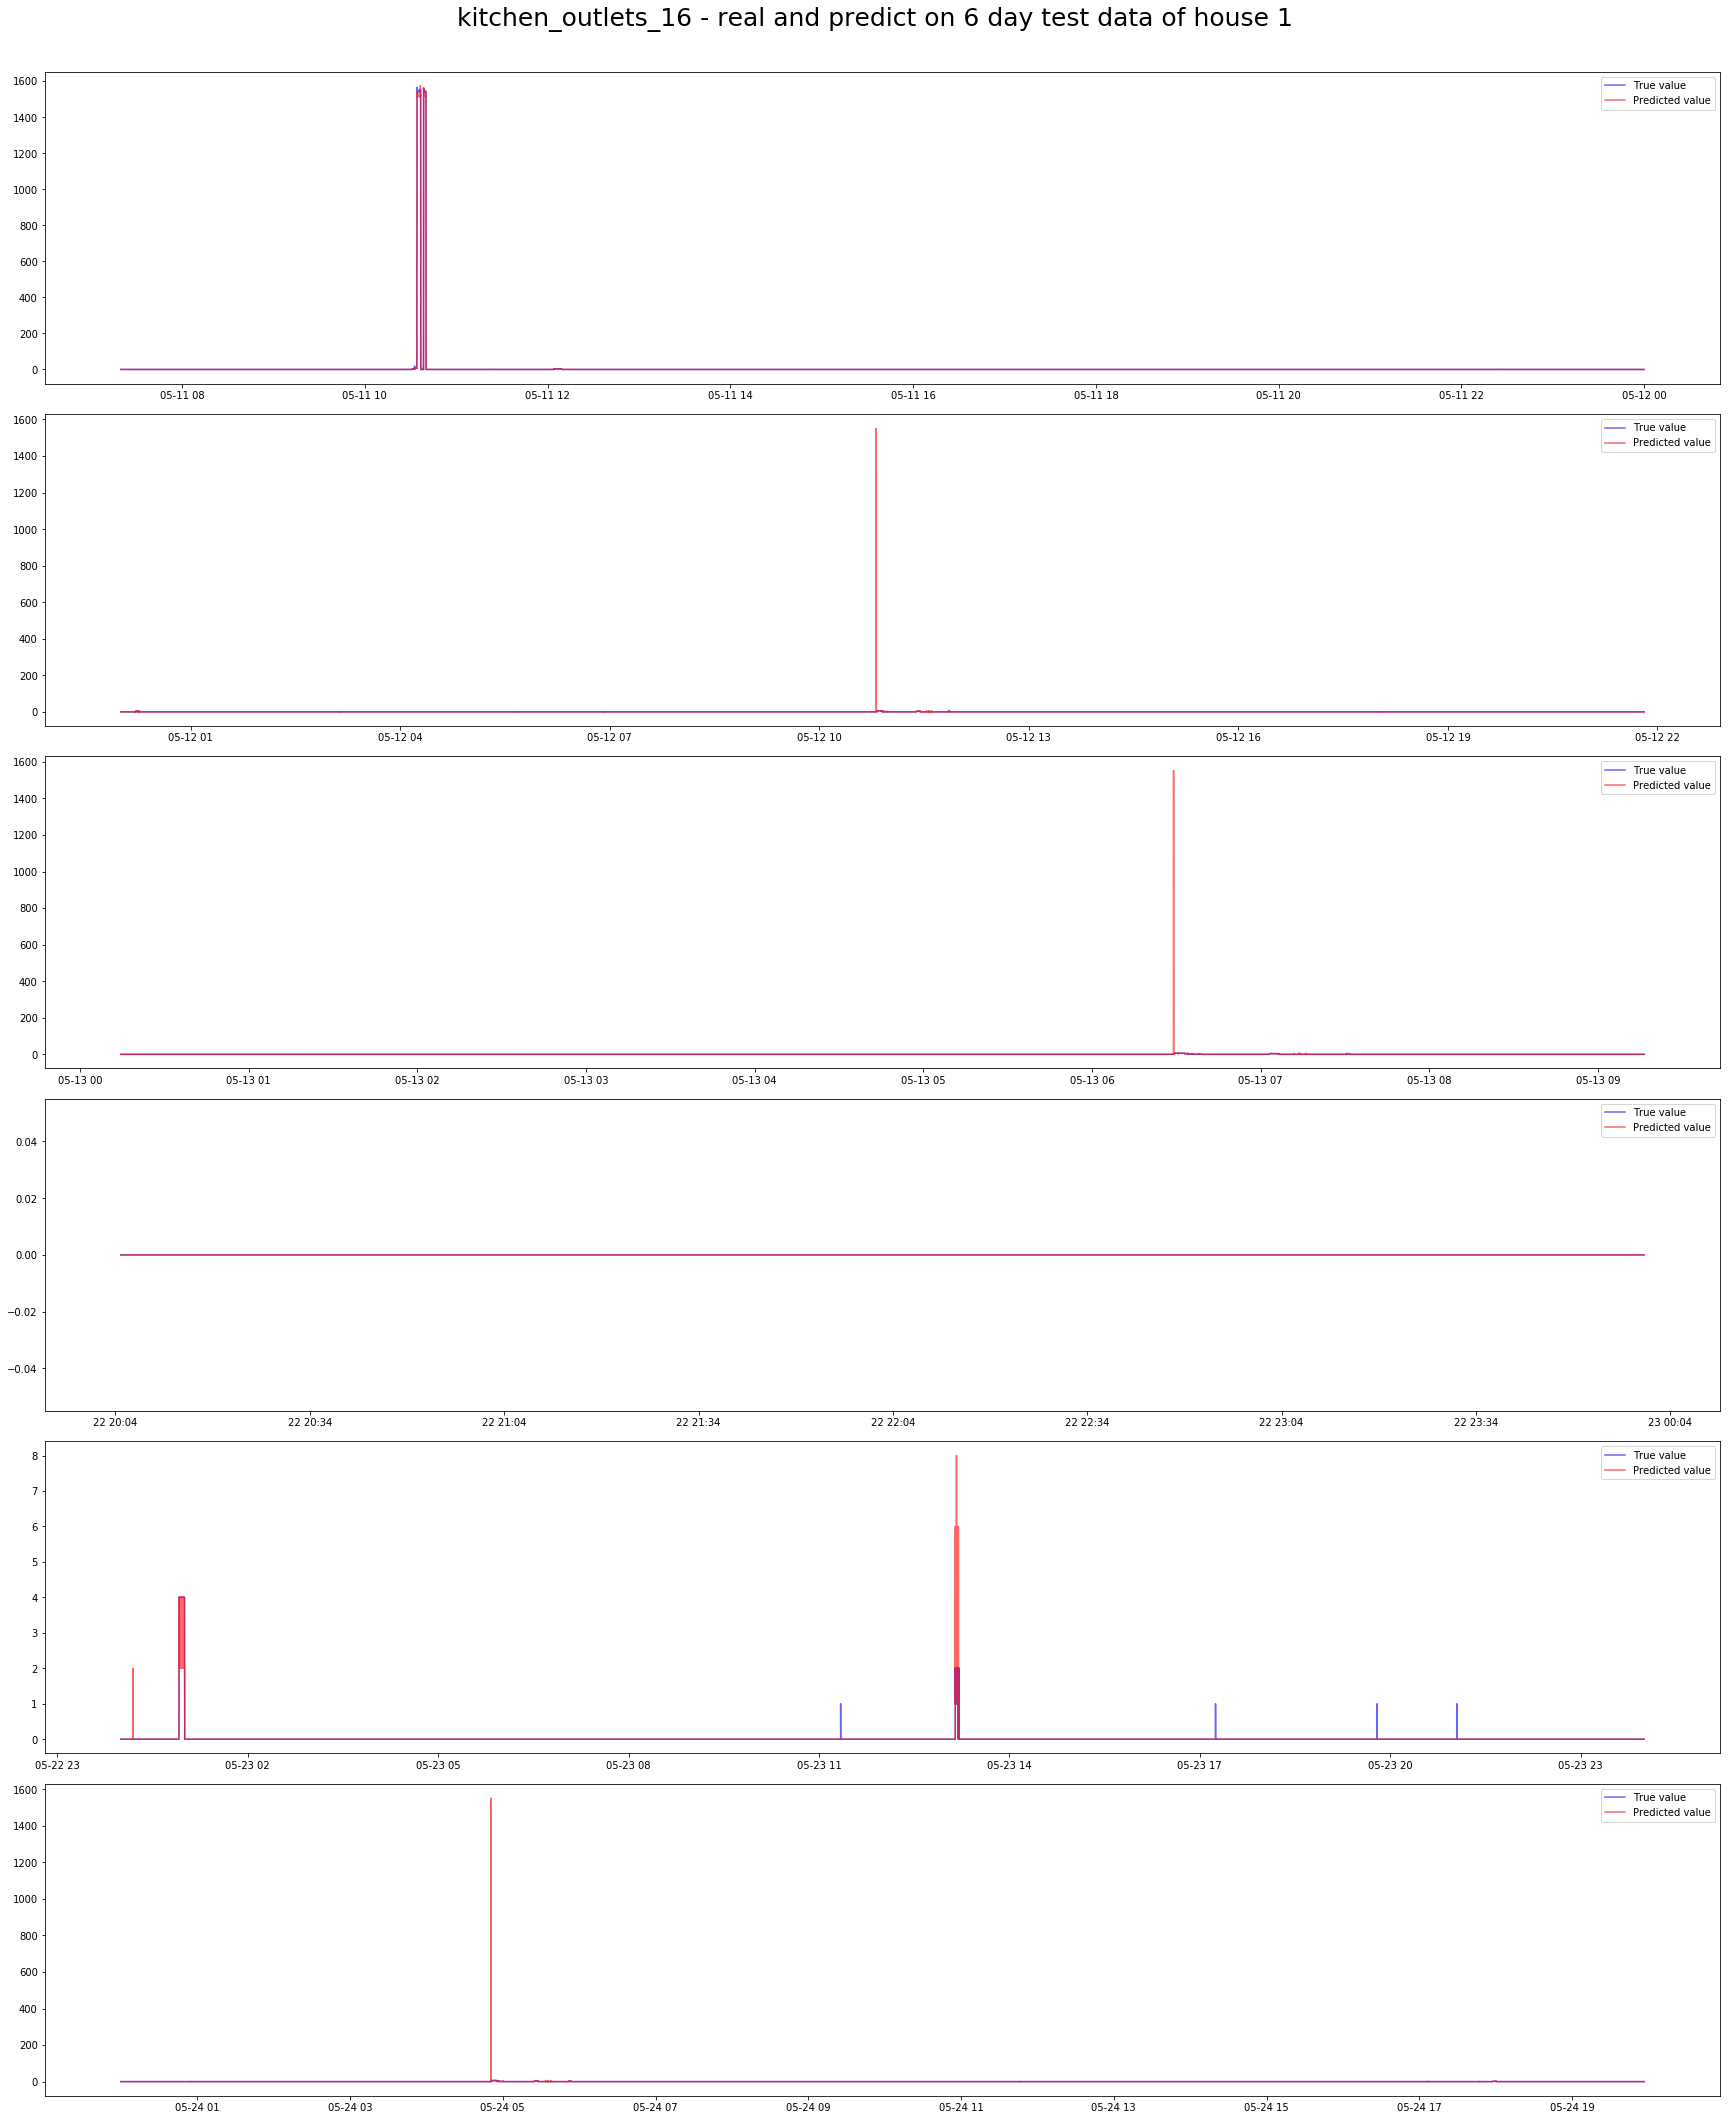

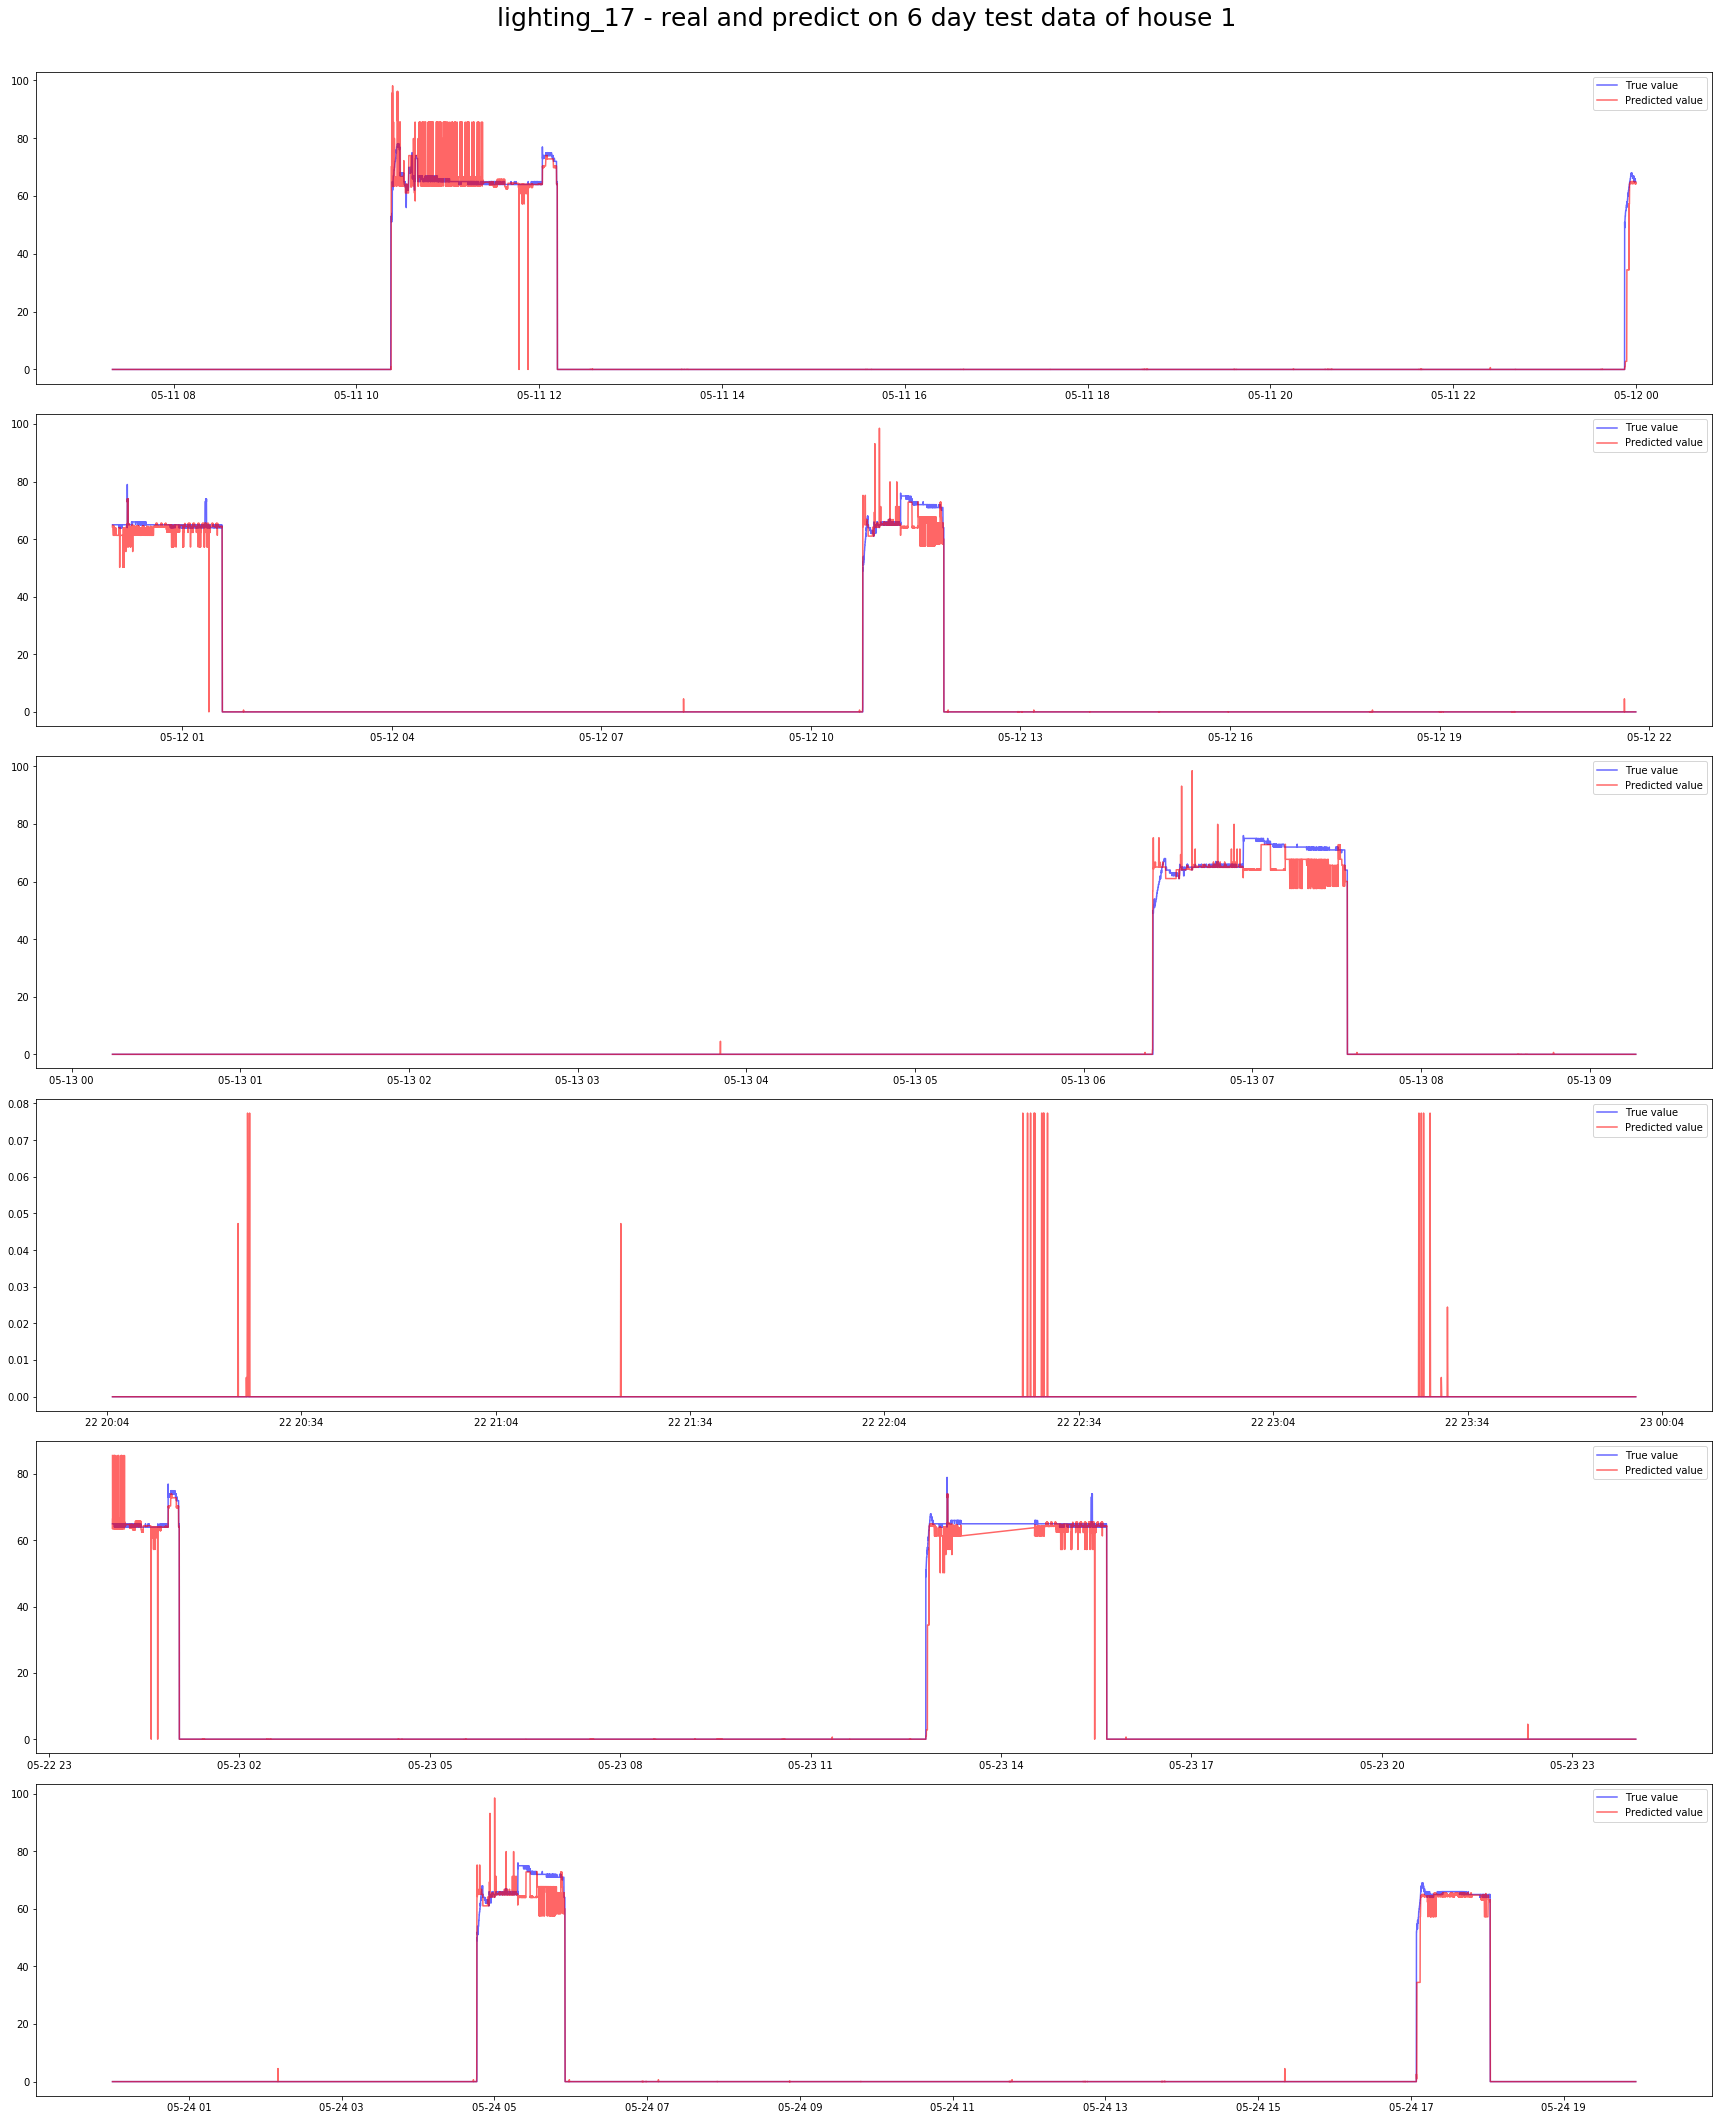

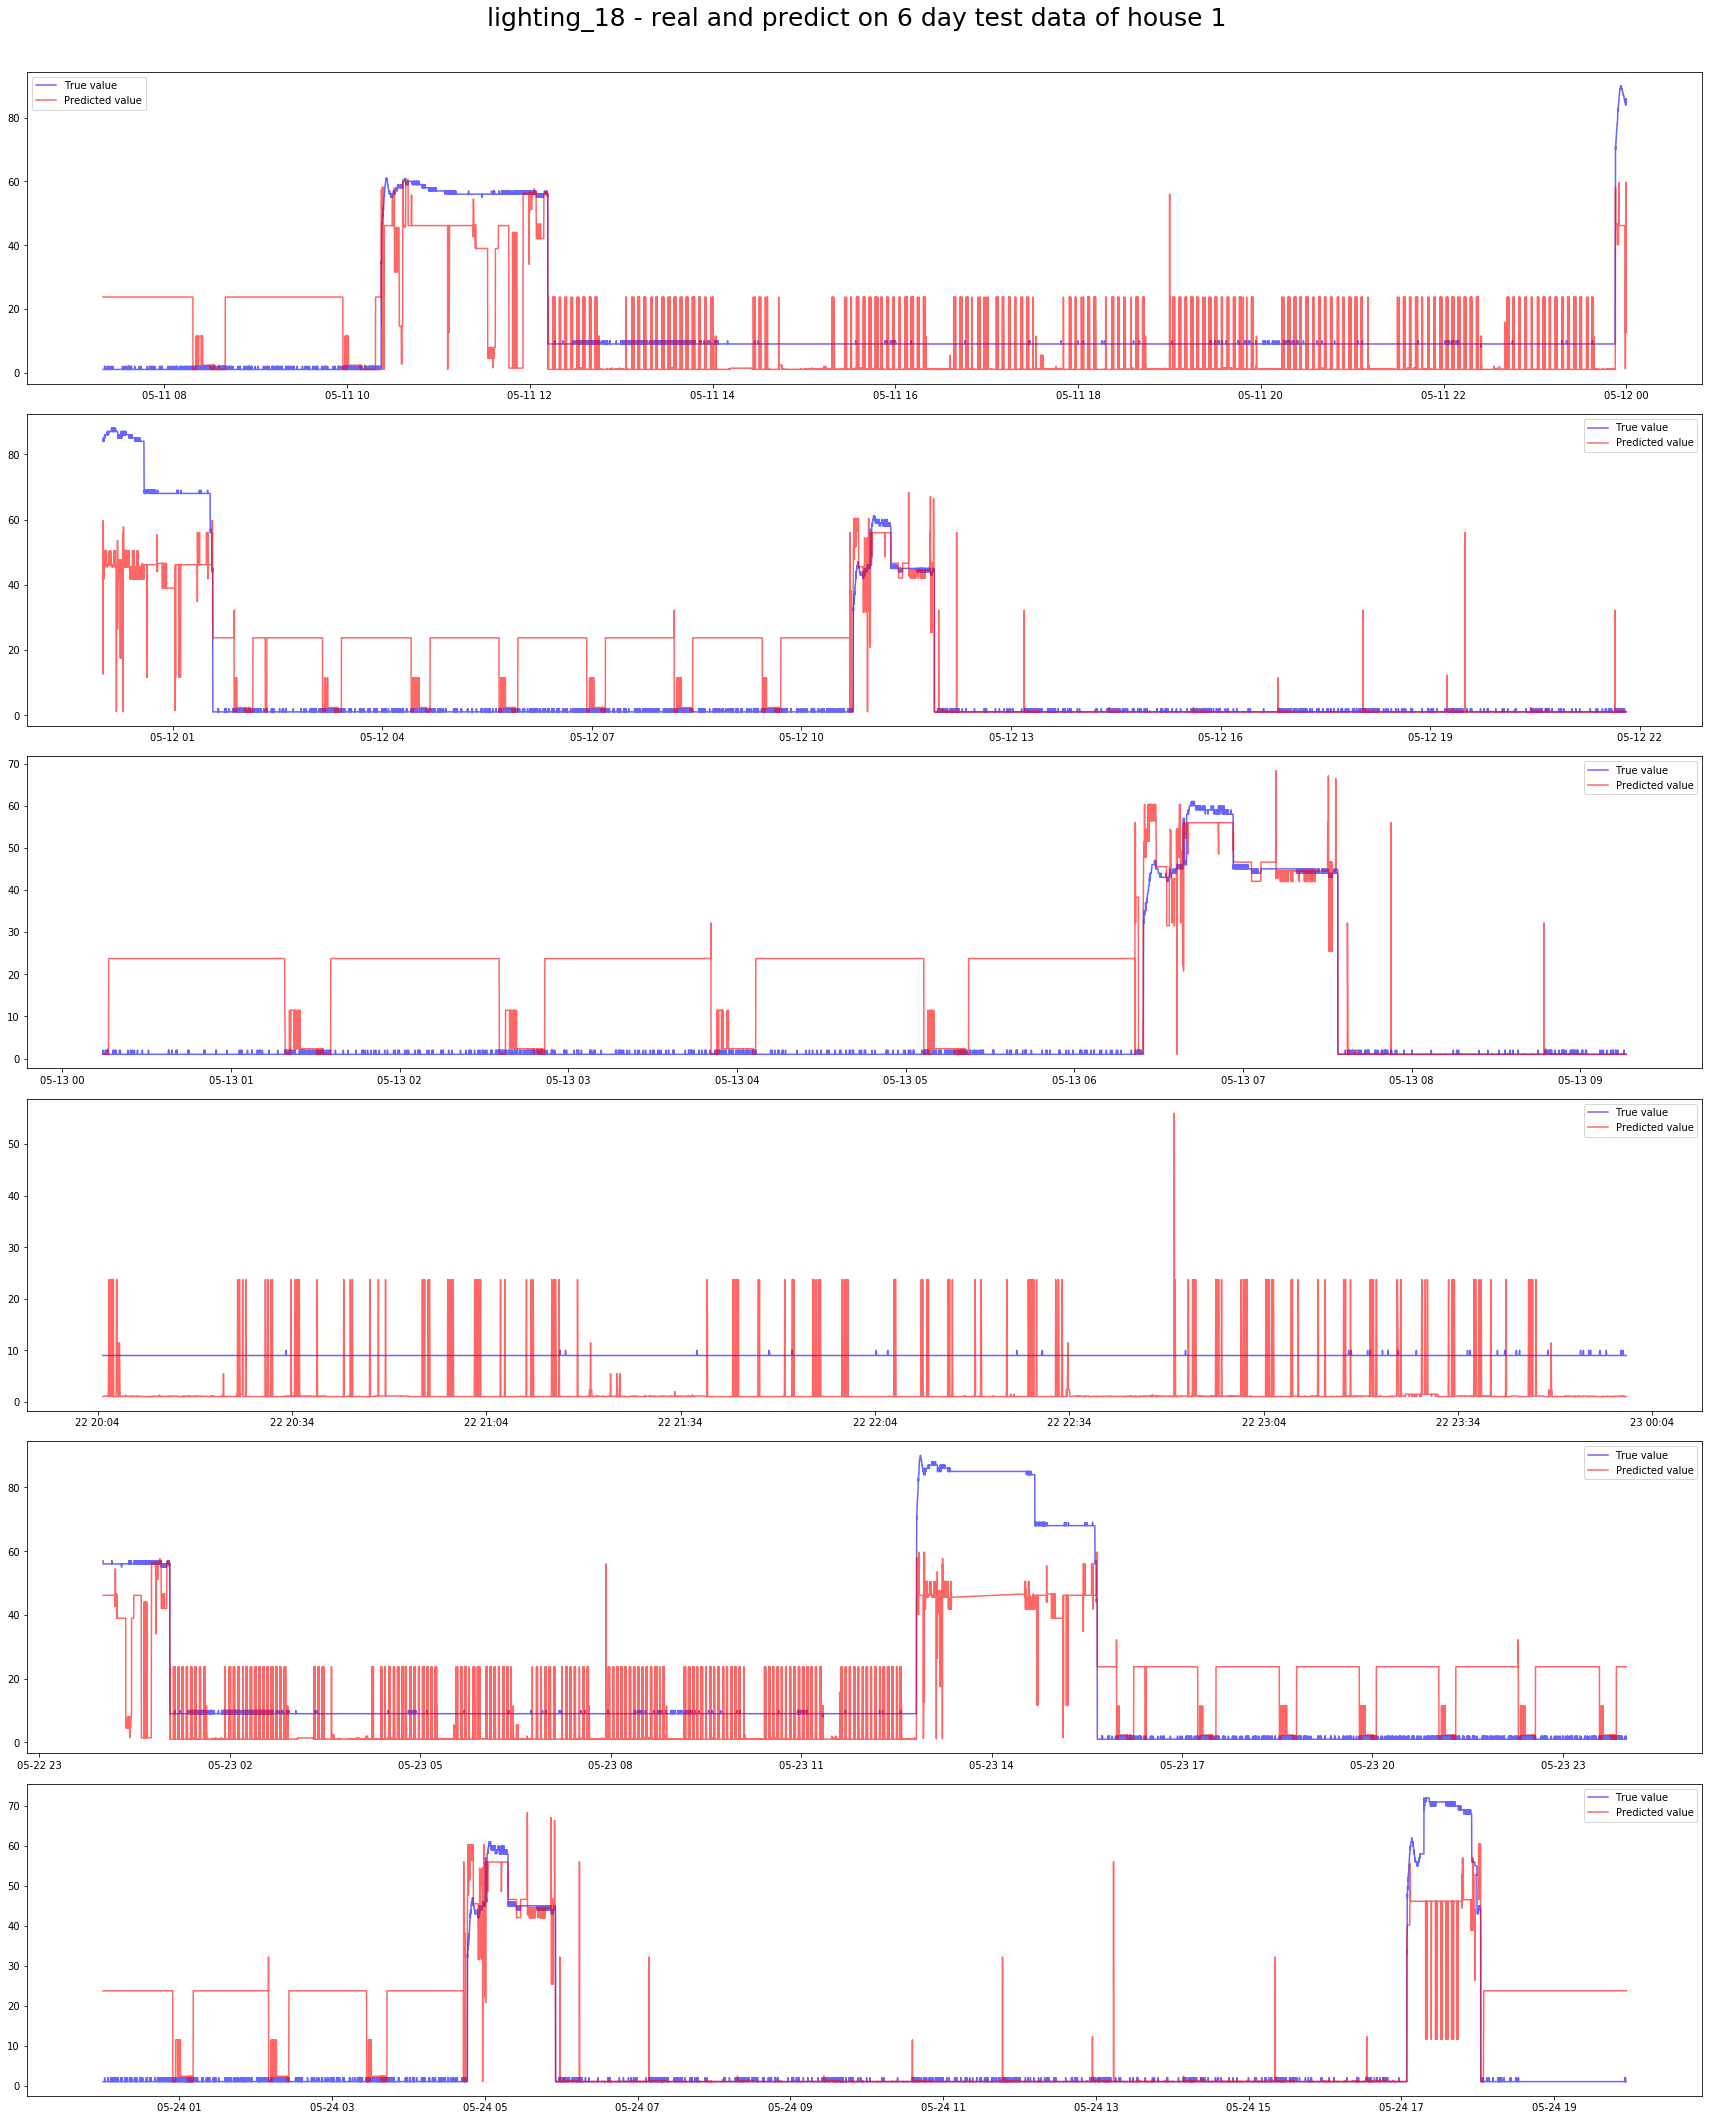

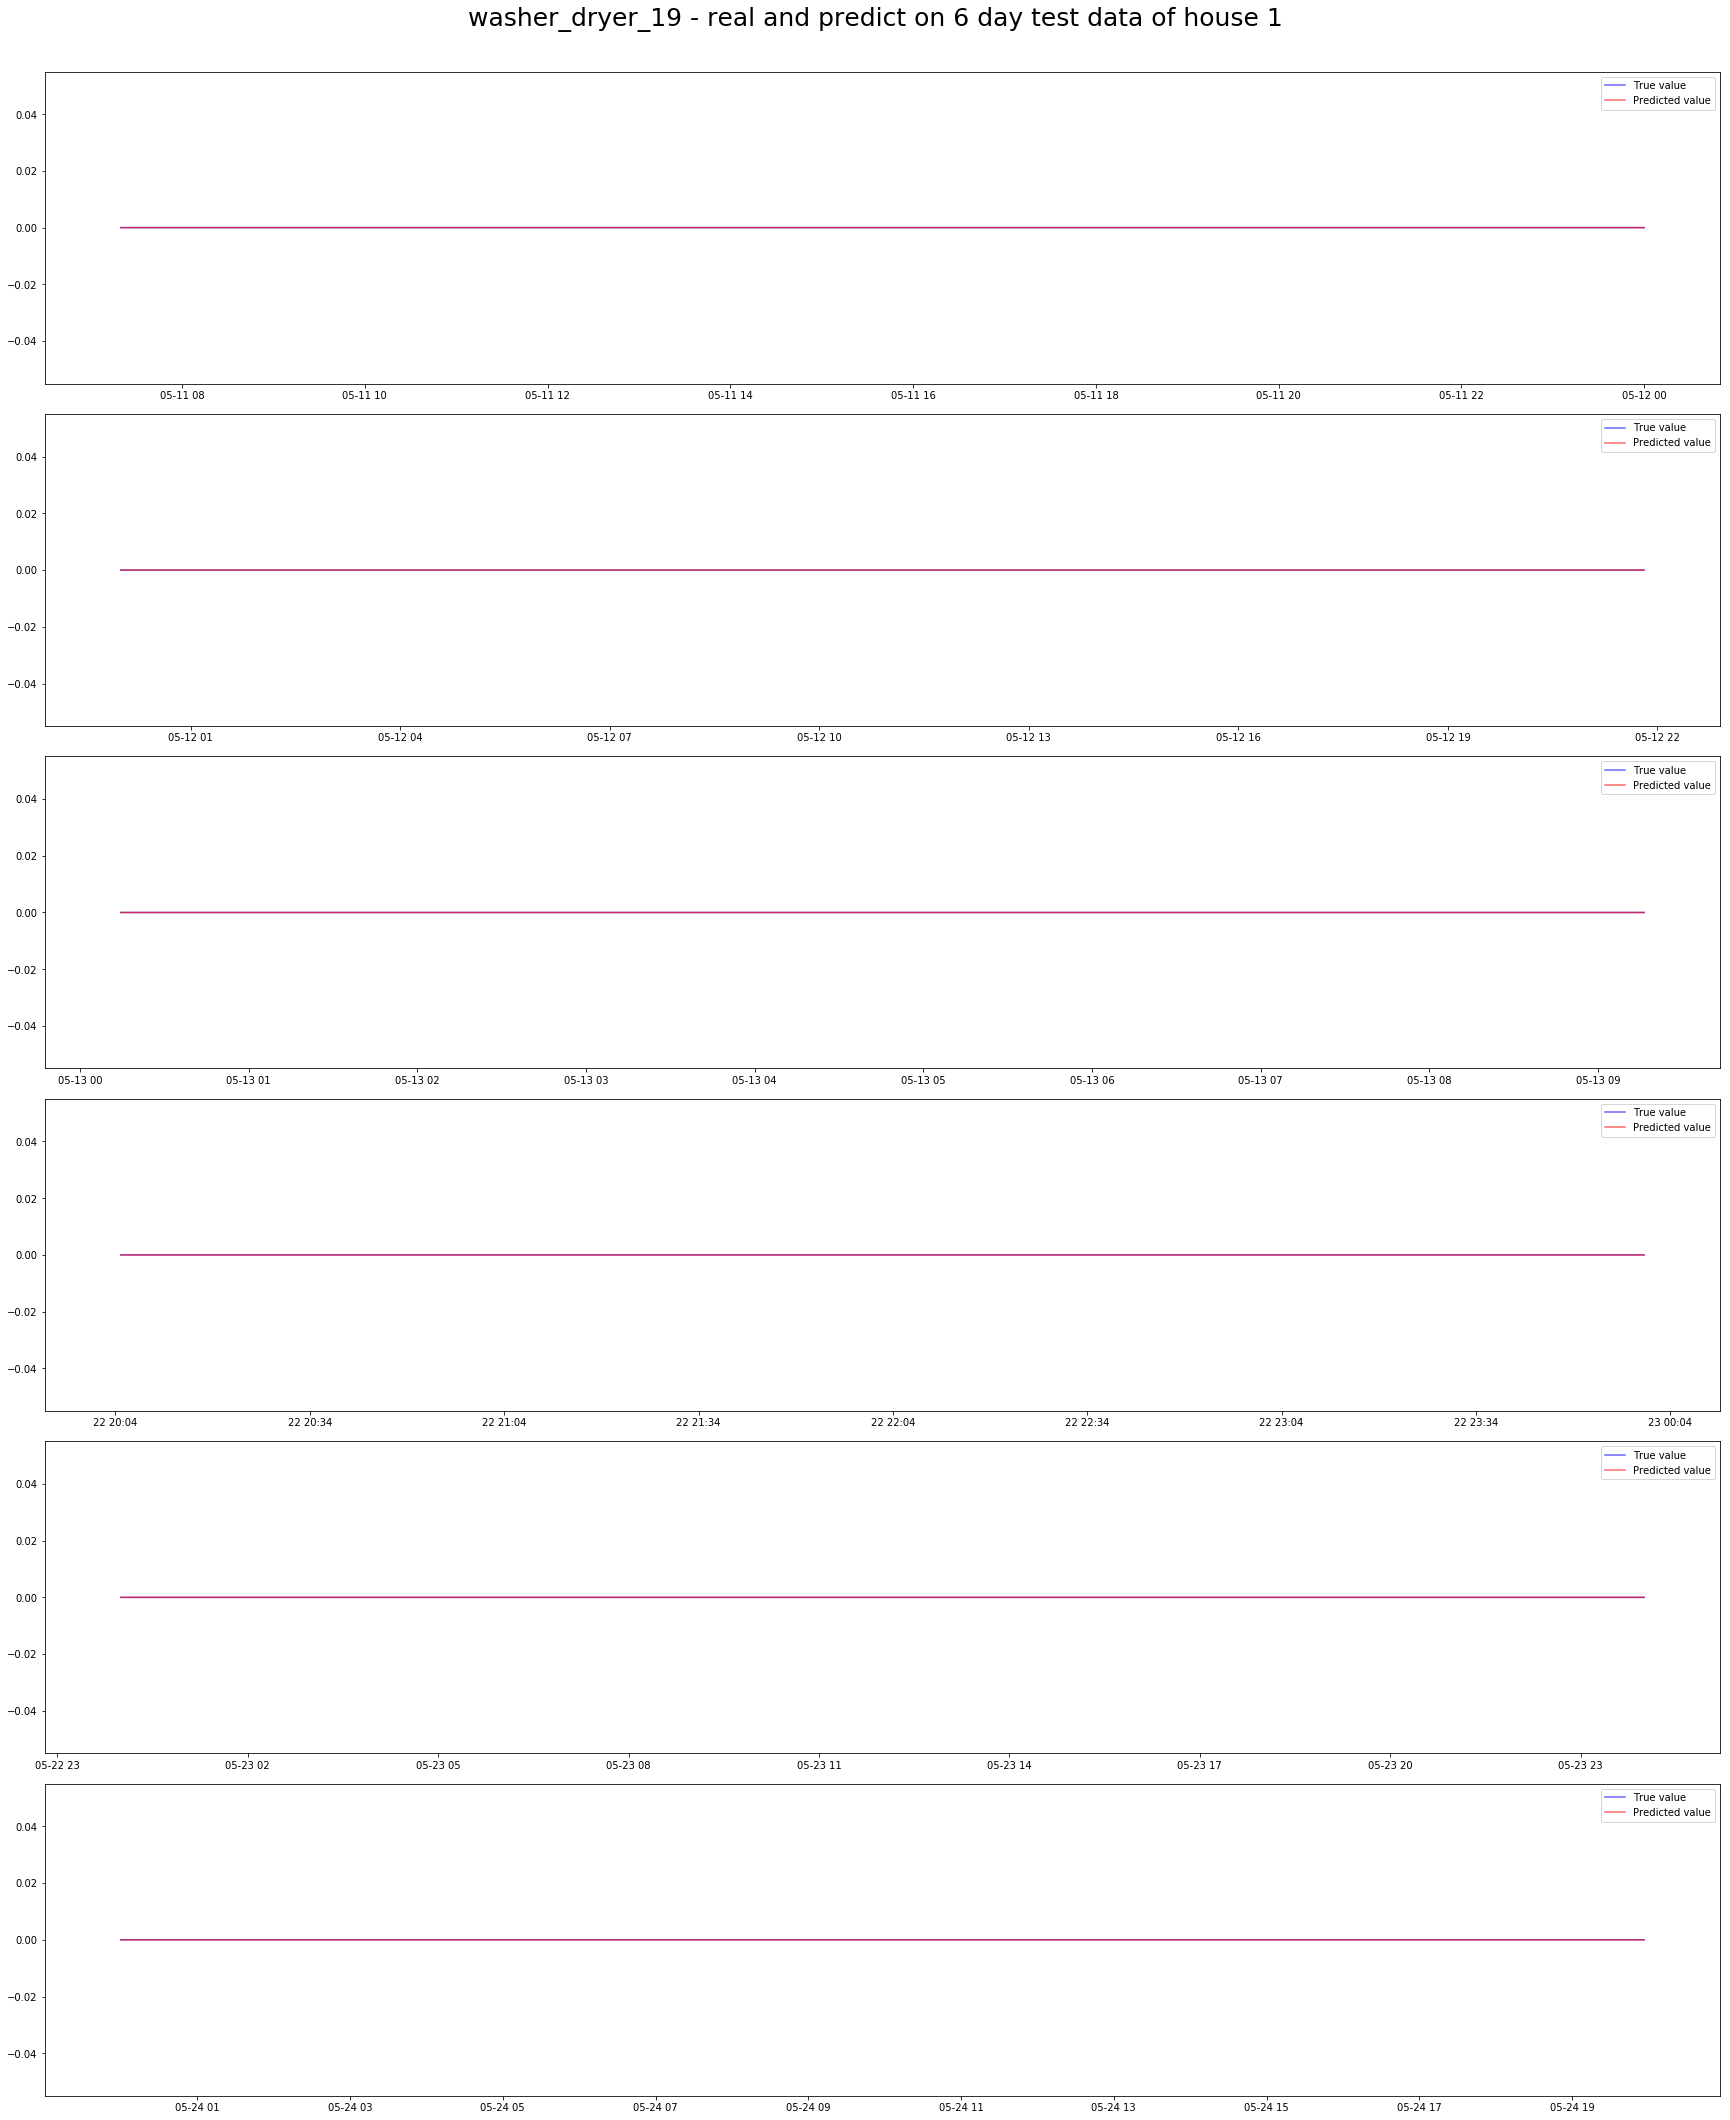

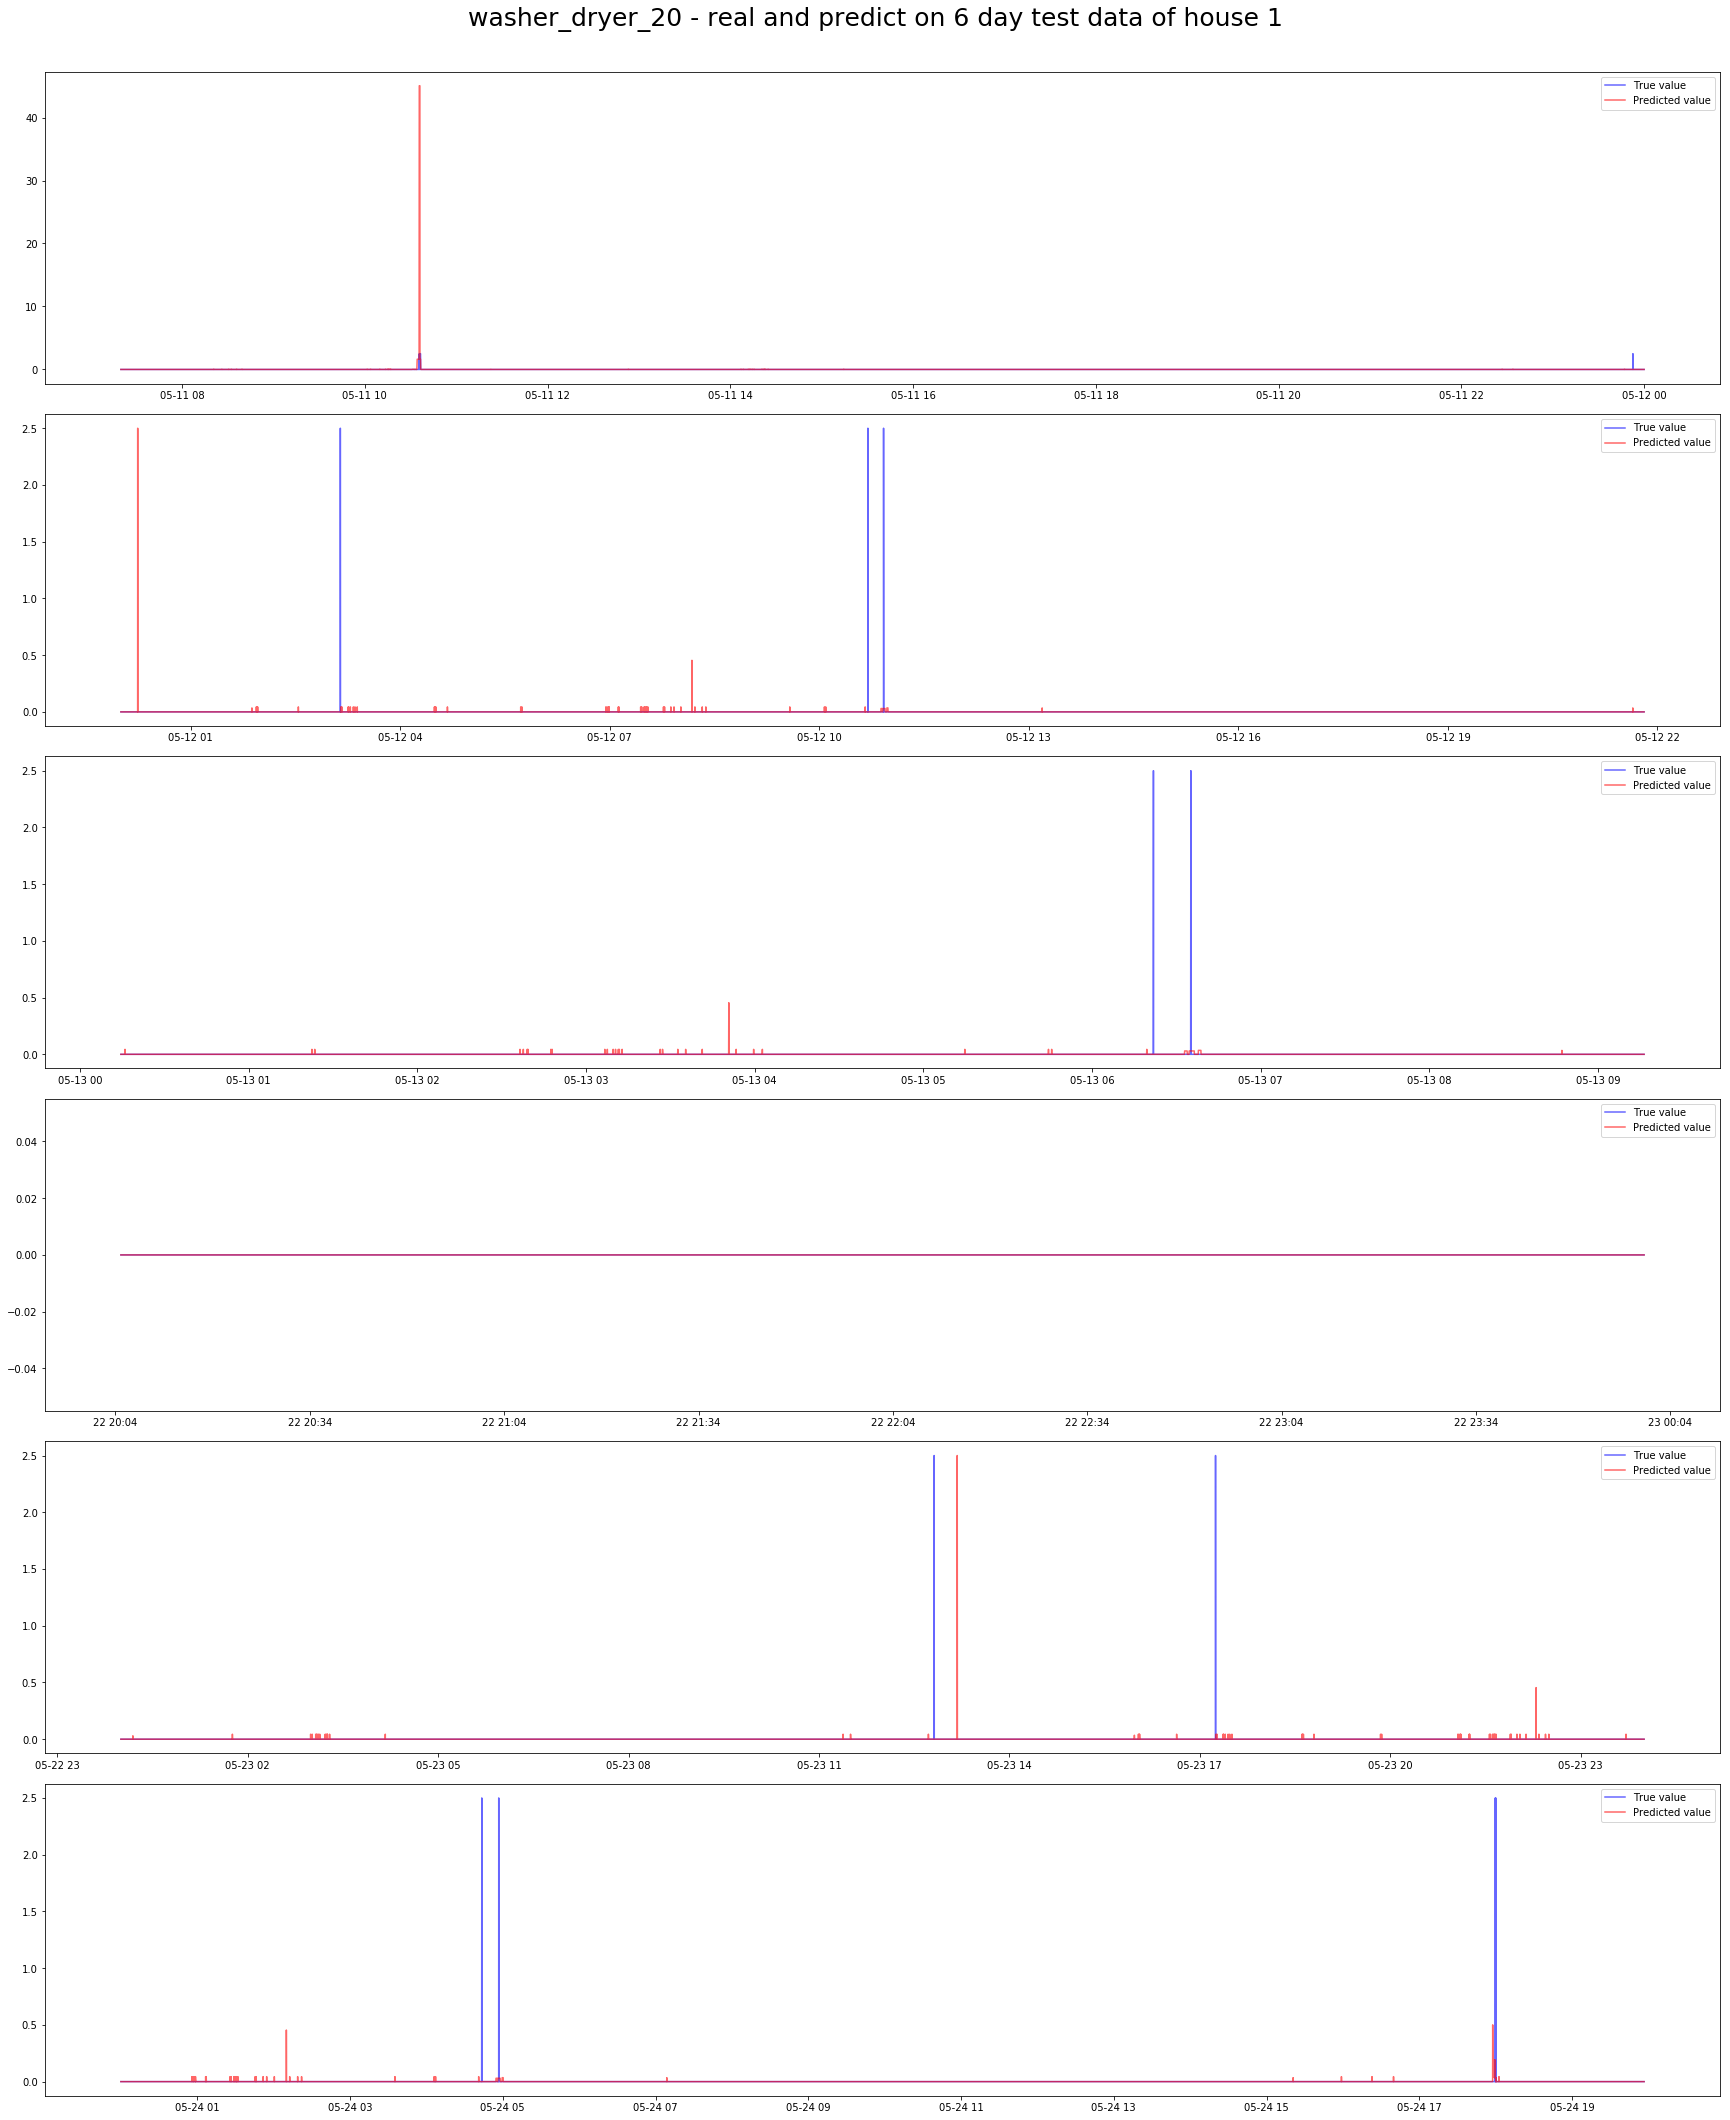

In [35]:
for app in appliances:
    plot_each_app(df1_test, dates[1][17:], mul_pred[app], df1_test[app].values, 
                  '{} - real and predict on 6 day test data of house 1'.format(app))

### Now, let's try fully connected neural network
#### For faster implementation, we use keras API with TensorFlow backend 

In [15]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [16]:
def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        fc_model.add( Dense(input_dim=layers[i], output_dim= layers[i+1]) )#, W_regularizer=l2(0.1)) )
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    return fc_model
fc_model_1 = build_fc_model([2, 256, 512, 1024, 1536, 2048, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
__________

In [17]:
adam = Adam(lr = 1e-5)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
#start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1,
                    batch_size=512, verbose=1, nb_epoch=200,
                    validation_split=0.33, callbacks=[checkpointer])
np.savetxt("dnn-train.txt", X_train1)
np.savetxt("dnn-train-label.txt", X_train1)
#print('Finish trainning. Time: ', time.time() - start)

Train on 143926 samples, validate on 70890 samples
Epoch 1/200
143926/143926 [==============================] - 159s 1ms/step - loss: 12096.2931 - val_loss: 10408.8752
Epoch 2/200
143926/143926 [==============================] - 158s 1ms/step - loss: 11426.9861 - val_loss: 10395.0643
Epoch 3/200
143926/143926 [==============================] - 159s 1ms/step - loss: 10991.4823 - val_loss: 10414.4035
Epoch 4/200
143926/143926 [==============================] - 162s 1ms/step - loss: 10709.7573 - val_loss: 10416.1063
Epoch 5/200
143926/143926 [==============================] - 164s 1ms/step - loss: 10410.2429 - val_loss: 10327.9279
Epoch 6/200
143926/143926 [==============================] - 162s 1ms/step - loss: 10294.9088 - val_loss: 10243.9304
Epoch 7/200
143926/143926 [==============================] - 165s 1ms/step - loss: 10210.9943 - val_loss: 10303.7077
Epoch 8/200
143926/143926 [==============================] - 164s 1ms/step - loss: 10053.4503 - val_loss: 10242.6415
Epoch 9/200
1

143926/143926 [==============================] - 164s 1ms/step - loss: 8525.6742 - val_loss: 8792.7691
Epoch 141/200
143926/143926 [==============================] - 164s 1ms/step - loss: 8556.4013 - val_loss: 8817.0234
Epoch 142/200
143926/143926 [==============================] - 164s 1ms/step - loss: 8575.8173 - val_loss: 8813.7277
Epoch 143/200
143926/143926 [==============================] - 165s 1ms/step - loss: 8585.2740 - val_loss: 8807.5355
Epoch 144/200
143926/143926 [==============================] - 166s 1ms/step - loss: 8528.2338 - val_loss: 8801.2545
Epoch 145/200
143926/143926 [==============================] - 166s 1ms/step - loss: 8588.6901 - val_loss: 8791.0266
Epoch 146/200
143926/143926 [==============================] - 167s 1ms/step - loss: 8532.3237 - val_loss: 8832.9143
Epoch 147/200
143926/143926 [==============================] - 162s 1ms/step - loss: 8541.0408 - val_loss: 8772.4131
Epoch 148/200
143926/143926 [==============================] - 165s 1ms/step -

In [19]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 
fc_model_1 = load_model('fc_refrig_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)


('Mean square error on test set: ', 9323.3351778950691)
('Mean absolute error on the test set: ', 54.050057917854893)


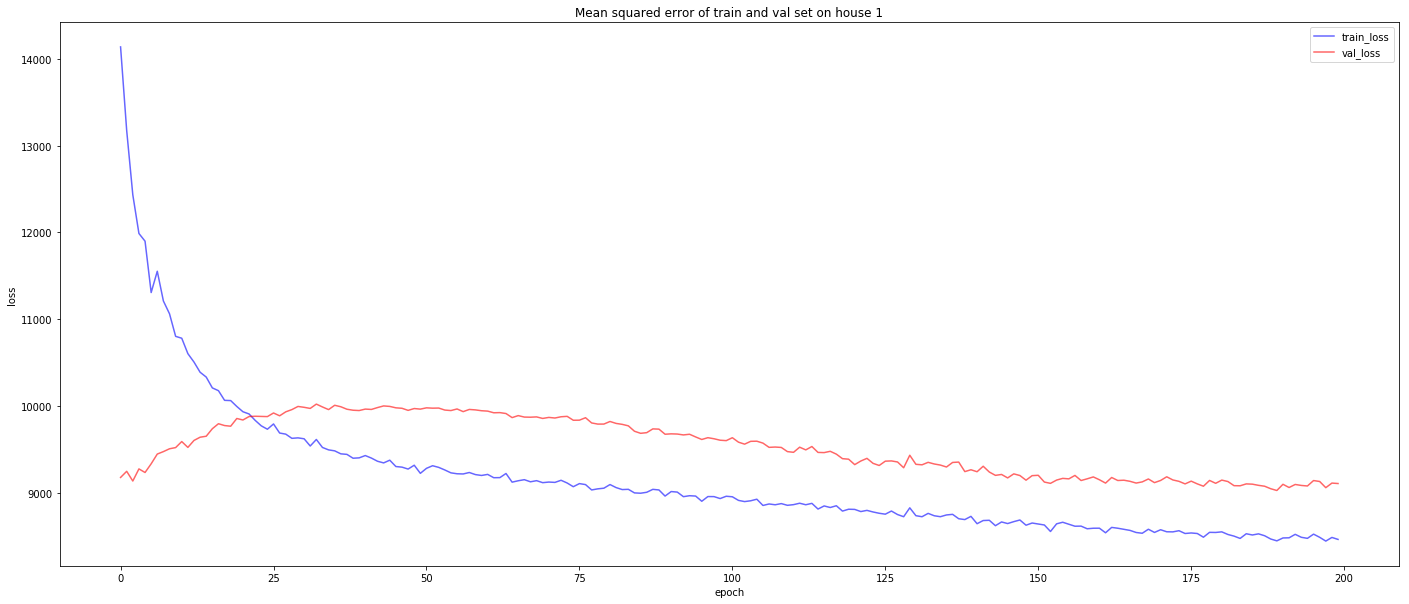

In [82]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

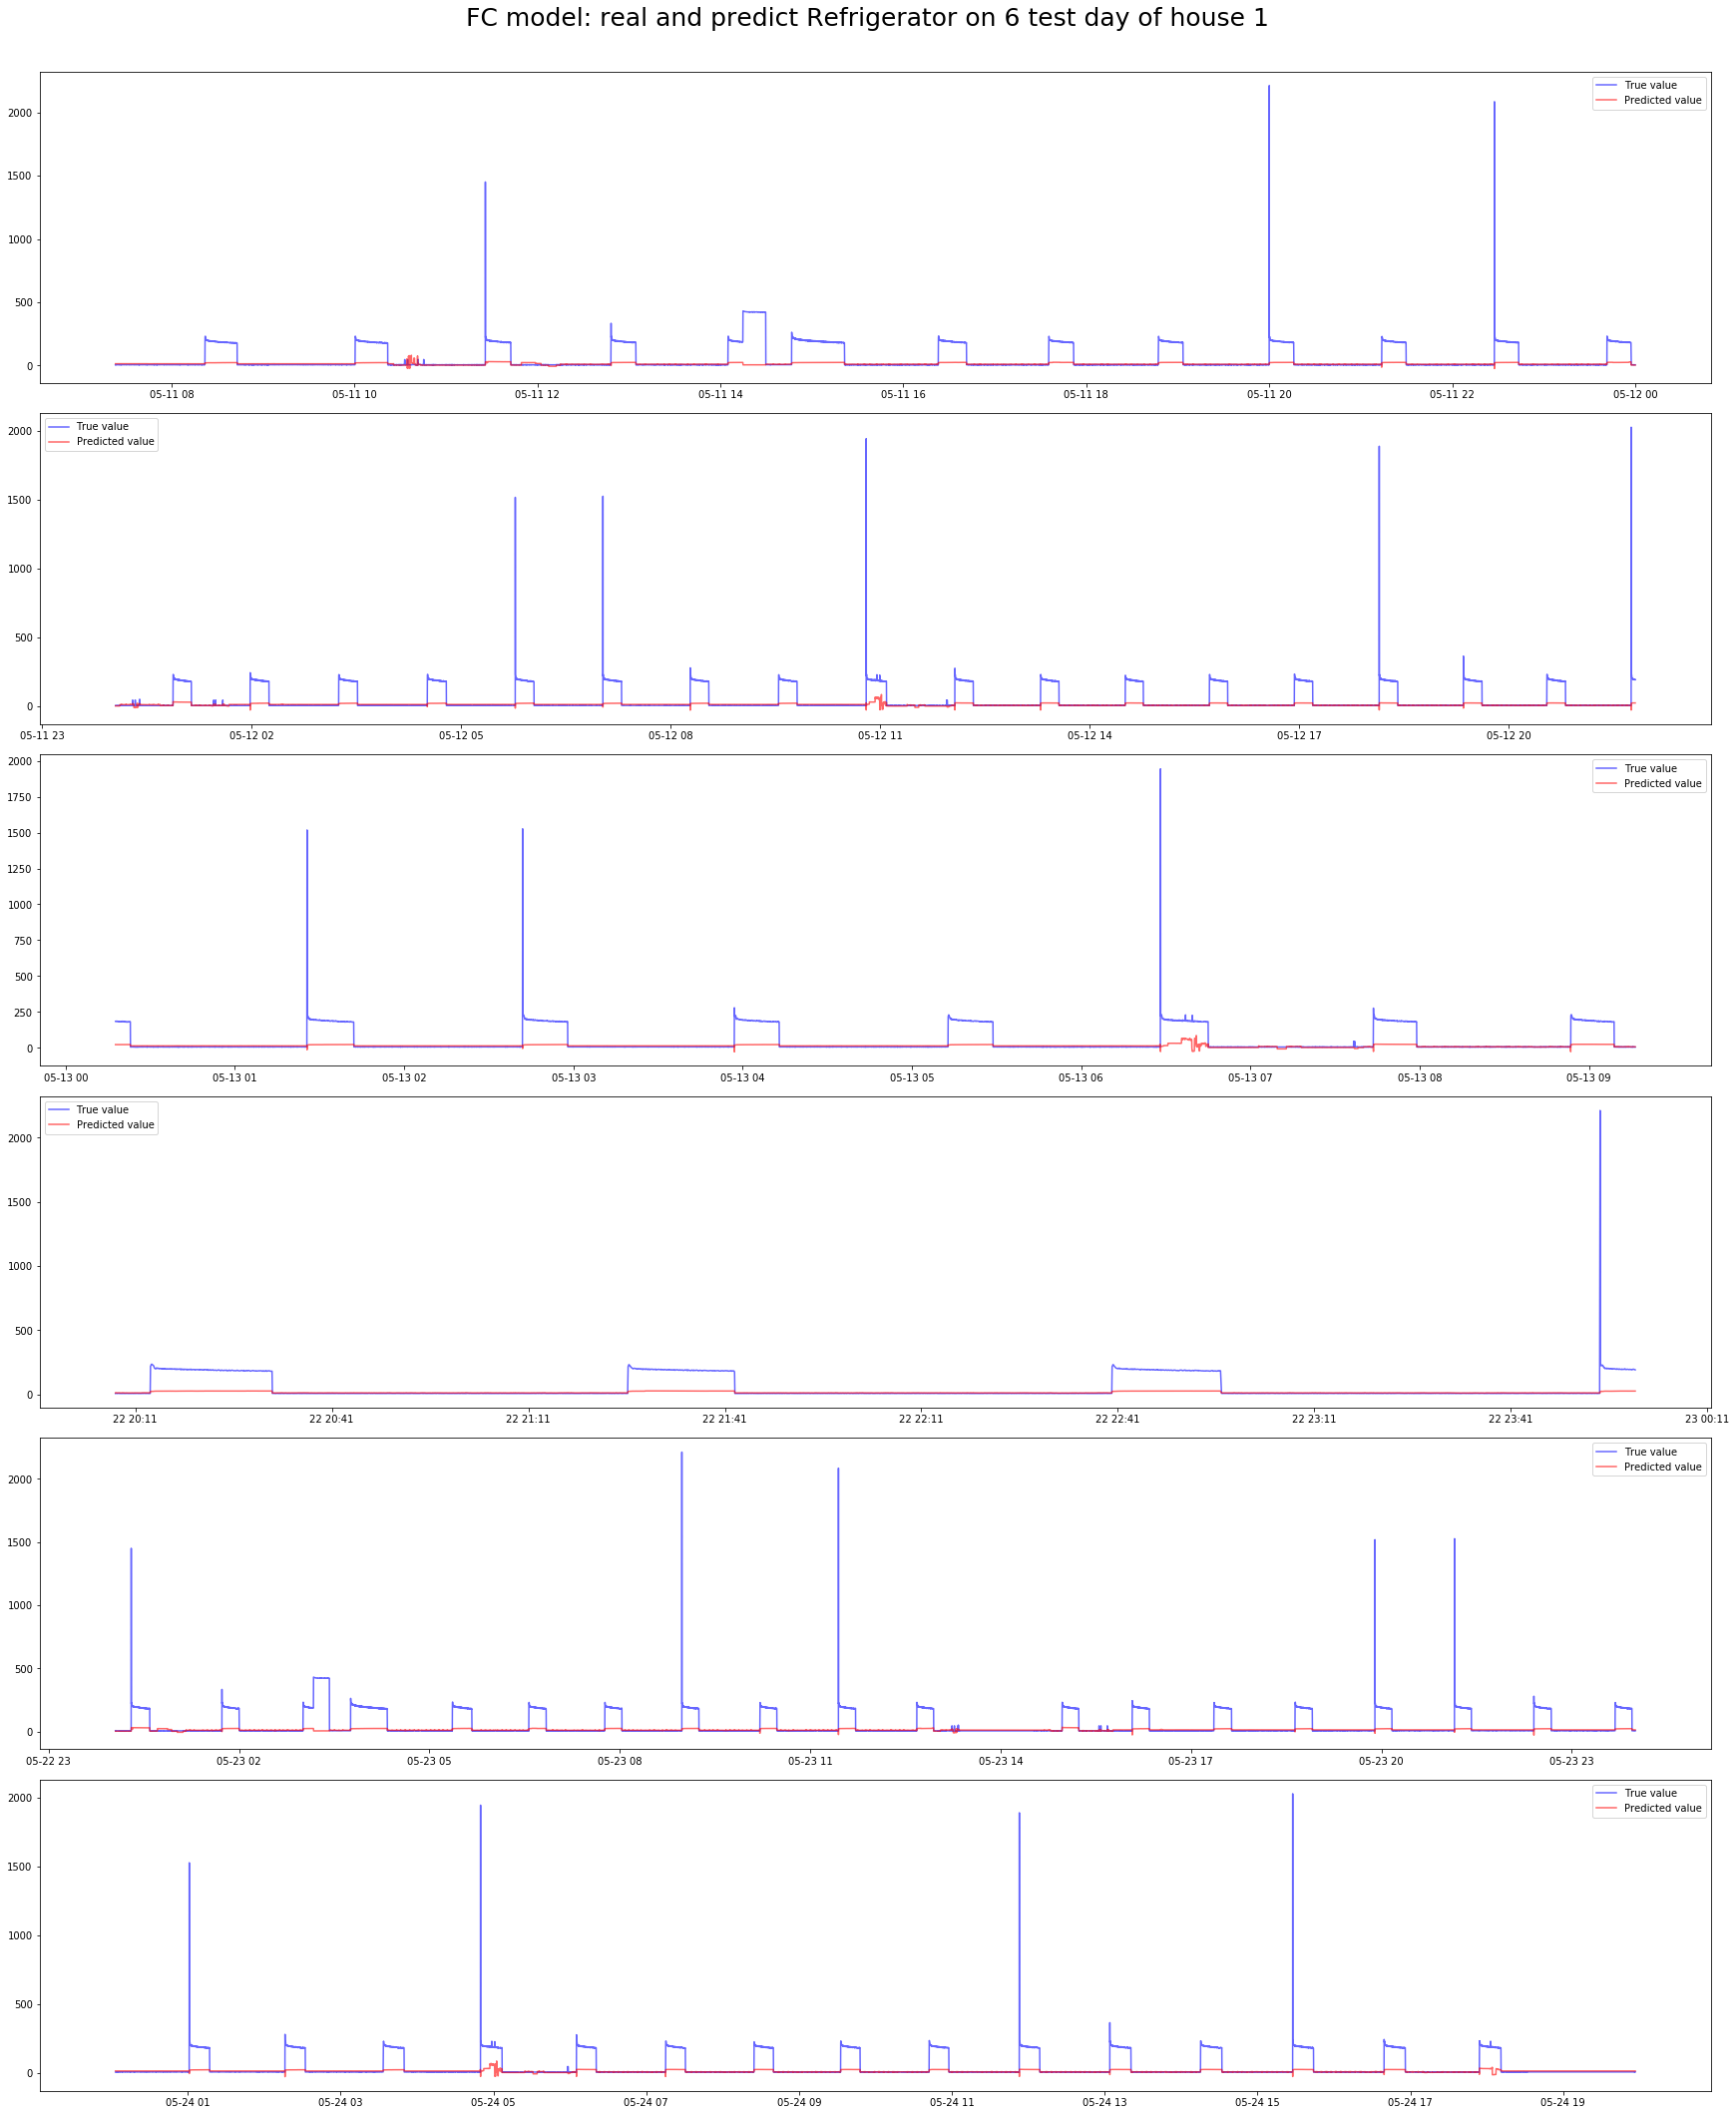

In [83]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1, 
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Use this model on house 2

In [84]:
y_pred_fc_2 = fc_model_1.predict(X_2).reshape(-1)
mse_fc_2 = mse_loss(y_pred_fc_2, y_2)
mae_fc_2 = mae_loss(y_pred_fc_2, y_2)
print('Mean square error on test set: ', mse_fc_2)
print('Mean absolute error on the test set: ', mae_fc_2)

('Mean square error on test set: ', 13113.921827223976)
('Mean absolute error on the test set: ', 75.358820687763213)


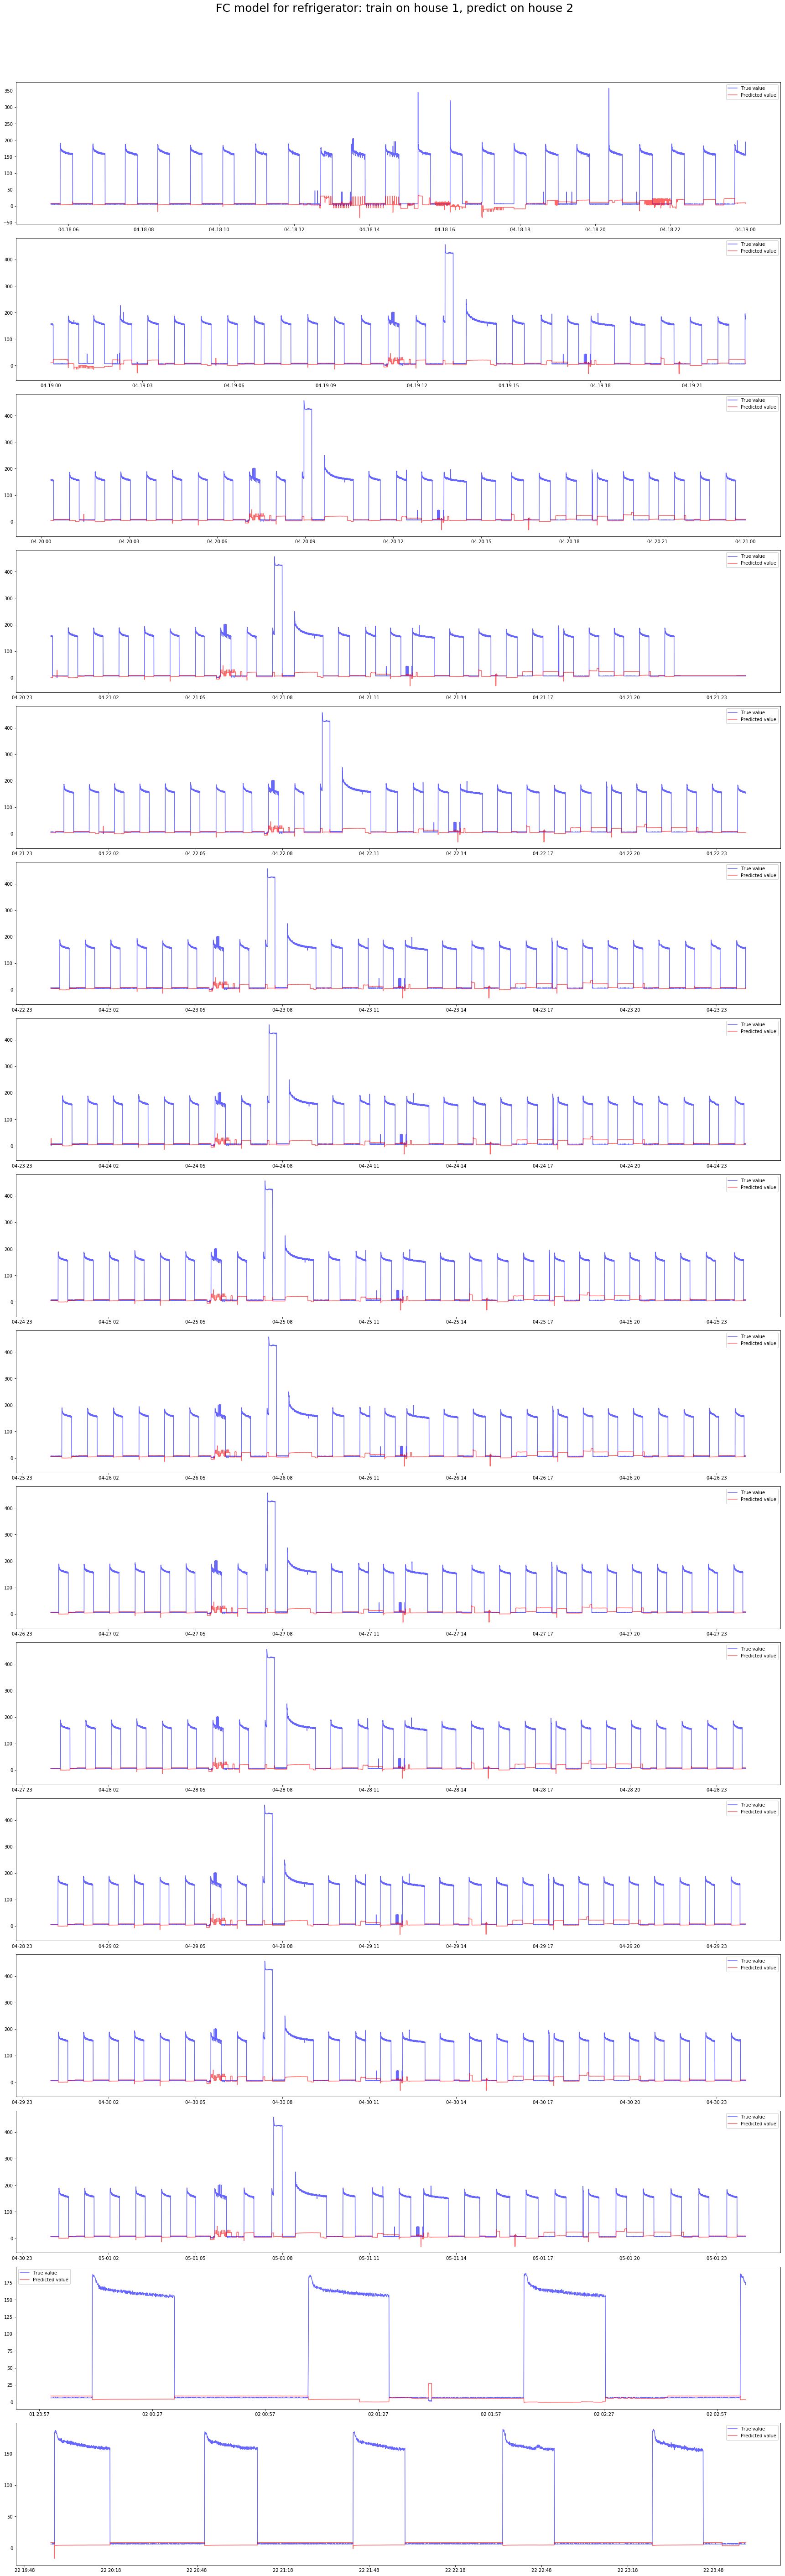

In [85]:
plot_each_app(df[2], dates[2], y_pred_fc_2, y_2, 'FC model for refrigerator: train on house 1, predict on house 2')

### Let's use 50 consecutive total consumtions to predict energy consumption of each appliance

In [86]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        print(dates)
        data = df.ix[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(x, x, axis=0)
            Y = np.append(y, y, axis=0)
        i += 1
    return X,Y

In [87]:
start = datetime.time()

X_train, y_train = process_data(df[1], dates[1][:17], ['mains_1','mains_2'], df[1].columns.values[2:])
X_test, y_test = process_data(df[1], dates[1][17:], ['mains_1','mains_2'], df[1].columns.values[2:])
#print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07']
['2011-04-18', '2011-04-19', '2011-04-20', '

#### Let's use fully connected neural network again, but this time we use the past 50 consecutive main values to predict the present value of refrigerator


In [88]:
fc_model = build_fc_model([100, 256, 512, 1024, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               25856     
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_21 (Dropout)         (None, 512)               0         
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              525312    
__________

In [89]:
# Let's flatten data to feed into fc model
X_train_fc = X_train.reshape(-1, 100)
y_train_fc = y_train[:,2]
print(X_train_fc.shape, y_train_fc.shape)

((28866, 100), (28866,))


In [91]:
adam = Adam(lr = 1e-5)
fc_model.compile(loss='mean_squared_error', optimizer=adam)
#start = datetime.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1.hdf5", verbose=0, save_best_only=True)
hist_fc2 = fc_model.fit( X_train_fc, y_train_fc,
                    batch_size=512, verbose=1, nb_epoch= 200,
                    validation_split=0.33, callbacks=[checkpointer])
#print('Finish trainning. Time: ', datetime.time() - start)

Train on 19340 samples, validate on 9526 samples
Epoch 1/200
19340/19340 [==============================] - 5s 261us/step - loss: 11601.5916 - val_loss: 7560.4592
Epoch 2/200
19340/19340 [==============================] - 4s 219us/step - loss: 11654.8515 - val_loss: 7510.9361
Epoch 3/200
19340/19340 [==============================] - 4s 204us/step - loss: 11144.7745 - val_loss: 7630.3223
Epoch 4/200
19340/19340 [==============================] - 4s 208us/step - loss: 11335.7013 - val_loss: 7729.0899
Epoch 5/200
19340/19340 [==============================] - 4s 196us/step - loss: 11538.0860 - val_loss: 7761.2037
Epoch 6/200
19340/19340 [==============================] - 4s 200us/step - loss: 11599.9185 - val_loss: 7857.4012
Epoch 7/200
19340/19340 [==============================] - 4s 197us/step - loss: 10636.5022 - val_loss: 7814.4649
Epoch 8/200
19340/19340 [==============================] - 3s 179us/step - loss: 10778.6349 - val_loss: 7682.9370
Epoch 9/200
19340/19340 [==============

19340/19340 [==============================] - 4s 195us/step - loss: 7889.9231 - val_loss: 7103.8763
Epoch 144/200
19340/19340 [==============================] - 4s 206us/step - loss: 7676.3567 - val_loss: 7103.6058
Epoch 145/200
19340/19340 [==============================] - 4s 208us/step - loss: 7689.9921 - val_loss: 7120.1159
Epoch 146/200
19340/19340 [==============================] - 4s 182us/step - loss: 7941.0119 - val_loss: 7134.4869
Epoch 147/200
19340/19340 [==============================] - 4s 205us/step - loss: 7773.0102 - val_loss: 7130.9588
Epoch 148/200
19340/19340 [==============================] - 4s 211us/step - loss: 7849.1386 - val_loss: 7160.4690
Epoch 149/200
19340/19340 [==============================] - 4s 202us/step - loss: 7667.5209 - val_loss: 7127.8331
Epoch 150/200
19340/19340 [==============================] - 4s 208us/step - loss: 7577.8234 - val_loss: 7068.4696
Epoch 151/200
19340/19340 [==============================] - 4s 197us/step - loss: 7705.6400 -

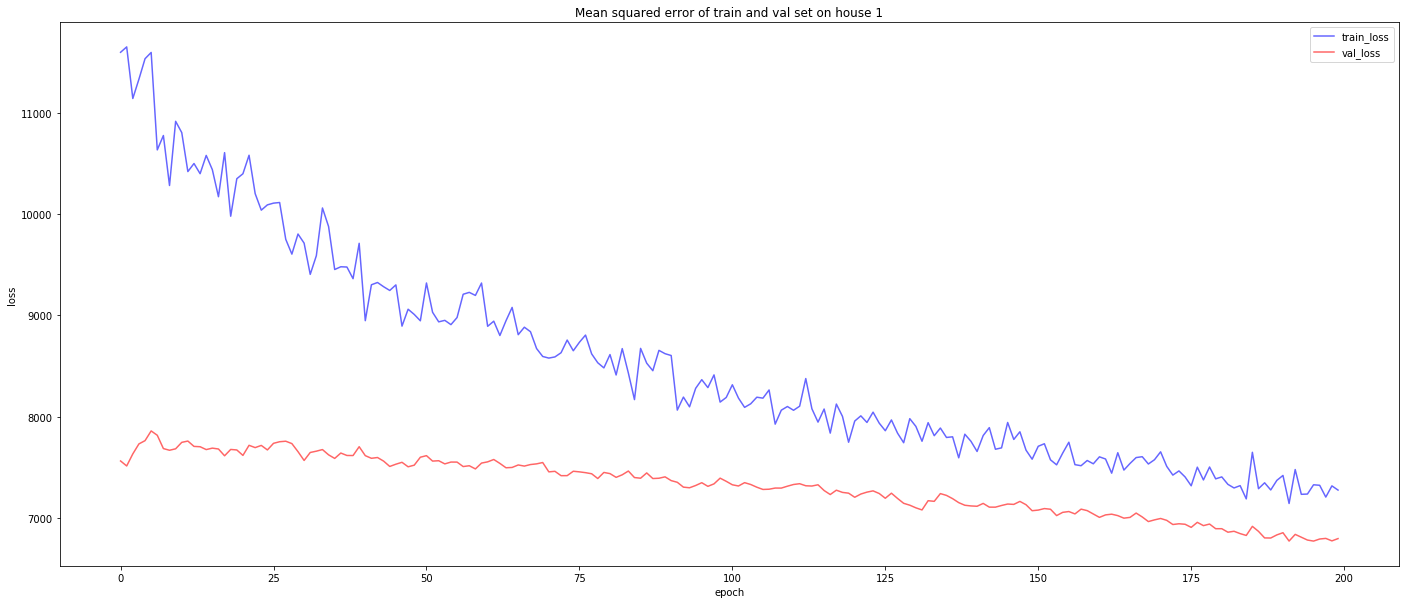

In [92]:
train_loss = hist_fc2.history['loss']
val_loss = hist_fc2.history['val_loss']

plot_losses(train_loss, val_loss)

In [94]:
fc_model = load_model('fc_refrig_h1.hdf5')
pred_fc = fc_model.predict(X_test.reshape(-1, 100)).reshape(-1)
print(pred_fc.shape)

(34456,)


In [96]:
mse_loss_fc = mse_loss(pred_fc, y_test[:,2])
mae_loss_fc = mae_loss(pred_fc, y_test[:,2])
print('Mean square error on test set: ', mse_loss_fc)
print('Mean absolute error on the test set: ', mae_loss_fc)

('Mean square error on test set: ', 6697.3248581207608)
('Mean absolute error on the test set: ', 42.501609485150112)


In [97]:
print(pred_fc.shape)
print(y_test[:,2].shape)
print(dates[1][17:])
print(df1_test.shape)
#plot_each_app(df1_test, dates[1][17:], pred_fc, y_test[:,2], 
#              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

(34456,)
(34456,)
['2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24']
(87057, 20)


#### Test on house 2

In [98]:
#start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['mains_2','mains_1'], ['refrigerator_9'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
#print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22']
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '

In [101]:
pred_fc_50_h2 = fc_model.predict(X_2_fc).reshape(-1)
mse_loss_fc_50_2 = mse_loss(pred_fc_50_h2, y_2)
mae_loss_fc_50_2 = mae_loss(pred_fc_50_h2, y_2)
print('Mean square error on test set: ', mse_loss_fc_50_2)
print('Mean absolute error on the test set: ', mae_loss_fc_50_2)

('Mean square error on test set: ', 20147.373198723024)
('Mean absolute error on the test set: ', 90.720597319541994)


ValueError: x and y must have same first dimension, but have shapes (17640,) and (7606,)

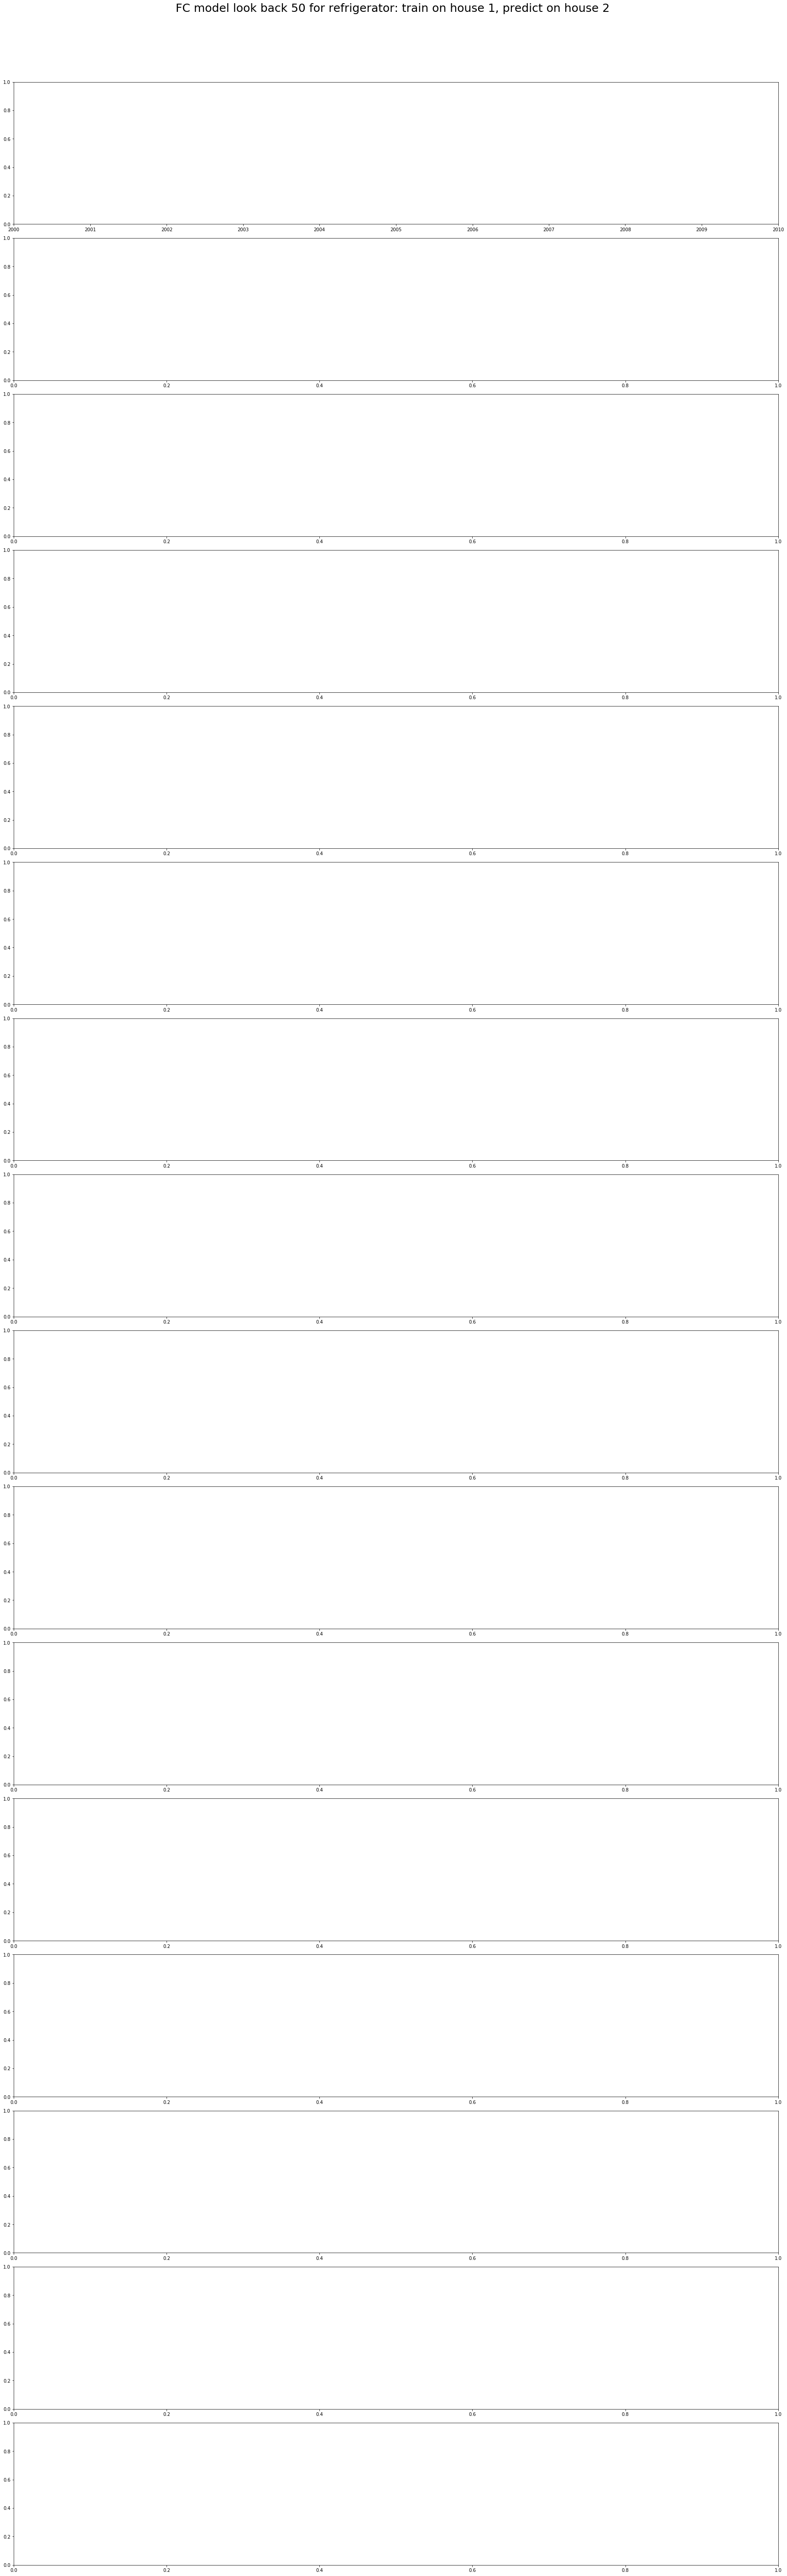

In [100]:
plot_each_app(df[2], dates[2], pred_fc_50_h2, y_2, 'FC model look back 50 for refrigerator: train on house 1, predict on house 2')

### Long term short term memory neural network
#### Now we will try a type of recurrent neural network called long term short term memory model

In [102]:
def build_lstm_model(layers):
    model = Sequential()
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            output_dim=layers[i+1], 
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))
    
    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 64)          17152     
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
dropout_25 (Dropout)         (None, None, 128)         0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 257       
Total para

In [103]:
#start = time.time()

print(X_train.shape)
print(y_train[:,2].shape)


adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train[:,2],
            batch_size=512,
            verbose=1,
            nb_epoch=200,
            validation_split=0.3,
            callbacks=[checkpointer])

#print('Finish trainning. Time: ', time.time() - start)

(28866, 50, 2)
(28866,)
Train on 20206 samples, validate on 8660 samples
Epoch 1/200
20206/20206 [==============================] - 149s 7ms/step - loss: 8711.7527 - val_loss: 9473.2453
Epoch 2/200
20206/20206 [==============================] - 147s 7ms/step - loss: 8212.0146 - val_loss: 8751.0006
Epoch 3/200
20206/20206 [==============================] - 149s 7ms/step - loss: 7693.1853 - val_loss: 8345.0578
Epoch 4/200
20206/20206 [==============================] - 146s 7ms/step - loss: 7379.0031 - val_loss: 8127.6823
Epoch 5/200
20206/20206 [==============================] - 148s 7ms/step - loss: 7260.8656 - val_loss: 8055.4333
Epoch 6/200
20206/20206 [==============================] - 147s 7ms/step - loss: 7207.5187 - val_loss: 8008.1141
Epoch 7/200
20206/20206 [==============================] - 149s 7ms/step - loss: 7168.2624 - val_loss: 7968.7253
Epoch 8/200
20206/20206 [==============================] - 148s 7ms/step - loss: 7135.8554 - val_loss: 7935.2767
Epoch 9/200
20206/20206

20206/20206 [==============================] - 147s 7ms/step - loss: 2978.6573 - val_loss: 3588.1032
Epoch 144/200
20206/20206 [==============================] - 148s 7ms/step - loss: 2953.9491 - val_loss: 3565.6571
Epoch 145/200
20206/20206 [==============================] - 147s 7ms/step - loss: 2956.0986 - val_loss: 3556.6196
Epoch 146/200
20206/20206 [==============================] - 148s 7ms/step - loss: 2926.5656 - val_loss: 3536.1821
Epoch 147/200
20206/20206 [==============================] - 148s 7ms/step - loss: 2899.2909 - val_loss: 3509.8315
Epoch 148/200
20206/20206 [==============================] - 147s 7ms/step - loss: 2875.7286 - val_loss: 3487.6169
Epoch 149/200
20206/20206 [==============================] - 148s 7ms/step - loss: 2852.9050 - val_loss: 3464.7201
Epoch 150/200
20206/20206 [==============================] - 148s 7ms/step - loss: 2838.8782 - val_loss: 3444.3385
Epoch 151/200
20206/20206 [==============================] - 147s 7ms/step - loss: 2825.2860 -

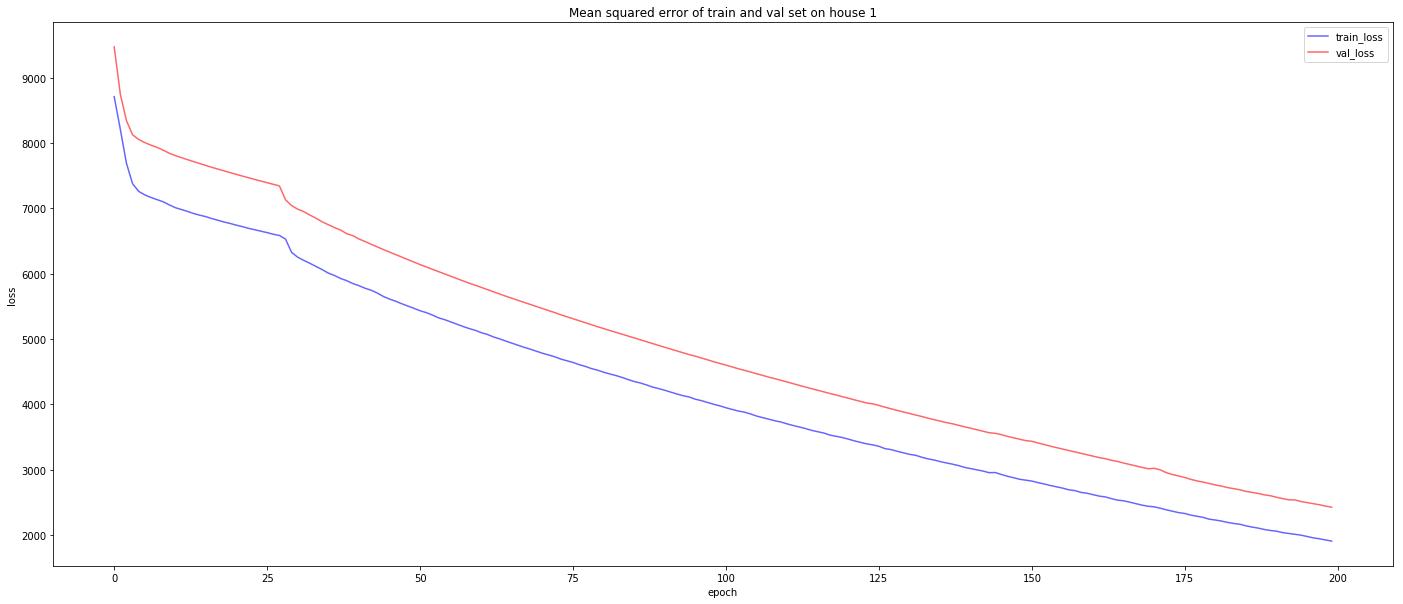

In [104]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [105]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)

(34456,)


In [106]:
mse_loss_lstm = mse_loss(pred_lstm, y_test[:,2])
mae_loss_lstm = mae_loss(pred_lstm, y_test[:,2])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

('Mean square error on test set: ', 3460.1034643790549)
('Mean absolute error on the test set: ', 28.859452192886319)


ValueError: x and y must have same first dimension, but have shapes (20195,) and (18676,)

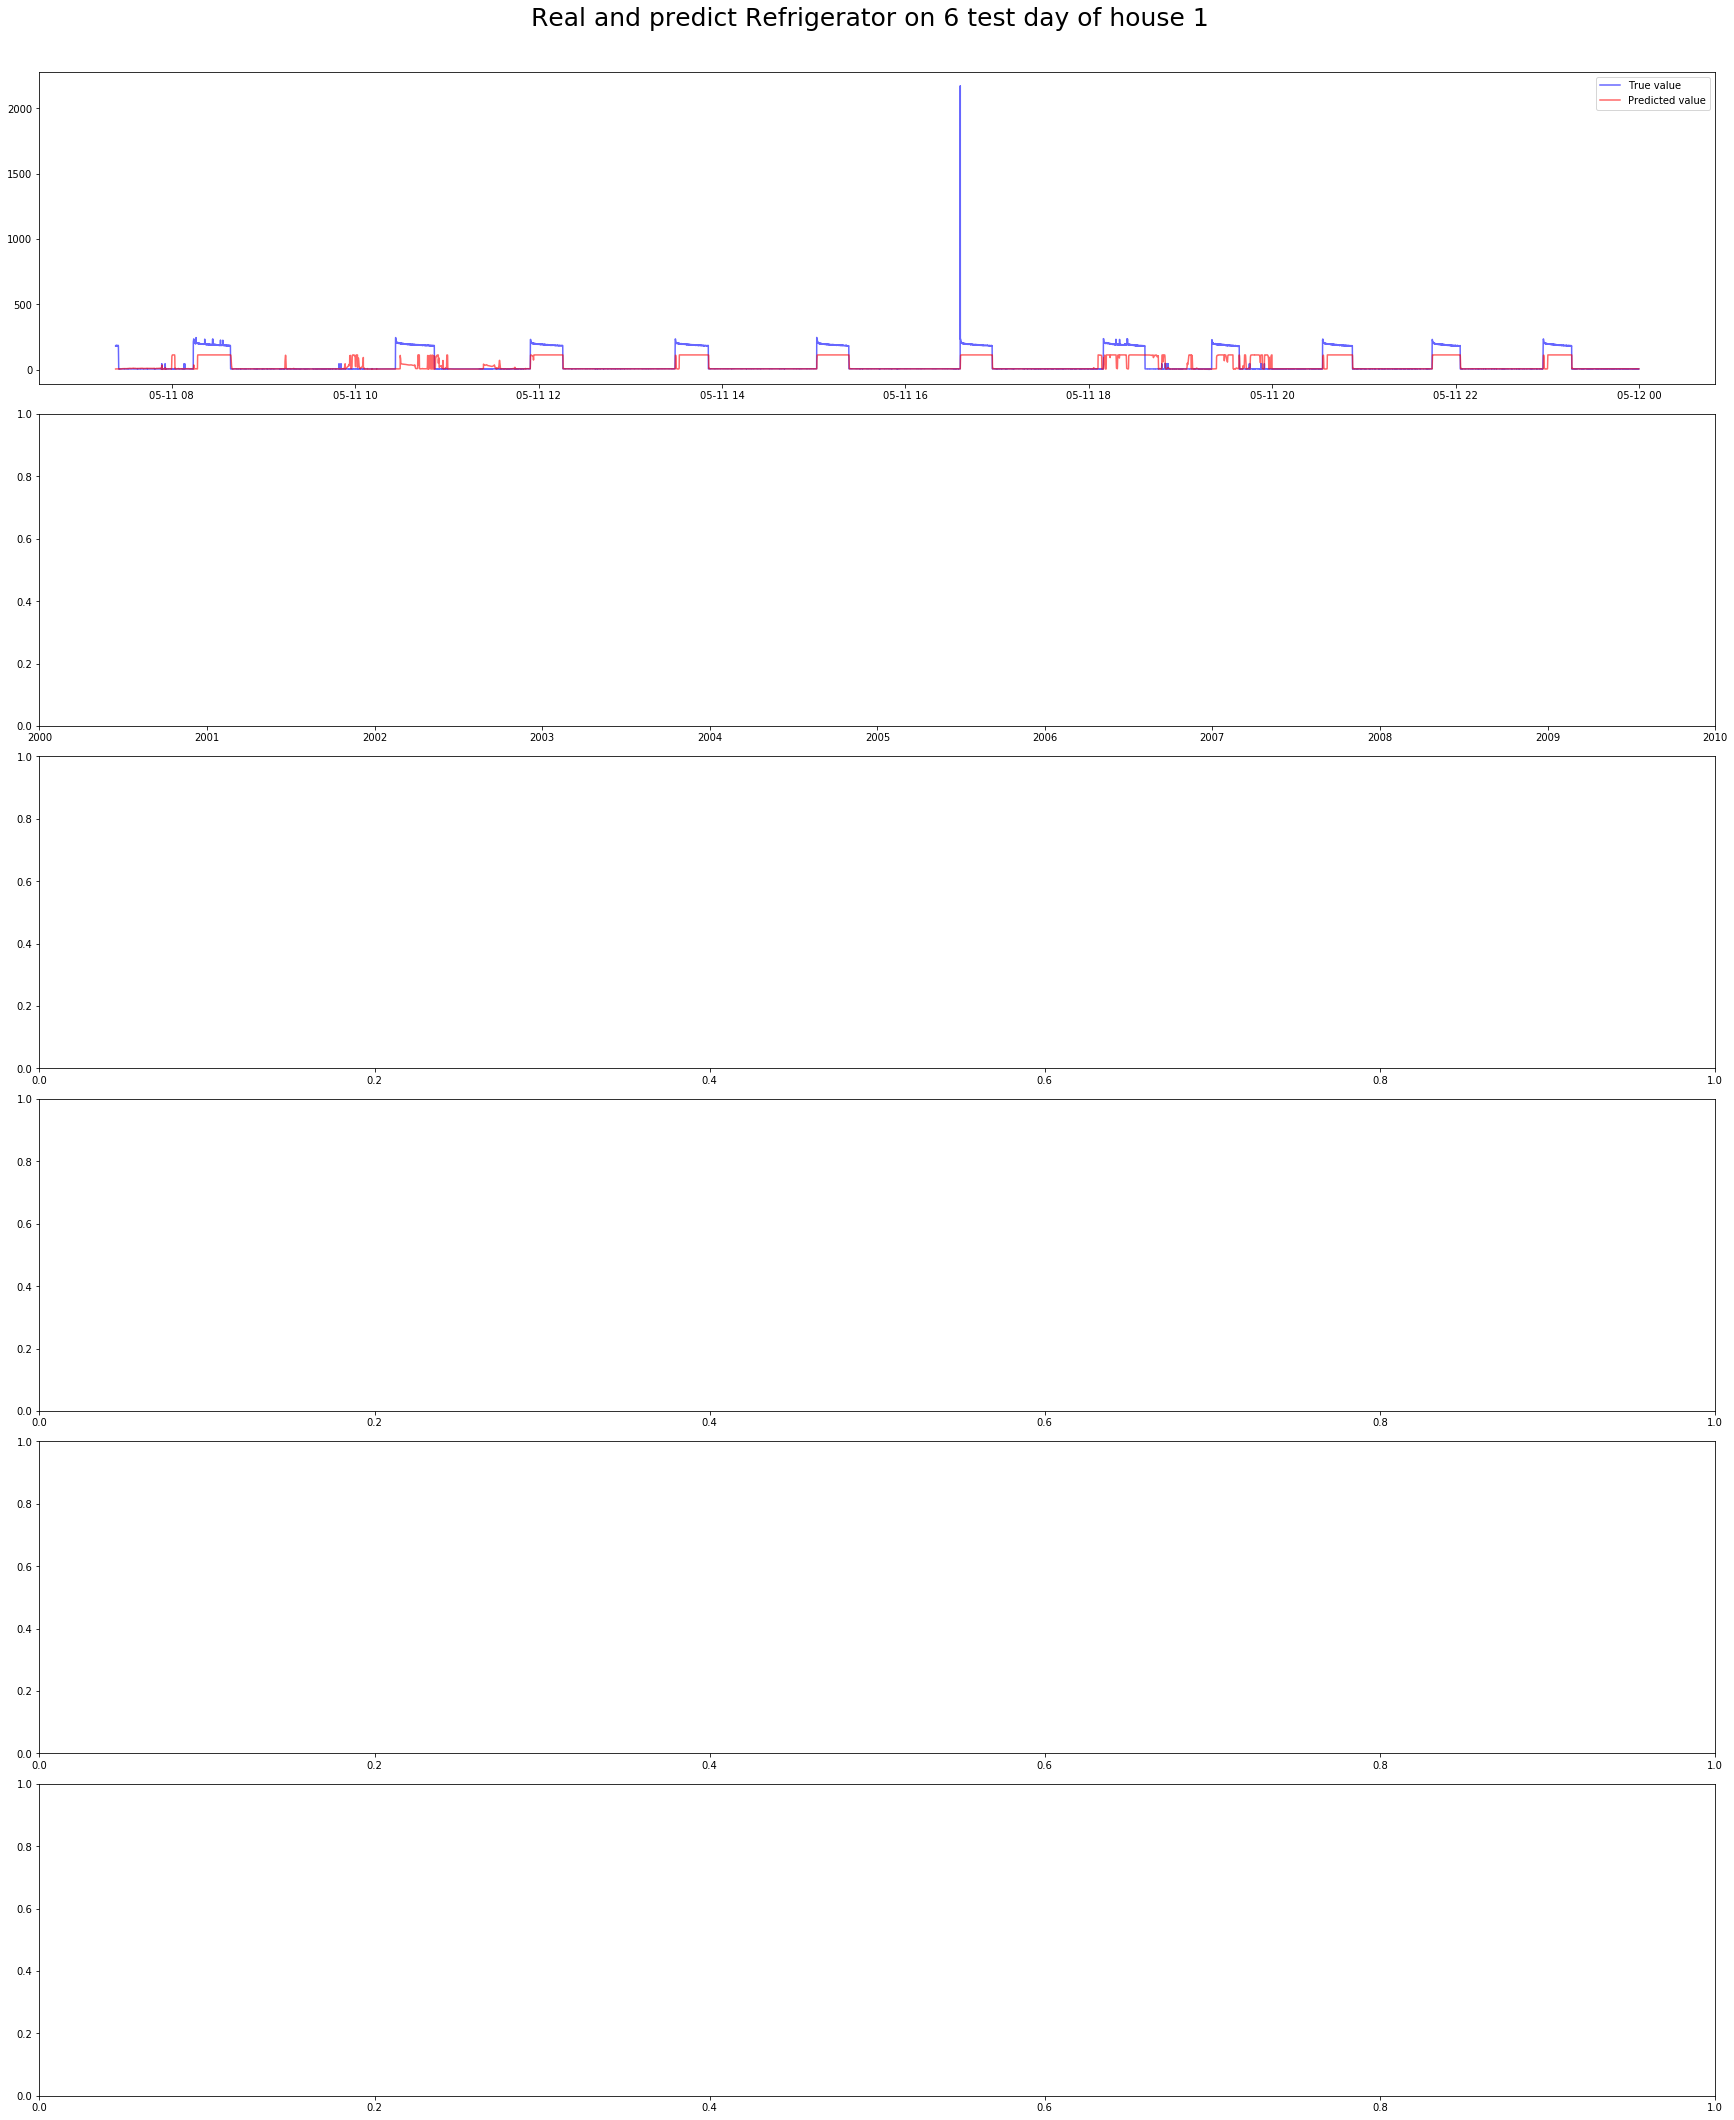

In [107]:
plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test LST model on house 2 

In [108]:
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)


('Mean square error on test set: ', 8957.3281674767095)
('Mean absolute error on the test set: ', 47.854210853952814)


ValueError: x and y must have same first dimension, but have shapes (17590,) and (7606,)

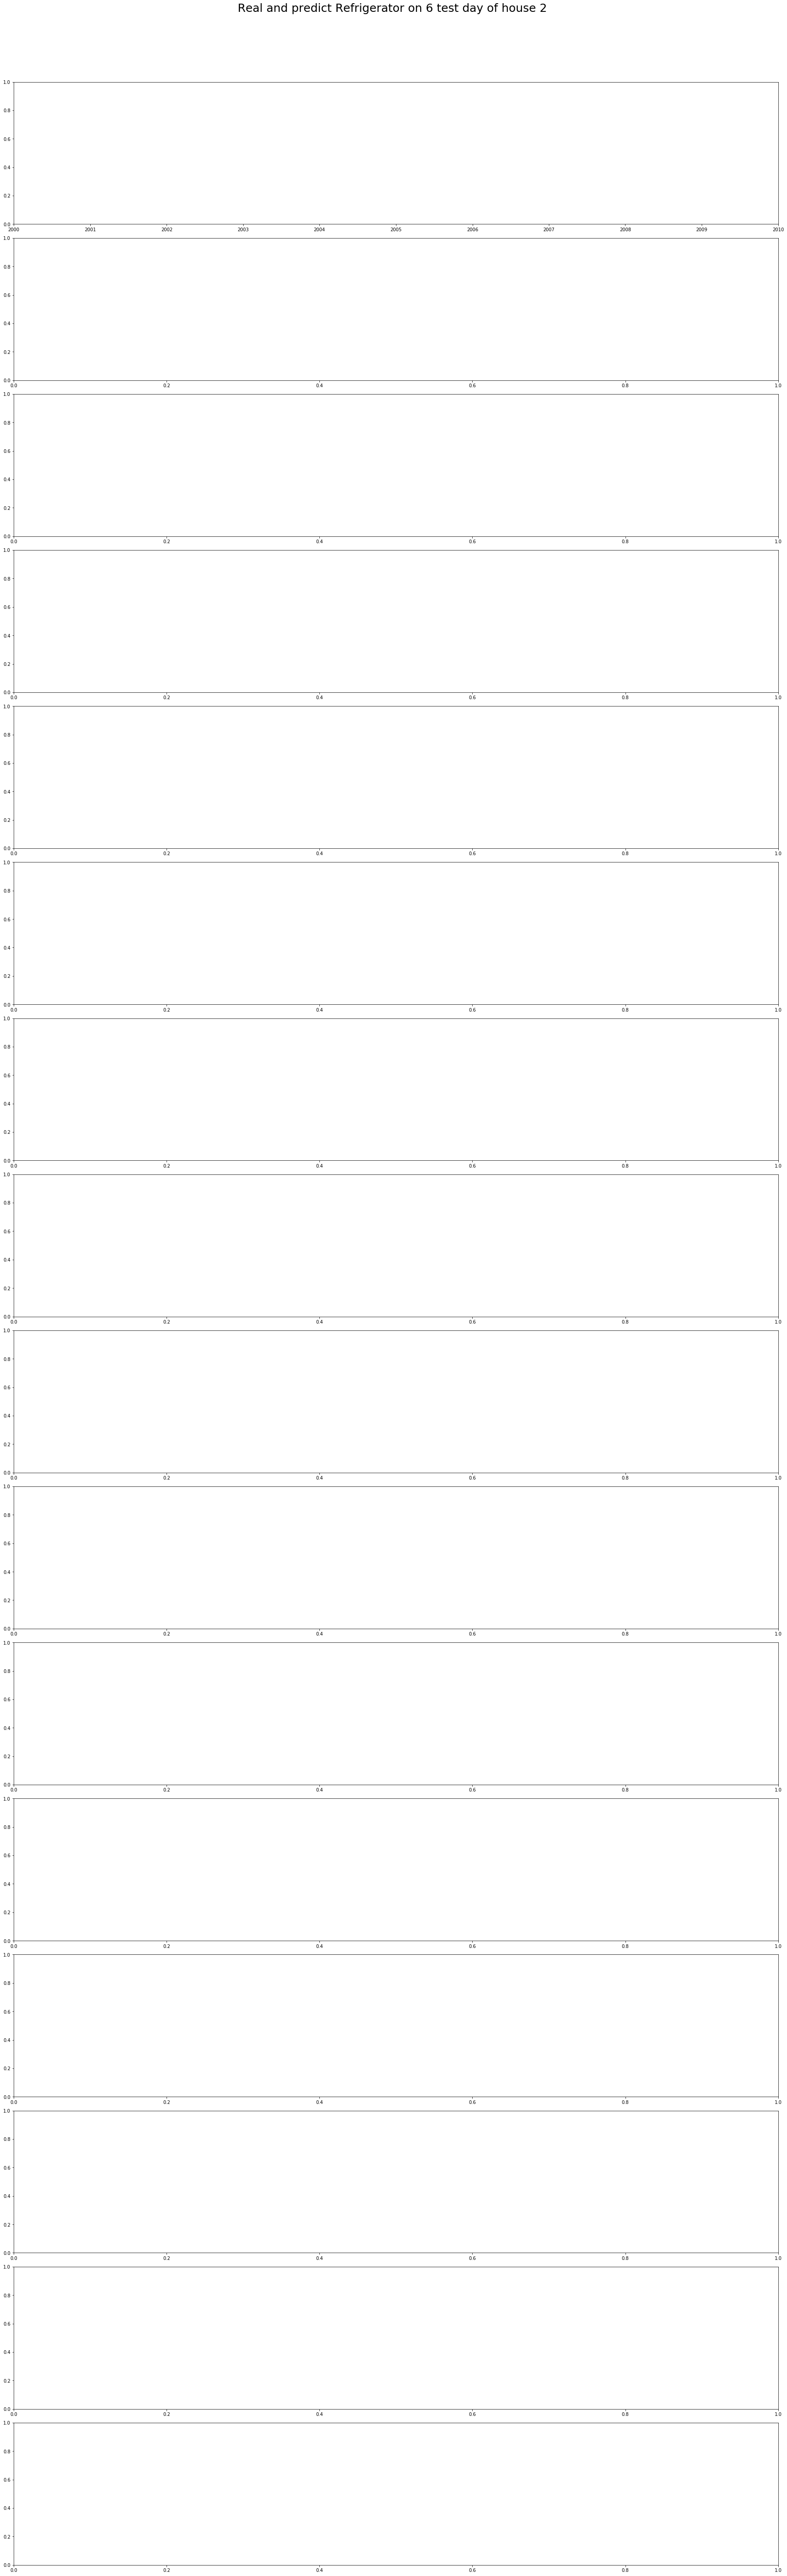

In [109]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2, 
              'Real and predict Refrigerator on 6 test day of house 2', look_back = 50)